In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs and inputs 
try:
    Out.clear() 
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import params, feats, strats, opts, models_core
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strats)
importlib.reload(opts)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import glob
import os
import json
import re
import psutil
import math
from re import findall

import time
from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm
import json
from PIL import Image
import IPython.display as disp
from IPython.display import clear_output, display

# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import seaborn as sns
from pprint import pprint

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage
from optuna.samplers import TPESampler

In [3]:
# ##############################
# ###### ML STRATEGIES DF ######
# ##############################

# df_trainval = pd.read_csv(params.trainval_csv, index_col=0, parse_dates=True)
# baseline_pnl = round((df_trainval["bid"].iloc[-1] - df_trainval["ask"].iloc[0]) / df_trainval.index.normalize().nunique(),4)
# print('baseline profit & loss per day:', baseline_pnl)

# df = df_trainval # SELECT THE CORRECT DATAFRAME
# df.close.plot()
# df

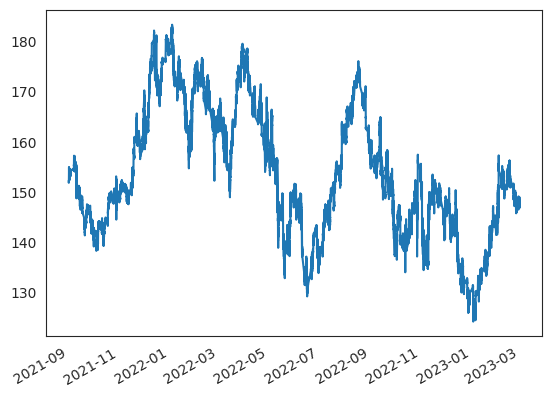

,open,high,low,close,volume,trade_count,vwap,ask,bid,ret,log_ret,sma_5,sma_pct_5,sma_9,sma_pct_9,sma_21,sma_pct_21,sma_50,sma_pct_50,sma_100,sma_pct_100,sma_200,sma_pct_200,ema_9,ema_21,ema_50,roc_5,roc_10,roc_21,body,body_pct,upper_shad,lower_shad,range_pct,rsi_6,rsi_14,rsi_21,macd_line_6_13_5,macd_signal_6_13_5,macd_diff_6_13_5,macd_line_12_26_9,macd_signal_12_26_9,macd_diff_12_26_9,atr_7,atr_pct_7,atr_14,atr_pct_14,atr_28,atr_pct_28,plus_di_7,minus_di_7,adx_7,plus_di_14,minus_di_14,adx_14,plus_di_28,minus_di_28,adx_28,bb_lband_20_2p0,bb_hband_20_2p0,bb_w_20_2p0,bb_lband_20_3p0,bb_hband_20_3p0,bb_w_20_3p0,bb_lband_50_2p0,bb_hband_50_2p0,bb_w_50_2p0,obv,vol_spike_7,vol_spike_14,vol_spike_28,rolling_max_close_200,rolling_min_close_200,dist_high_200,dist_low_200,obv_diff_7,obv_pct_7,obv_diff_21,obv_pct_21,ret_std_21,ret_std_63,stoch_k_14_3_3,stoch_d_14_3_3,stoch_k_9_3_3,stoch_d_9_3_3,cci_14,cci_20,mfi_14,mfi_20,cmf_14,cmf_20,donch_h_20,donch_l_20,donch_w_20,donch_h_55,donch_l_55,donch_w_55,roll_vwap_20,roll_vwap_50,slope_close_20,slope_close_50,kc_mid_20_20_1.5,kc_l_20_20_1.5,kc_h_20_20_1.5,kc_w_20_20_1.5,kc_mid_20_20_2.0,kc_l_20_20_2.0,kc_h_20_20_2.0,kc_w_20_20_2.0,psar,psar_dir,vwap_ohlc_close_session
2021-09-01 08:00:00,152.340,152.400,152.200,152.310,2052.0,79.0,152.343289,152.3405,152.2795,0.002633,0.002630,151.956,0.002330,151.911111,0.002626,151.874286,0.002869,151.8499,0.003030,151.862701,0.002945,151.874676,0.002866,151.953148,151.894996,151.867887,0.002963,0.003095,0.003161,-0.03,-0.000197,0.06,0.11,0.001313,97.117392,92.108647,88.907688,0.072060,0.027698,0.044362,0.043925,0.012360,0.031565,0.093550,0.000614,0.053679,0.000352,0.031763,0.000209,84.467536,3.401602,28.421520,77.491111,7.239535,19.072892,69.968105,11.638923,14.391505,151.674268,152.077732,0.002657,151.573401,152.178599,0.003985,151.714905,151.984895,0.001778,1.529217e+10,0.613270,1.023843,1.224605,152.31,151.82,0.000000,0.003217,19082.0,125.599677,27680.000000,182.256001,0.000579,0.000339,84.482759,94.827586,84.482759,94.827586,466.666667,657.602451,85.708219,81.744827,0.262026,0.233686,152.400000,151.82,0.003808,152.400,151.80,0.003939,151.889248,151.866828,0.007699,0.001677,151.897444,151.836322,151.958567,0.000805,151.897444,151.815948,151.978941,0.001073,151.820000,1,152.310000
2021-09-01 08:01:00,152.310,152.310,152.310,152.310,1163.0,12.0,152.310000,152.3405,152.2795,0.000000,0.000000,152.048,0.001723,151.961111,0.002296,151.896667,0.002721,151.8593,0.002968,151.866702,0.002919,151.876876,0.002852,152.024518,151.932724,151.885225,0.003029,0.003095,0.003095,0.00,0.000000,0.00,0.00,0.000000,97.117392,92.108647,88.907688,0.106679,0.054025,0.052654,0.071035,0.024095,0.046941,0.080186,0.000526,0.049844,0.000327,0.030628,0.000201,84.467536,3.401602,37.540956,77.491111,7.239535,23.632803,69.968105,11.638923,16.430226,151.624973,152.175027,0.003621,151.487459,152.312541,0.005432,151.672758,152.045842,0.002457,1.529217e+10,0.376288,0.576864,0.696184,152.31,151.82,0.000000,0.003217,17295.0,113.788242,26841.000000,176.705655,0.000579,0.000339,84.482759,89.655172,84.482759,89.655172,235.338654,336.051648,85.801987,86.061612,0.295809,0.278437,152.400000,151.82,0.003808,152.400,151.80,0.003939,151.905092,151.875656,0.013173,0.002735,151.936735,151.878669,151.994802,0.000764,151.936735,151.859314,152.014157,0.001019,151.820000,1,152.310000
2021-09-01 08:02:00,152.300,152.300,152.300,152.300,900.0,32.5,152.300000,152.3305,152.2695,-0.000066,-0.000066,152.138,0.001065,152.011111,0.001900,151.919048,0.002508,151.8687,0.002840,151.870602,0.002827,151.879026,0.002772,152.079614,151.966113,151.901491,0.002963,0.002897,0.003096,0.00,0.000000,0.00,0.00,0.000000,94.266696,90.188784,87.281932,0.122091,0.076714,0.045377,0.090669,0.037410,0.053259,0.070159,0.000461,0.046998,0.000309,0.029892,0.000196,82.747626,5.368519,44.722948,76.313395,8.649316,27.633299,69.132130,12.694655,18.306713,151.598286,152.246714,0.004268,151.436178,152.408822,0.006402,151.645288,152.092112,0.0029

In [4]:
##############################
## INDICATORS STRATEGIES DF ##
##############################

# Read sign timestamps ( since selected year, with pre-market included)
df_inds = pd.read_csv(params.indunsc_csv, index_col=0, parse_dates=True) ############### 
df_inds = df_inds[(df_inds.index >= '2021-09-01') & (df_inds.index < '2023-03-01')] #########################

df = df_inds # SELECT THE CORRECT DATAFRAME
df.close.plot()
plt.show()
df

In [5]:
# # propose adjusted parameters ranges for next optuna run

# new_ranges = opts.propose_ranges_from_top(
#     csv_path="optuna_results/AAPL_13388051396.1535_target.csv",
#     top_n=25,
#     spread=10.0,
#     agg="median",
#     cat_top_k=3,
# )

# new_ranges

In [7]:
# Pre-compute per-day slices once
groups = df.groupby(df.index.normalize())
prun_perc = 80 # higher value means the pruner keeps more trials (e.g., 90 keeps the top 10%)
report_interval = 50
_findall = re.compile(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?").findall

def objective(trial: optuna.Trial) -> float:

    reset_peak       = trial.suggest_categorical("reset_peak", [False])
    rsi_min_thresh   = trial.suggest_int("rsi_min_thresh", 10, 50)
    rsi_max_thresh   = trial.suggest_int("rsi_max_thresh", max(rsi_min_thresh + 1, 60), 100)
    vol_thresh       = trial.suggest_float("vol_thresh", 0.5, 5.0)
    adx_thresh       = trial.suggest_float("adx_thresh", 10.0, 50.0)
    atr_mult         = trial.suggest_float("atr_mult", 0.1, 3.0, log=True)
    vwap_atr_mult    = trial.suggest_float("vwap_atr_mult", -10.0, 3.0)
    buy_factor       = trial.suggest_float("buy_factor", 0.05, 0.95)
    sell_factor      = trial.suggest_float("sell_factor", 0.05, 0.95)
    trailstop_pct    = trial.suggest_float("trailstop_pct", 2.0, 20.0)
    sign_thresh_pair = trial.suggest_categorical("sign_thresh_pair",[ 
                                                    # "ema_3|ema_8",
                                                    # "ema_5|ema_13"
                                                    "ema_9|ema_21",
                                                    # "ema_21|ema_50",
                                                    # "roc_5|ema_21"
                                                    # "roc_5|0.0"
                                                    # "macd_line_12_26_9|0.0"
                                                    # "macd_diff_6_13_5|0.0"
                                                    # "rsi_14|50.0"
                                                    # "rsi_6|50.0"
                                                ])
    col_signal, sign_thresh = sign_thresh_pair.split("|")
    try: # convert numeric thresholds (only if numeric)
        sign_thresh = float(sign_thresh)
    except ValueError:
        pass
    
    print('-' * 160)
    print("Params => " + "; ".join(f"{k}={v}" for k, v in dict(trial.params).items()))

    start_ask = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
    strats.reset_globals(start_ask)  # necessary to correctly reset the global variables before each independent simulation
    
    daily_pnls: List[float] = []
    daily_bh_pnls: List[float] = []
    trades_count = 0
    holds_count = 0 
    total_bars = 0
    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)

    trial_action_counts = {"Buy": 0, "Sell": 0, "Hold": 0}
    
    for step, (day, df_day) in enumerate(pbar, 1):

        df_actions = strats.generate_actions_alpaca(
            df              = df_day,
            col_atr         = params.col_atr_tick,
            col_adx         = params.col_adx_tick,
            col_vol_spike   = params.col_vol_spike_tick,
            col_rsi         = params.col_rsi_tick,
            col_vwap        = params.col_vwap_tick,
            col_signal      = col_signal,
            sign_thresh     = sign_thresh,
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            vol_thresh      = vol_thresh,
            adx_thresh      = adx_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
            # sess_start      = params.sess_start_tick
        )

        sim_results = strats.simulate_trading(
            day             = day,
            df              = df_actions,
            buy_factor      = buy_factor,
            sell_factor     = sell_factor,
        )
   
        df_sim, trades, stats = next(iter(sim_results.values()))

        # accumulate executed Action counts from df_sim
        trial_action_counts["Buy"] += int((df_sim["Action"] == "Buy").sum())
        trial_action_counts["Sell"] += int((df_sim["Action"] == "Sell").sum())
        trial_action_counts["Hold"] += int((df_sim["Action"] == "Hold").sum())

        trades_count += len(trades)
        holds_count += int((df_sim["Action"] == "Hold").sum())
        total_bars += len(df_sim)

        daily_pnls.append(strats._parse_eq_value(stats['STRATEGY']))
        daily_bh_pnls.append(strats._parse_eq_value(stats['BUYNHOLD']))

        # Explicitly delete large locals at the end of each iteration
        del df_actions, sim_results, stats
        df_day = df_actions = sim_results = stats = None

        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
            
            # sets partial set_user_attr (just to be available if trial pruned)
            trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
            trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
            trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
            
            trial.report(float(prun_val), report_step)
            if trial.should_prune():
                vals = [t.intermediate_values[report_step]
                        for t in trial.study.get_trials(deepcopy=False)
                        if t.state == TrialState.COMPLETE and report_step in t.intermediate_values]
                thr = np.percentile(vals, prun_perc)
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    # sets final set_user_attr
    trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
    trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
    trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
    
    mean_excess = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
    return float(mean_excess)


Baseline mean daily B&H: -9.5162


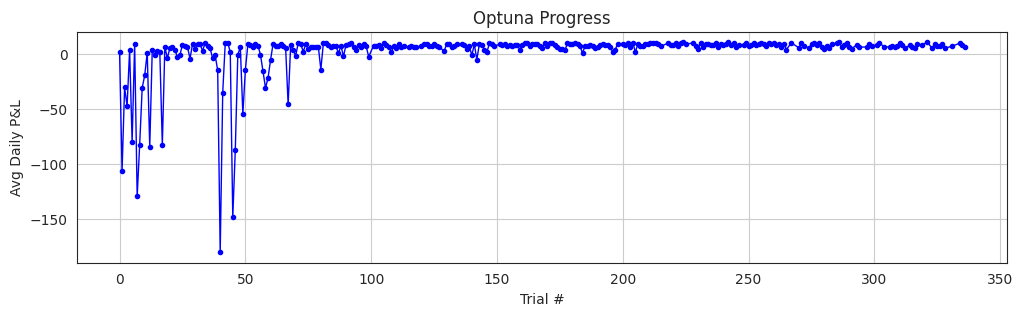

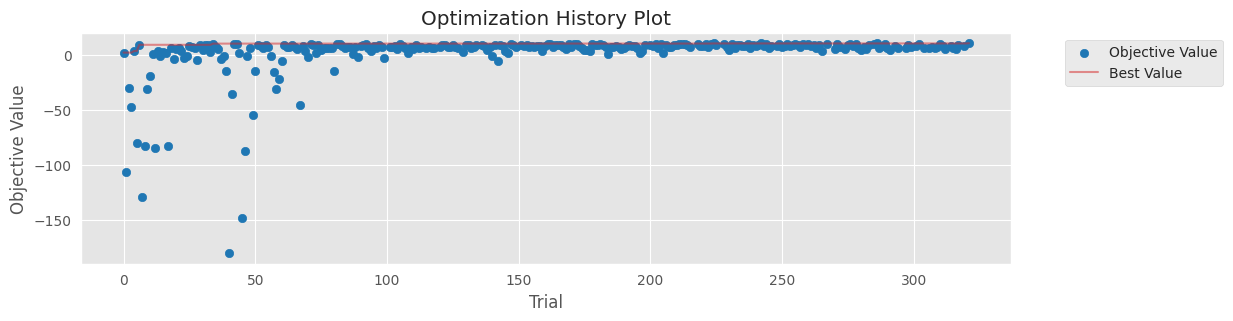

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=69; vol_thresh=3.780371483876176; adx_thresh=33.357836512009094; atr_mult=0.4301502427462614; vwap_atr_mult=-9.596754372509498; buy_factor=0.07363371695727769; sell_factor=0.39028710116058773; trailstop_pct=6.2685139249687865; tc_pair=ema_9|ema_21


Trial 0: 100%|██████████| 375/375 [00:25<00:00, 14.58it/s]


[Results] mean_pnl:-6.6122 mean_bh:-8.7491 mean_excess:2.1369 improv_vs_bh:24.42%
Action counts: {'Buy': 452, 'Sell': 2531, 'Hold': 347728}
Best trial is: 0 with best_val: 2.1369
[save_results] wrote optuna_results/AAPL_2.1369_predicted.csv
[save_best_json] wrote optuna_results/AAPL_2.1369_predicted.json
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=90; vol_thresh=4.321625532202225; adx_thresh=19.59138863334307; atr_mult=1.738550335211201; vwap_atr_mult=-3.1334980084481794; buy_factor=0.732795727663855; sell_factor=0.7859853863707793; trailstop_pct=3.604879440095006; tc_pair=ema_9|ema_21


Trial 1: 100%|██████████| 375/375 [00:23<00:00, 16.05it/s]


[Results] mean_pnl:-115.2912 mean_bh:-8.7491 mean_excess:-106.5421 improv_vs_bh:-1217.75%
Action counts: {'Buy': 1080, 'Sell': 3396, 'Hold': 346235}
Best trial is: 0 with best_val: 2.1369
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=74; vol_thresh=1.2993944336962808; adx_thresh=47.93553589880472; atr_mult=0.14791529188118666; vwap_atr_mult=-2.5822713596854054; buy_factor=0.41525746426951265; sell_factor=0.6051722608351188; trailstop_pct=14.884686540620264; tc_pair=ema_9|ema_21


Trial 2: 100%|██████████| 375/375 [00:24<00:00, 15.33it/s]


[Results] mean_pnl:-39.1352 mean_bh:-8.7491 mean_excess:-30.3861 improv_vs_bh:-347.31%
Action counts: {'Buy': 1542, 'Sell': 2728, 'Hold': 346441}
Best trial is: 0 with best_val: 2.1369
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=86; vol_thresh=0.9617145487276553; adx_thresh=49.17418666436355; atr_mult=0.6729989485982987; vwap_atr_mult=-7.090716783041924; buy_factor=0.9427573709956144; sell_factor=0.40094292200211834; trailstop_pct=13.57951599989263; tc_pair=ema_9|ema_21


Trial 3: 100%|██████████| 375/375 [00:23<00:00, 16.17it/s]


[Results] mean_pnl:-56.0281 mean_bh:-8.7491 mean_excess:-47.2790 improv_vs_bh:-540.39%
Action counts: {'Buy': 1066, 'Sell': 5025, 'Hold': 344620}
Best trial is: 0 with best_val: 2.1369
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=71; vol_thresh=4.4097794396289345; adx_thresh=46.0353523331785; atr_mult=0.8490595236364642; vwap_atr_mult=-5.784231899379996; buy_factor=0.44457068368389124; sell_factor=0.6718989230932663; trailstop_pct=19.8832140426222; tc_pair=ema_9|ema_21


Trial 4: 100%|██████████| 375/375 [00:24<00:00, 15.11it/s]


[Results] mean_pnl:-5.1952 mean_bh:-8.7491 mean_excess:3.5539 improv_vs_bh:40.62%
Action counts: {'Buy': 88, 'Sell': 396, 'Hold': 350227}
Best trial is: 4 with best_val: 3.5539
[save_results] wrote optuna_results/AAPL_3.5539_predicted.csv
[save_best_json] wrote optuna_results/AAPL_3.5539_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=71; vol_thresh=1.7083082198498214; adx_thresh=40.78561125798073; atr_mult=0.40322608988887737; vwap_atr_mult=-2.9517996727393916; buy_factor=0.7108902798361122; sell_factor=0.4059145799704357; trailstop_pct=13.089410282094363; tc_pair=ema_9|ema_21


Trial 5: 100%|██████████| 375/375 [00:23<00:00, 15.92it/s]


[Results] mean_pnl:-88.5774 mean_bh:-8.7491 mean_excess:-79.8283 improv_vs_bh:-912.42%
Action counts: {'Buy': 1535, 'Sell': 6926, 'Hold': 342250}
Best trial is: 4 with best_val: 3.5539
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=60; vol_thresh=3.7348117914853143; adx_thresh=47.74974037207909; atr_mult=1.7519431572127449; vwap_atr_mult=-8.634315053696175; buy_factor=0.09941540294572326; sell_factor=0.4953302037839202; trailstop_pct=12.168413407683504; tc_pair=ema_9|ema_21


Trial 6: 100%|██████████| 375/375 [00:22<00:00, 16.45it/s]


[Results] mean_pnl:0.4678 mean_bh:-8.7491 mean_excess:9.2169 improv_vs_bh:105.35%
Action counts: {'Buy': 103, 'Sell': 568, 'Hold': 350040}
Best trial is: 6 with best_val: 9.2169
[save_results] wrote optuna_results/AAPL_9.2169_predicted.csv
[save_best_json] wrote optuna_results/AAPL_9.2169_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=83; vol_thresh=4.279062811726416; adx_thresh=17.742719781072118; atr_mult=0.11155421364639552; vwap_atr_mult=0.581355191089914; buy_factor=0.8790118929332038; sell_factor=0.8571344097042405; trailstop_pct=4.403680752401231; tc_pair=ema_9|ema_21


Trial 7: 100%|██████████| 375/375 [00:23<00:00, 16.22it/s]


[Results] mean_pnl:-138.2599 mean_bh:-8.7491 mean_excess:-129.5109 improv_vs_bh:-1480.28%
Action counts: {'Buy': 1168, 'Sell': 3345, 'Hold': 346198}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=69; vol_thresh=2.4139819366213593; adx_thresh=28.58833562433958; atr_mult=0.5040765499234217; vwap_atr_mult=1.526231189375416; buy_factor=0.5005744434860474; sell_factor=0.41607084214355594; trailstop_pct=13.248902717938856; tc_pair=ema_9|ema_21


Trial 8: 100%|██████████| 375/375 [00:24<00:00, 15.46it/s]


[Results] mean_pnl:-91.0726 mean_bh:-8.7491 mean_excess:-82.3235 improv_vs_bh:-940.94%
Action counts: {'Buy': 1819, 'Sell': 9376, 'Hold': 339516}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=64; vol_thresh=3.6583805093863164; adx_thresh=12.799083849406516; atr_mult=0.6931863358561026; vwap_atr_mult=-5.860254845307896; buy_factor=0.11082152478207485; sell_factor=0.7594291453314786; trailstop_pct=7.147838352145497; tc_pair=ema_9|ema_21


Trial 9: 100%|██████████| 375/375 [00:26<00:00, 13.94it/s]


[Results] mean_pnl:-39.5206 mean_bh:-8.7491 mean_excess:-30.7715 improv_vs_bh:-351.71%
Action counts: {'Buy': 2022, 'Sell': 4527, 'Hold': 344162}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=97; vol_thresh=2.950462313993326; adx_thresh=37.508680773390886; atr_mult=2.978353952435818; vwap_atr_mult=-9.202791455797243; buy_factor=0.25390061220616067; sell_factor=0.11344250655462618; trailstop_pct=9.571467179136718; tc_pair=ema_9|ema_21


Trial 10: 100%|██████████| 375/375 [00:23<00:00, 16.22it/s]


[Results] mean_pnl:-28.2495 mean_bh:-8.7491 mean_excess:-19.5004 improv_vs_bh:-222.88%
Action counts: {'Buy': 599, 'Sell': 11085, 'Hold': 339027}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=62; vol_thresh=4.975375265632473; adx_thresh=43.082109641763076; atr_mult=1.26065757926444; vwap_atr_mult=-6.2545822265757005; buy_factor=0.36539143114206546; sell_factor=0.6572138028789785; trailstop_pct=19.02106374937053; tc_pair=ema_9|ema_21


Trial 11: 100%|██████████| 375/375 [00:23<00:00, 16.23it/s]


[Results] mean_pnl:-7.4351 mean_bh:-8.7491 mean_excess:1.3140 improv_vs_bh:15.02%
Action counts: {'Buy': 88, 'Sell': 448, 'Hold': 350175}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=60; vol_thresh=3.1086786793472623; adx_thresh=27.346417022686996; atr_mult=1.2624449086330032; vwap_atr_mult=-7.653184567967017; buy_factor=0.5773118443334704; sell_factor=0.19338688848122038; trailstop_pct=19.196013702839043; tc_pair=ema_9|ema_21


Trial 12: 100%|██████████| 375/375 [00:23<00:00, 15.64it/s]


[Results] mean_pnl:-93.1577 mean_bh:-8.7491 mean_excess:-84.4086 improv_vs_bh:-964.77%
Action counts: {'Buy': 1259, 'Sell': 16653, 'Hold': 332799}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=77; vol_thresh=4.9219146436077335; adx_thresh=45.112876487922584; atr_mult=2.9314635061197087; vwap_atr_mult=-4.898112899733328; buy_factor=0.2583427987003106; sell_factor=0.5865717109094606; trailstop_pct=16.463722416566775; tc_pair=ema_9|ema_21


Trial 13: 100%|██████████| 375/375 [00:21<00:00, 17.60it/s]


[Results] mean_pnl:-4.7201 mean_bh:-8.7491 mean_excess:4.0289 improv_vs_bh:46.05%
Action counts: {'Buy': 73, 'Sell': 403, 'Hold': 350235}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=77; vol_thresh=4.981479749081608; adx_thresh=35.968083547558564; atr_mult=2.7988245849572255; vwap_atr_mult=-0.3149806044104526; buy_factor=0.2460468756219647; sell_factor=0.536815718636909; trailstop_pct=15.9942063129625; tc_pair=ema_9|ema_21


Trial 14: 100%|██████████| 375/375 [00:22<00:00, 16.46it/s]


[Results] mean_pnl:-9.7790 mean_bh:-8.7491 mean_excess:-1.0299 improv_vs_bh:-11.77%
Action counts: {'Buy': 182, 'Sell': 1022, 'Hold': 349507}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=99; vol_thresh=3.6085397939583315; adx_thresh=42.04816886774318; atr_mult=2.0382143513416233; vwap_atr_mult=-4.60372408809289; buy_factor=0.19329864221113713; sell_factor=0.23835754767416983; trailstop_pct=10.147724029325301; tc_pair=ema_9|ema_21


Trial 15: 100%|██████████| 375/375 [00:24<00:00, 15.07it/s]


[Results] mean_pnl:-5.7214 mean_bh:-8.7491 mean_excess:3.0277 improv_vs_bh:34.61%
Action counts: {'Buy': 226, 'Sell': 2610, 'Hold': 347875}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=79; vol_thresh=2.568780469930644; adx_thresh=49.292887716984865; atr_mult=0.2828939144475987; vwap_atr_mult=-8.339130043513675; buy_factor=0.3085522577266575; sell_factor=0.5147459817985843; trailstop_pct=16.507889669761504; tc_pair=ema_9|ema_21


Trial 16: 100%|██████████| 375/375 [00:25<00:00, 14.72it/s]


[Results] mean_pnl:-6.8587 mean_bh:-8.7491 mean_excess:1.8904 improv_vs_bh:21.61%
Action counts: {'Buy': 210, 'Sell': 984, 'Hold': 349517}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=92; vol_thresh=1.993914222811411; adx_thresh=24.34169775921049; atr_mult=1.6442797280997687; vwap_atr_mult=-1.1337943150237098; buy_factor=0.15013187996950367; sell_factor=0.2455814462216661; trailstop_pct=11.38352201370174; tc_pair=ema_9|ema_21


Trial 17: 100%|██████████| 375/375 [00:31<00:00, 11.84it/s]


[Results] mean_pnl:-91.3681 mean_bh:-8.7491 mean_excess:-82.6190 improv_vs_bh:-944.32%
Action counts: {'Buy': 5043, 'Sell': 26618, 'Hold': 319050}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=65; vol_thresh=4.56719897622961; adx_thresh=38.280890666354566; atr_mult=1.0941499634941732; vwap_atr_mult=-4.887761447941582; buy_factor=0.06818036718931017; sell_factor=0.5827266946932316; trailstop_pct=17.324842486580565; tc_pair=ema_9|ema_21


Trial 18: 100%|██████████| 375/375 [00:26<00:00, 14.15it/s]


[Results] mean_pnl:-2.3944 mean_bh:-8.7491 mean_excess:6.3547 improv_vs_bh:72.63%
Action counts: {'Buy': 171, 'Sell': 624, 'Hold': 349916}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=65; vol_thresh=3.3004131637749303; adx_thresh=32.661666771664684; atr_mult=0.9886255335982564; vwap_atr_mult=-4.438650983704303; buy_factor=0.0733375133118321; sell_factor=0.8918374687524633; trailstop_pct=17.713406490666305; tc_pair=ema_9|ema_21


Trial 19: 100%|██████████| 375/375 [00:32<00:00, 11.71it/s]


[Results] mean_pnl:-12.5107 mean_bh:-8.7491 mean_excess:-3.7616 improv_vs_bh:-42.99%
Action counts: {'Buy': 688, 'Sell': 1020, 'Hold': 349003}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=66; vol_thresh=3.9128706909351805; adx_thresh=37.796433832069255; atr_mult=0.22612471486401048; vwap_atr_mult=-1.5168988528954632; buy_factor=0.05365013728154622; sell_factor=0.32038649727101887; trailstop_pct=7.921039434827986; tc_pair=ema_9|ema_21


Trial 20: 100%|██████████| 375/375 [00:40<00:00,  9.26it/s]


[Results] mean_pnl:-3.4345 mean_bh:-8.7491 mean_excess:5.3145 improv_vs_bh:60.74%
Action counts: {'Buy': 255, 'Sell': 1693, 'Hold': 348763}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=65; vol_thresh=3.9746514808960773; adx_thresh=39.602897959583416; atr_mult=0.2509858284628626; vwap_atr_mult=-2.0158809807815614; buy_factor=0.053250902666524755; sell_factor=0.3183692376601863; trailstop_pct=8.021519680266906; tc_pair=ema_9|ema_21


Trial 21: 100%|██████████| 375/375 [00:28<00:00, 13.21it/s]


[Results] mean_pnl:-2.5490 mean_bh:-8.7491 mean_excess:6.2001 improv_vs_bh:70.87%
Action counts: {'Buy': 204, 'Sell': 1376, 'Hold': 349131}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=62; vol_thresh=4.497432702787026; adx_thresh=39.346044555995356; atr_mult=0.25569444236272315; vwap_atr_mult=-1.3461134930703542; buy_factor=0.17293914498469778; sell_factor=0.4742867337439815; trailstop_pct=11.59339425582412; tc_pair=ema_9|ema_21


Trial 22: 100%|██████████| 375/375 [00:30<00:00, 12.29it/s]


[Results] mean_pnl:-4.7994 mean_bh:-8.7491 mean_excess:3.9497 improv_vs_bh:45.14%
Action counts: {'Buy': 158, 'Sell': 1005, 'Hold': 349548}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=60; vol_thresh=4.081586865252759; adx_thresh=33.853618047446076; atr_mult=1.2286695570130537; vwap_atr_mult=-8.356083361966569; buy_factor=0.1639450927560743; sell_factor=0.32388293012299896; trailstop_pct=8.619523829522707; tc_pair=ema_9|ema_21


Trial 23: 100%|██████████| 375/375 [00:28<00:00, 13.27it/s]


[Results] mean_pnl:-11.8308 mean_bh:-8.7491 mean_excess:-3.0818 improv_vs_bh:-35.22%
Action counts: {'Buy': 346, 'Sell': 3100, 'Hold': 347265}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=67; vol_thresh=3.4494910942730312; adx_thresh=43.50409063065881; atr_mult=0.17663703035809494; vwap_atr_mult=2.788507715348387; buy_factor=0.31734896931605705; sell_factor=0.4894916428883022; trailstop_pct=5.723190967624855; tc_pair=ema_9|ema_21


Trial 24: 100%|██████████| 375/375 [00:26<00:00, 14.10it/s]


[Results] mean_pnl:-9.4531 mean_bh:-8.7491 mean_excess:-0.7040 improv_vs_bh:-8.05%
Action counts: {'Buy': 173, 'Sell': 1075, 'Hold': 349463}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=74; vol_thresh=4.582696243313842; adx_thresh=46.402412787343025; atr_mult=0.3426521214501069; vwap_atr_mult=-3.9485629845416783; buy_factor=0.05210565781144876; sell_factor=0.719243419737715; trailstop_pct=11.772615887507307; tc_pair=ema_9|ema_21


Trial 25: 100%|██████████| 375/375 [00:33<00:00, 11.30it/s]


[Results] mean_pnl:-0.6573 mean_bh:-8.7491 mean_excess:8.0918 improv_vs_bh:92.49%
Action counts: {'Buy': 73, 'Sell': 200, 'Hold': 350438}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=74; vol_thresh=4.601997054259803; adx_thresh=46.14103934526914; atr_mult=2.0786672248875946; vwap_atr_mult=-3.8838226502525295; buy_factor=0.13087495461997894; sell_factor=0.7424584720190549; trailstop_pct=14.685752555697082; tc_pair=ema_9|ema_21


Trial 26: 100%|██████████| 375/375 [00:28<00:00, 13.05it/s]


[Results] mean_pnl:-1.7144 mean_bh:-8.7491 mean_excess:7.0347 improv_vs_bh:80.40%
Action counts: {'Buy': 75, 'Sell': 263, 'Hold': 350373}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=74; vol_thresh=4.716967451249174; adx_thresh=46.355599102933326; atr_mult=0.333038598734301; vwap_atr_mult=-3.674052528086259; buy_factor=0.20700946768227535; sell_factor=0.7404835476539176; trailstop_pct=12.196831644845489; tc_pair=ema_9|ema_21


Trial 27: 100%|██████████| 375/375 [00:27<00:00, 13.86it/s]


[Results] mean_pnl:-2.5344 mean_bh:-8.7491 mean_excess:6.2147 improv_vs_bh:71.03%
Action counts: {'Buy': 69, 'Sell': 251, 'Hold': 350391}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=84; vol_thresh=4.061373369154937; adx_thresh=45.00770659878455; atr_mult=2.0902453707161284; vwap_atr_mult=-4.018816486767081; buy_factor=0.5770808554253274; sell_factor=0.8080048008305538; trailstop_pct=2.0733273371034144; tc_pair=ema_9|ema_21


Trial 28: 100%|██████████| 375/375 [00:24<00:00, 15.44it/s]


[Results] mean_pnl:-13.0119 mean_bh:-8.7491 mean_excess:-4.2629 improv_vs_bh:-48.72%
Action counts: {'Buy': 118, 'Sell': 399, 'Hold': 350194}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=74; vol_thresh=3.809006028879904; adx_thresh=49.621922594982905; atr_mult=0.43763978887351723; vwap_atr_mult=-9.56042938593556; buy_factor=0.11466127259145709; sell_factor=0.6976474153603252; trailstop_pct=14.265434794369366; tc_pair=ema_9|ema_21


Trial 29: 100%|██████████| 375/375 [00:22<00:00, 16.88it/s]


[Results] mean_pnl:0.1787 mean_bh:-8.7491 mean_excess:8.9278 improv_vs_bh:102.04%
Action counts: {'Buy': 69, 'Sell': 221, 'Hold': 350421}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=81; vol_thresh=2.9091568005699324; adx_thresh=49.92558688044561; atr_mult=0.45611471923881214; vwap_atr_mult=-9.898582883525584; buy_factor=0.31244798703862553; sell_factor=0.6879120338702903; trailstop_pct=10.421002825330218; tc_pair=ema_9|ema_21


Trial 30: 100%|██████████| 375/375 [00:21<00:00, 17.14it/s]


[Results] mean_pnl:-3.8226 mean_bh:-8.7491 mean_excess:4.9265 improv_vs_bh:56.31%
Action counts: {'Buy': 136, 'Sell': 486, 'Hold': 350089}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=75; vol_thresh=3.784816279793324; adx_thresh=47.05275033448967; atr_mult=0.6431590499377883; vwap_atr_mult=-9.000037764409397; buy_factor=0.13462957504344525; sell_factor=0.925609111745601; trailstop_pct=14.850456820201135; tc_pair=ema_9|ema_21


Trial 31: 100%|██████████| 375/375 [00:22<00:00, 16.31it/s]


[Results] mean_pnl:0.0716 mean_bh:-8.7491 mean_excess:8.8207 improv_vs_bh:100.82%
Action counts: {'Buy': 108, 'Sell': 177, 'Hold': 350426}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=72; vol_thresh=3.709463259902386; adx_thresh=47.57093791821105; atr_mult=0.3825568348560628; vwap_atr_mult=-9.116252412085739; buy_factor=0.11554183671178303; sell_factor=0.924452468658581; trailstop_pct=14.69324489896376; tc_pair=ema_9|ema_21


Trial 32: 100%|██████████| 375/375 [00:18<00:00, 19.98it/s]


[Results] mean_pnl:0.3478 mean_bh:-8.7491 mean_excess:9.0969 improv_vs_bh:103.98%
Action counts: {'Buy': 108, 'Sell': 177, 'Hold': 350426}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=71; vol_thresh=3.2838129299395638; adx_thresh=42.83688242662288; atr_mult=0.6132363516538903; vwap_atr_mult=-9.058100023596182; buy_factor=0.1195702149005401; sell_factor=0.9210205949088112; trailstop_pct=14.802602992387131; tc_pair=ema_9|ema_21


Trial 33: 100%|██████████| 375/375 [00:23<00:00, 15.69it/s]


[Results] mean_pnl:-6.1674 mean_bh:-8.7491 mean_excess:2.5817 improv_vs_bh:29.51%
Action counts: {'Buy': 253, 'Sell': 380, 'Hold': 350078}
Best trial is: 6 with best_val: 9.2169
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=76; vol_thresh=3.7839964485240745; adx_thresh=48.058926256934896; atr_mult=0.8201470281671808; vwap_atr_mult=-7.327101150662964; buy_factor=0.21814408731842966; sell_factor=0.9420968053851669; trailstop_pct=13.639143305086492; tc_pair=ema_9|ema_21


Trial 34: 100%|██████████| 375/375 [00:21<00:00, 17.17it/s]


[Results] mean_pnl:1.5494 mean_bh:-8.7491 mean_excess:10.2985 improv_vs_bh:117.71%
Action counts: {'Buy': 93, 'Sell': 153, 'Hold': 350465}
Best trial is: 34 with best_val: 10.2985
[save_results] wrote optuna_results/AAPL_10.2985_predicted.csv
[save_best_json] wrote optuna_results/AAPL_10.2985_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=88; vol_thresh=4.219838103382501; adx_thresh=49.93515982746854; atr_mult=0.7890252250140468; vwap_atr_mult=-7.455495619360461; buy_factor=0.21692189341582063; sell_factor=0.840081917392199; trailstop_pct=13.670387107097085; tc_pair=ema_9|ema_21


Trial 35: 100%|██████████| 375/375 [00:20<00:00, 18.06it/s]


[Results] mean_pnl:-1.7995 mean_bh:-8.7491 mean_excess:6.9496 improv_vs_bh:79.43%
Action counts: {'Buy': 55, 'Sell': 141, 'Hold': 350515}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=69; vol_thresh=3.5660694154348995; adx_thresh=48.19101409156548; atr_mult=0.37290275648360244; vwap_atr_mult=-6.576447063052173; buy_factor=0.37724187469558645; sell_factor=0.9448402511523156; trailstop_pct=12.607434118884786; tc_pair=ema_9|ema_21


Trial 36: 100%|██████████| 375/375 [00:22<00:00, 16.39it/s]


[Results] mean_pnl:-3.6661 mean_bh:-8.7491 mean_excess:5.0829 improv_vs_bh:58.10%
Action counts: {'Buy': 107, 'Sell': 192, 'Hold': 350412}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=80; vol_thresh=3.294622259012937; adx_thresh=44.1249269548675; atr_mult=0.46964764806214393; vwap_atr_mult=-8.231345307440716; buy_factor=0.27831960497926855; sell_factor=0.814403725732644; trailstop_pct=13.866761704301897; tc_pair=ema_9|ema_21


Trial 37: 100%|██████████| 375/375 [00:22<00:00, 16.45it/s]


[Results] mean_pnl:-12.6628 mean_bh:-8.7491 mean_excess:-3.9137 improv_vs_bh:-44.73%
Action counts: {'Buy': 221, 'Sell': 591, 'Hold': 349899}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=77; vol_thresh=2.649323641048219; adx_thresh=41.62949120453295; atr_mult=0.8909782058157713; vwap_atr_mult=-6.966307576539133; buy_factor=0.10132042925379385; sell_factor=0.8748973335409483; trailstop_pct=16.002388229169902; tc_pair=ema_9|ema_21


Trial 38: 100%|██████████| 375/375 [00:22<00:00, 16.98it/s]


[Results] mean_pnl:-10.1309 mean_bh:-8.7491 mean_excess:-1.3818 improv_vs_bh:-15.79%
Action counts: {'Buy': 507, 'Sell': 848, 'Hold': 349356}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=71; vol_thresh=2.363576968658471; adx_thresh=47.98174412755653; atr_mult=0.5535985957696277; vwap_atr_mult=-9.636196345758645; buy_factor=0.7375421395100542; sell_factor=0.6368554205515796; trailstop_pct=14.407878131008161; tc_pair=ema_9|ema_21


Trial 39: 100%|██████████| 375/375 [00:28<00:00, 13.30it/s]


[Results] mean_pnl:-23.5390 mean_bh:-8.7491 mean_excess:-14.7899 improv_vs_bh:-169.05%
Action counts: {'Buy': 323, 'Sell': 1203, 'Hold': 349185}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=68; vol_thresh=0.843631446176422; adx_thresh=25.026968820251742; atr_mult=0.7700289083922397; vwap_atr_mult=-7.869539902242789; buy_factor=0.17750227979521324; sell_factor=0.7798932731337941; trailstop_pct=13.039254241088381; tc_pair=ema_9|ema_21


Trial 40: 100%|██████████| 375/375 [00:35<00:00, 10.57it/s]


[Results] mean_pnl:-188.8868 mean_bh:-8.7491 mean_excess:-180.1377 improv_vs_bh:-2058.93%
Action counts: {'Buy': 25819, 'Sell': 12564, 'Hold': 312328}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=76; vol_thresh=0.5071915407902639; adx_thresh=46.759795552021004; atr_mult=0.5372120639251554; vwap_atr_mult=-8.855302328749065; buy_factor=0.11780688407828244; sell_factor=0.9106169991942362; trailstop_pct=15.430816945105242; tc_pair=ema_9|ema_21


Trial 41: 100%|██████████| 375/375 [00:26<00:00, 14.40it/s]


[Results] mean_pnl:-43.7926 mean_bh:-8.7491 mean_excess:-35.0435 improv_vs_bh:-400.54%
Action counts: {'Buy': 5907, 'Sell': 1770, 'Hold': 343034}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=73; vol_thresh=3.825920452159712; adx_thresh=47.794194273728436; atr_mult=0.6447176974841302; vwap_atr_mult=-9.898179821161774; buy_factor=0.14215632404126455; sell_factor=0.9450119675994745; trailstop_pct=17.50074513427731; tc_pair=ema_9|ema_21


Trial 42: 100%|██████████| 375/375 [00:24<00:00, 15.57it/s]


[Results] mean_pnl:0.7496 mean_bh:-8.7491 mean_excess:9.4987 improv_vs_bh:108.57%
Action counts: {'Buy': 95, 'Sell': 158, 'Hold': 350458}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=72; vol_thresh=3.8444720586599797; adx_thresh=48.43512864419204; atr_mult=1.5646224731672285; vwap_atr_mult=-9.565641073271163; buy_factor=0.22881775309202423; sell_factor=0.851891472379408; trailstop_pct=17.7692962892854; tc_pair=ema_9|ema_21


Trial 43: 100%|██████████| 375/375 [00:28<00:00, 13.34it/s]


[Results] mean_pnl:1.4629 mean_bh:-8.7491 mean_excess:10.2120 improv_vs_bh:116.72%
Action counts: {'Buy': 86, 'Sell': 216, 'Hold': 350409}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=71; vol_thresh=4.259897506722508; adx_thresh=40.778828064879; atr_mult=1.5122233504971454; vwap_atr_mult=-9.919136157569797; buy_factor=0.23334367685006496; sell_factor=0.850386977105538; trailstop_pct=17.962389148157566; tc_pair=ema_9|ema_21


Trial 44: 100%|██████████| 375/375 [00:24<00:00, 15.38it/s]


[Results] mean_pnl:-7.0199 mean_bh:-8.7491 mean_excess:1.7292 improv_vs_bh:19.76%
Action counts: {'Buy': 166, 'Sell': 422, 'Hold': 350123}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=72; vol_thresh=3.069773406596991; adx_thresh=11.071588797308213; atr_mult=1.4133940622586518; vwap_atr_mult=-8.580298957977377; buy_factor=0.4787870072245998; sell_factor=0.8836365565166405; trailstop_pct=18.82926254564101; tc_pair=ema_9|ema_21


Trial 45: 100%|██████████| 375/375 [00:26<00:00, 14.06it/s]


[Results] mean_pnl:-157.0383 mean_bh:-8.7491 mean_excess:-148.2892 improv_vs_bh:-1694.91%
Action counts: {'Buy': 3370, 'Sell': 5819, 'Hold': 341522}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=79; vol_thresh=3.67727771579318; adx_thresh=18.92749444367428; atr_mult=1.780949320528394; vwap_atr_mult=-7.162869272479058; buy_factor=0.3922557379950257; sell_factor=0.9434134972142281; trailstop_pct=16.807399302139384; tc_pair=ema_9|ema_21


Trial 46: 100%|██████████| 375/375 [00:26<00:00, 14.14it/s]


[Results] mean_pnl:-95.7454 mean_bh:-8.7491 mean_excess:-86.9963 improv_vs_bh:-994.35%
Action counts: {'Buy': 1600, 'Sell': 2499, 'Hold': 346612}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=84; vol_thresh=3.4143773851022488; adx_thresh=44.7029031242439; atr_mult=2.572404055501741; vwap_atr_mult=-7.922551496356644; buy_factor=0.29046276163132423; sell_factor=0.45389029135533293; trailstop_pct=19.891732485277416; tc_pair=ema_9|ema_21


Trial 47: 100%|██████████| 375/375 [00:29<00:00, 12.84it/s]


[Results] mean_pnl:-9.3940 mean_bh:-8.7491 mean_excess:-0.6449 improv_vs_bh:-7.37%
Action counts: {'Buy': 184, 'Sell': 1225, 'Hold': 349302}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=69; vol_thresh=4.22775051589362; adx_thresh=48.04221813036546; atr_mult=0.996331019827239; vwap_atr_mult=-5.622241566019053; buy_factor=0.35551576331798085; sell_factor=0.8280969954452119; trailstop_pct=18.68904261708821; tc_pair=ema_9|ema_21


Trial 48: 100%|██████████| 375/375 [00:27<00:00, 13.87it/s]


[Results] mean_pnl:-2.4965 mean_bh:-8.7491 mean_excess:6.2526 improv_vs_bh:71.47%
Action counts: {'Buy': 72, 'Sell': 246, 'Hold': 350393}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=72; vol_thresh=3.788489023464626; adx_thresh=15.069288712386593; atr_mult=0.6892708990551547; vwap_atr_mult=-9.292721438034954; buy_factor=0.2105067985194614; sell_factor=0.7870829422327261; trailstop_pct=18.136465510540315; tc_pair=ema_9|ema_21


Trial 49: 100%|██████████| 375/375 [00:26<00:00, 14.33it/s]


[Results] mean_pnl:-63.3279 mean_bh:-8.7491 mean_excess:-54.5788 improv_vs_bh:-623.82%
Action counts: {'Buy': 1803, 'Sell': 4895, 'Hold': 344013}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=63; vol_thresh=2.940564307517868; adx_thresh=43.91793041862397; atr_mult=2.3097210759271927; vwap_atr_mult=-8.682349297081371; buy_factor=0.44006571423295104; sell_factor=0.8809367401273825; trailstop_pct=15.587221643095804; tc_pair=ema_9|ema_21


Trial 50: 100%|██████████| 375/375 [00:25<00:00, 14.88it/s]


[Results] mean_pnl:-23.2309 mean_bh:-8.7491 mean_excess:-14.4818 improv_vs_bh:-165.52%
Action counts: {'Buy': 291, 'Sell': 584, 'Hold': 349836}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=73; vol_thresh=3.8941652946555267; adx_thresh=48.473153660690954; atr_mult=0.4103866770105995; vwap_atr_mult=-9.577091431349107; buy_factor=0.09734906181969306; sell_factor=0.5356830498339594; trailstop_pct=16.996857515262437; tc_pair=ema_9|ema_21


Trial 51: 100%|██████████| 375/375 [00:25<00:00, 14.86it/s]


[Results] mean_pnl:-0.1035 mean_bh:-8.7491 mean_excess:8.6456 improv_vs_bh:98.82%
Action counts: {'Buy': 80, 'Sell': 343, 'Hold': 350288}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=78; vol_thresh=3.51609134703003; adx_thresh=49.35483589180293; atr_mult=0.5840094271837324; vwap_atr_mult=-9.951078769972263; buy_factor=0.15879769743494437; sell_factor=0.8520035836950746; trailstop_pct=13.959072386626206; tc_pair=ema_9|ema_21


Trial 52: 100%|██████████| 375/375 [00:26<00:00, 14.39it/s]


[Results] mean_pnl:-0.8498 mean_bh:-8.7491 mean_excess:7.8993 improv_vs_bh:90.29%
Action counts: {'Buy': 89, 'Sell': 213, 'Hold': 350409}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=82; vol_thresh=4.104303294286153; adx_thresh=45.38953867465855; atr_mult=0.29650504186331955; vwap_atr_mult=-9.40597864699005; buy_factor=0.09750602926766706; sell_factor=0.8994979270032772; trailstop_pct=10.805441231093969; tc_pair=ema_9|ema_21


Trial 53: 100%|██████████| 375/375 [00:24<00:00, 15.56it/s]


[Results] mean_pnl:-2.2906 mean_bh:-8.7491 mean_excess:6.4585 improv_vs_bh:73.82%
Action counts: {'Buy': 112, 'Sell': 205, 'Hold': 350394}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=76; vol_thresh=3.7555810107356926; adx_thresh=47.441191784037635; atr_mult=1.1234687612631211; vwap_atr_mult=-8.166343987930137; buy_factor=0.26042511965451787; sell_factor=0.9493235579403828; trailstop_pct=13.12522206598035; tc_pair=ema_9|ema_21


Trial 54: 100%|██████████| 375/375 [00:22<00:00, 16.81it/s]


[Results] mean_pnl:0.7032 mean_bh:-8.7491 mean_excess:9.4523 improv_vs_bh:108.04%
Action counts: {'Buy': 106, 'Sell': 172, 'Hold': 350433}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=76; vol_thresh=4.363951101845085; adx_thresh=47.543287994023494; atr_mult=1.0649654325638411; vwap_atr_mult=-6.3561940044533225; buy_factor=0.25334898725343485; sell_factor=0.9367075646214716; trailstop_pct=9.476254566503687; tc_pair=ema_9|ema_21


Trial 55: 100%|██████████| 375/375 [00:23<00:00, 15.80it/s]


[Results] mean_pnl:-1.2074 mean_bh:-8.7491 mean_excess:7.5416 improv_vs_bh:86.20%
Action counts: {'Buy': 74, 'Sell': 139, 'Hold': 350498}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=93; vol_thresh=3.257850206235126; adx_thresh=42.0937232468133; atr_mult=1.2311332521128588; vwap_atr_mult=-8.02682476532846; buy_factor=0.19101834707680837; sell_factor=0.36268648599063147; trailstop_pct=12.764747583265908; tc_pair=ema_9|ema_21


Trial 56: 100%|██████████| 375/375 [00:24<00:00, 15.01it/s]


[Results] mean_pnl:-9.3273 mean_bh:-8.7491 mean_excess:-0.5782 improv_vs_bh:-6.61%
Action counts: {'Buy': 290, 'Sell': 2072, 'Hold': 348349}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=70; vol_thresh=3.721717361710039; adx_thresh=40.0987143385664; atr_mult=1.8176948383099834; vwap_atr_mult=-7.141564542316541; buy_factor=0.8708846512003827; sell_factor=0.4292024478256402; trailstop_pct=15.571749632465693; tc_pair=ema_9|ema_21


Trial 57: 100%|██████████| 375/375 [00:27<00:00, 13.63it/s]


[Results] mean_pnl:-24.2521 mean_bh:-8.7491 mean_excess:-15.5030 improv_vs_bh:-177.20%
Action counts: {'Buy': 249, 'Sell': 2032, 'Hold': 348430}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=67; vol_thresh=3.129601871949999; adx_thresh=36.08881248120982; atr_mult=1.4633348063331044; vwap_atr_mult=-5.459691797966999; buy_factor=0.33230743002649593; sell_factor=0.9466726106999688; trailstop_pct=13.274088264241282; tc_pair=ema_9|ema_21


Trial 58: 100%|██████████| 375/375 [00:25<00:00, 14.68it/s]


[Results] mean_pnl:-39.5279 mean_bh:-8.7491 mean_excess:-30.7788 improv_vs_bh:-351.79%
Action counts: {'Buy': 572, 'Sell': 828, 'Hold': 349311}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=76; vol_thresh=1.6460373073910302; adx_thresh=45.507350698157694; atr_mult=0.859489060158536; vwap_atr_mult=-7.571385698808871; buy_factor=0.26983779778766753; sell_factor=0.9012841920712246; trailstop_pct=12.0717977575476; tc_pair=ema_9|ema_21


Trial 59: 100%|██████████| 375/375 [00:24<00:00, 15.10it/s]


[Results] mean_pnl:-30.7309 mean_bh:-8.7491 mean_excess:-21.9819 improv_vs_bh:-251.25%
Action counts: {'Buy': 1201, 'Sell': 1275, 'Hold': 348235}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=79; vol_thresh=4.803344534900122; adx_thresh=30.174964992596568; atr_mult=1.1404098919622032; vwap_atr_mult=-8.439806685961777; buy_factor=0.23282256103282115; sell_factor=0.09828628078433121; trailstop_pct=17.48606067732432; tc_pair=ema_9|ema_21


Trial 60: 100%|██████████| 375/375 [00:25<00:00, 14.83it/s]


[Results] mean_pnl:-14.3618 mean_bh:-8.7491 mean_excess:-5.6127 improv_vs_bh:-64.15%
Action counts: {'Buy': 344, 'Sell': 9269, 'Hold': 341098}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=75; vol_thresh=3.898332032723899; adx_thresh=48.98748408638746; atr_mult=0.9438041395928638; vwap_atr_mult=-9.076064670340072; buy_factor=0.14673912975397763; sell_factor=0.5713477881145783; trailstop_pct=14.032135821371774; tc_pair=ema_9|ema_21


Trial 61: 100%|██████████| 375/375 [00:24<00:00, 15.31it/s]


[Results] mean_pnl:0.1629 mean_bh:-8.7491 mean_excess:8.9120 improv_vs_bh:101.86%
Action counts: {'Buy': 72, 'Sell': 325, 'Hold': 350314}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=73; vol_thresh=3.60036913219544; adx_thresh=47.63039665832138; atr_mult=0.7780518796442378; vwap_atr_mult=-9.357030008491531; buy_factor=0.18224449398391052; sell_factor=0.711716032467664; trailstop_pct=11.120480724389367; tc_pair=ema_9|ema_21


Trial 62: 100%|██████████| 375/375 [00:27<00:00, 13.87it/s]


[Results] mean_pnl:-1.6287 mean_bh:-8.7491 mean_excess:7.1204 improv_vs_bh:81.38%
Action counts: {'Buy': 115, 'Sell': 398, 'Hold': 350198}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=77; vol_thresh=4.020843260203019; adx_thresh=46.706990772811245; atr_mult=0.4921067665276877; vwap_atr_mult=-8.757857222596655; buy_factor=0.09832981593424436; sell_factor=0.627832350248115; trailstop_pct=16.14186024982871; tc_pair=ema_9|ema_21


Trial 63: 100%|██████████| 375/375 [00:26<00:00, 14.02it/s]


[Results] mean_pnl:-1.5060 mean_bh:-8.7491 mean_excess:7.2431 improv_vs_bh:82.79%
Action counts: {'Buy': 95, 'Sell': 355, 'Hold': 350261}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=72; vol_thresh=3.4054335059406102; adx_thresh=49.981243529603574; atr_mult=1.362370308370791; vwap_atr_mult=-9.586686181908638; buy_factor=0.07671590805964384; sell_factor=0.7854292157330628; trailstop_pct=12.451117344415302; tc_pair=ema_9|ema_21


Trial 64: 100%|██████████| 375/375 [00:26<00:00, 14.14it/s]


[Results] mean_pnl:-0.0200 mean_bh:-8.7491 mean_excess:8.7290 improv_vs_bh:99.77%
Action counts: {'Buy': 88, 'Sell': 204, 'Hold': 350419}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=75; vol_thresh=3.8471715629668433; adx_thresh=45.52320199762107; atr_mult=1.6090407961462114; vwap_atr_mult=-8.34608317269617; buy_factor=0.16311926724024192; sell_factor=0.8719703470004487; trailstop_pct=15.08012231003158; tc_pair=ema_9|ema_21


Trial 65: 100%|██████████| 375/375 [00:27<00:00, 13.88it/s]


[Results] mean_pnl:-1.1875 mean_bh:-8.7491 mean_excess:7.5616 improv_vs_bh:86.43%
Action counts: {'Buy': 125, 'Sell': 312, 'Hold': 350274}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=73; vol_thresh=4.410392476451581; adx_thresh=42.89043209934327; atr_mult=0.685628524859627; vwap_atr_mult=-7.562310368773313; buy_factor=0.13059732165886503; sell_factor=0.910333751948986; trailstop_pct=19.412067926705653; tc_pair=ema_9|ema_21


Trial 66: 100%|██████████| 375/375 [00:29<00:00, 12.62it/s]


[Results] mean_pnl:-3.0408 mean_bh:-8.7491 mean_excess:5.7083 improv_vs_bh:65.24%
Action counts: {'Buy': 127, 'Sell': 230, 'Hold': 350354}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=81; vol_thresh=3.6705769959701127; adx_thresh=21.7620536744272; atr_mult=0.36159855907065347; vwap_atr_mult=-3.0627515480690537; buy_factor=0.20705943820181016; sell_factor=0.82343150209831; trailstop_pct=14.300260073798079; tc_pair=ema_9|ema_21


Trial 67: 100%|██████████| 375/375 [00:25<00:00, 14.82it/s]


[Results] mean_pnl:-54.6356 mean_bh:-8.7491 mean_excess:-45.8866 improv_vs_bh:-524.47%
Action counts: {'Buy': 1318, 'Sell': 3061, 'Hold': 346332}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=62; vol_thresh=4.132018475682212; adx_thresh=48.804519752934155; atr_mult=0.1314107435919945; vwap_atr_mult=-8.9668684302518; buy_factor=0.0835307932415897; sell_factor=0.8538605254196798; trailstop_pct=13.37378575100519; tc_pair=ema_9|ema_21


Trial 68: 100%|██████████| 375/375 [00:27<00:00, 13.69it/s]


[Results] mean_pnl:-0.8337 mean_bh:-8.7491 mean_excess:7.9154 improv_vs_bh:90.47%
Action counts: {'Buy': 67, 'Sell': 172, 'Hold': 350472}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=70; vol_thresh=3.9650875057300183; adx_thresh=44.32000254353503; atr_mult=0.4349456467920158; vwap_atr_mult=-9.949111446837865; buy_factor=0.14279496735660158; sell_factor=0.6718315668982967; trailstop_pct=9.639814662892094; tc_pair=ema_9|ema_21


Trial 69: 100%|██████████| 375/375 [00:26<00:00, 13.96it/s]


[Results] mean_pnl:-4.9154 mean_bh:-8.7491 mean_excess:3.8337 improv_vs_bh:43.82%
Action counts: {'Buy': 132, 'Sell': 455, 'Hold': 350124}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=78; vol_thresh=3.563868119418843; adx_thresh=47.197301314324854; atr_mult=1.886292031356016; vwap_atr_mult=-7.9765547194445885; buy_factor=0.5632971755095401; sell_factor=0.9201678537114185; trailstop_pct=16.559592085693744; tc_pair=ema_9|ema_21


Trial 70: 100%|██████████| 375/375 [00:26<00:00, 14.04it/s]


[Results] mean_pnl:-10.5346 mean_bh:-8.7491 mean_excess:-1.7855 improv_vs_bh:-20.41%
Action counts: {'Buy': 122, 'Sell': 300, 'Hold': 350289}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=75; vol_thresh=3.7843020502639284; adx_thresh=48.9920389881925; atr_mult=1.012161202988269; vwap_atr_mult=-9.075257781812967; buy_factor=0.14914182370122764; sell_factor=0.5909710109756878; trailstop_pct=13.943520802073845; tc_pair=ema_9|ema_21


Trial 71: 100%|██████████| 375/375 [00:28<00:00, 13.03it/s]


[Results] mean_pnl:1.1056 mean_bh:-8.7491 mean_excess:9.8547 improv_vs_bh:112.64%
Action counts: {'Buy': 79, 'Sell': 325, 'Hold': 350307}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=74; vol_thresh=3.7595883720025816; adx_thresh=48.79014668777347; atr_mult=1.3469290627311759; vwap_atr_mult=-9.245880846611009; buy_factor=0.2430921006568946; sell_factor=0.5704703308113273; trailstop_pct=11.805212124110962; tc_pair=ema_9|ema_21


Trial 72: 100%|██████████| 375/375 [00:26<00:00, 14.21it/s]


[Results] mean_pnl:0.2679 mean_bh:-8.7491 mean_excess:9.0170 improv_vs_bh:103.06%
Action counts: {'Buy': 84, 'Sell': 416, 'Hold': 350211}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=68; vol_thresh=3.403895463856257; adx_thresh=46.37962133244381; atr_mult=1.162366273630003; vwap_atr_mult=-8.645489655801653; buy_factor=0.28898824442520543; sell_factor=0.501619666846307; trailstop_pct=12.08156712759063; tc_pair=ema_9|ema_21


Trial 73: 100%|██████████| 375/375 [00:27<00:00, 13.62it/s]


[Results] mean_pnl:-6.6985 mean_bh:-8.7491 mean_excess:2.0505 improv_vs_bh:23.44%
Action counts: {'Buy': 152, 'Sell': 864, 'Hold': 349695}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=75; vol_thresh=3.7426890929090026; adx_thresh=48.8466155750584; atr_mult=1.3650143839265458; vwap_atr_mult=-9.159472576352615; buy_factor=0.22916335646162783; sell_factor=0.5278691043072632; trailstop_pct=11.534712454411816; tc_pair=ema_9|ema_21


Trial 74: 100%|██████████| 375/375 [00:27<00:00, 13.41it/s]


[Results] mean_pnl:0.1797 mean_bh:-8.7491 mean_excess:8.9288 improv_vs_bh:102.05%
Action counts: {'Buy': 87, 'Sell': 466, 'Hold': 350158}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=73; vol_thresh=4.13522213803028; adx_thresh=45.47814534874759; atr_mult=1.5783691153344768; vwap_atr_mult=-6.737571770967129; buy_factor=0.19494655580610123; sell_factor=0.6036435353339905; trailstop_pct=12.866979451102408; tc_pair=ema_9|ema_21


Trial 75: 100%|██████████| 375/375 [00:24<00:00, 15.09it/s]


[Results] mean_pnl:-4.1834 mean_bh:-8.7491 mean_excess:4.5657 improv_vs_bh:52.19%
Action counts: {'Buy': 107, 'Sell': 489, 'Hold': 350115}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=78; vol_thresh=3.964886835297362; adx_thresh=47.531756817767146; atr_mult=1.2874216017547735; vwap_atr_mult=-8.223308289704667; buy_factor=0.24689938974934447; sell_factor=0.3697567414655438; trailstop_pct=10.583413628500589; tc_pair=ema_9|ema_21


Trial 76: 100%|██████████| 375/375 [00:25<00:00, 14.65it/s]


[Results] mean_pnl:-2.4111 mean_bh:-8.7491 mean_excess:6.3380 improv_vs_bh:72.44%
Action counts: {'Buy': 89, 'Sell': 759, 'Hold': 349863}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=86; vol_thresh=3.169373464053871; adx_thresh=43.605198923815635; atr_mult=1.0865462743253742; vwap_atr_mult=-0.45679805321301004; buy_factor=0.05036834422366807; sell_factor=0.5577325672918334; trailstop_pct=13.501721241714174; tc_pair=ema_9|ema_21


Trial 77: 100%|██████████| 375/375 [00:25<00:00, 14.43it/s]


[Results] mean_pnl:-2.4429 mean_bh:-8.7491 mean_excess:6.3062 improv_vs_bh:72.08%
Action counts: {'Buy': 250, 'Sell': 809, 'Hold': 349652}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=70; vol_thresh=3.495414743240382; adx_thresh=48.53787398550853; atr_mult=0.9618196228513419; vwap_atr_mult=-9.634381170390682; buy_factor=0.3323586916242978; sell_factor=0.45691491638939097; trailstop_pct=18.339521862679327; tc_pair=ema_9|ema_21


Trial 78: 100%|██████████| 375/375 [00:25<00:00, 14.77it/s]


[Results] mean_pnl:-2.8678 mean_bh:-8.7491 mean_excess:5.8813 improv_vs_bh:67.22%
Action counts: {'Buy': 105, 'Sell': 759, 'Hold': 349847}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=76; vol_thresh=4.325543511248671; adx_thresh=46.47665495339328; atr_mult=0.739479451691933; vwap_atr_mult=-7.308996486699555; buy_factor=0.1707780136998208; sell_factor=0.5573066009495193; trailstop_pct=15.190317850570338; tc_pair=ema_9|ema_21


Trial 79: 100%|██████████| 375/375 [00:26<00:00, 14.02it/s]


[Results] mean_pnl:-2.3052 mean_bh:-8.7491 mean_excess:6.4439 improv_vs_bh:73.65%
Action counts: {'Buy': 85, 'Sell': 453, 'Hold': 350173}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=66; vol_thresh=3.654996317741587; adx_thresh=41.78235097830096; atr_mult=2.3070155027896475; vwap_atr_mult=-9.011122342018176; buy_factor=0.7014641784519606; sell_factor=0.7581549414557398; trailstop_pct=11.249966385214048; tc_pair=ema_9|ema_21


Trial 80: 100%|██████████| 375/375 [00:27<00:00, 13.70it/s]


[Results] mean_pnl:-22.8914 mean_bh:-8.7491 mean_excess:-14.1423 improv_vs_bh:-161.64%
Action counts: {'Buy': 218, 'Sell': 818, 'Hold': 349675}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=75; vol_thresh=3.782857767043841; adx_thresh=48.96554619059168; atr_mult=1.388911361489671; vwap_atr_mult=-9.17667852586211; buy_factor=0.22490720166200456; sell_factor=0.5251553977943713; trailstop_pct=11.98735963933164; tc_pair=ema_9|ema_21


Trial 81: 100%|██████████| 375/375 [00:25<00:00, 14.93it/s]


[Results] mean_pnl:1.0219 mean_bh:-8.7491 mean_excess:9.7710 improv_vs_bh:111.68%
Action counts: {'Buy': 81, 'Sell': 426, 'Hold': 350204}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=74; vol_thresh=3.840515034591171; adx_thresh=49.8878617711287; atr_mult=1.7106149355887172; vwap_atr_mult=-9.315885448606496; buy_factor=0.2612083545859446; sell_factor=0.4657810339710554; trailstop_pct=11.97357186565769; tc_pair=ema_9|ema_21


Trial 82: 100%|██████████| 375/375 [00:26<00:00, 14.34it/s]


[Results] mean_pnl:1.0312 mean_bh:-8.7491 mean_excess:9.7803 improv_vs_bh:111.79%
Action counts: {'Buy': 64, 'Sell': 419, 'Hold': 350228}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=80; vol_thresh=4.466691775275081; adx_thresh=49.93326466932452; atr_mult=1.933902483384692; vwap_atr_mult=-8.601159504715618; buy_factor=0.277236767574648; sell_factor=0.4789199970412627; trailstop_pct=12.62514099910816; tc_pair=ema_9|ema_21


Trial 83: 100%|██████████| 375/375 [00:25<00:00, 14.94it/s]


[Results] mean_pnl:-0.8293 mean_bh:-8.7491 mean_excess:7.9198 improv_vs_bh:90.52%
Action counts: {'Buy': 46, 'Sell': 309, 'Hold': 350356}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=72; vol_thresh=4.028689691953783; adx_thresh=47.71096800000283; atr_mult=2.283877138455661; vwap_atr_mult=-9.615606202810486; buy_factor=0.211012083171688; sell_factor=0.43727345636422954; trailstop_pct=14.421102664750382; tc_pair=ema_9|ema_21


Trial 84: 100%|██████████| 375/375 [00:30<00:00, 12.44it/s]


[Results] mean_pnl:-2.1138 mean_bh:-8.7491 mean_excess:6.6353 improv_vs_bh:75.84%
Action counts: {'Buy': 83, 'Sell': 589, 'Hold': 350039}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=77; vol_thresh=3.8656325170813615; adx_thresh=44.94129128434742; atr_mult=1.6237635190155881; vwap_atr_mult=-7.7931731256350805; buy_factor=0.14707288659308537; sell_factor=0.39939931647301846; trailstop_pct=13.092781344927317; tc_pair=ema_9|ema_21


Trial 85: 100%|██████████| 375/375 [00:25<00:00, 14.65it/s]


[Results] mean_pnl:-1.5037 mean_bh:-8.7491 mean_excess:7.2454 improv_vs_bh:82.81%
Action counts: {'Buy': 130, 'Sell': 925, 'Hold': 349656}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=75; vol_thresh=4.2001300090902625; adx_thresh=46.90957523509978; atr_mult=1.7004240777585788; vwap_atr_mult=-9.978427752479037; buy_factor=0.121164236170836; sell_factor=0.5024769449990378; trailstop_pct=12.255276173911502; tc_pair=ema_9|ema_21


Trial 86: 100%|██████████| 375/375 [00:27<00:00, 13.78it/s]


[Results] mean_pnl:-1.6652 mean_bh:-8.7491 mean_excess:7.0839 improv_vs_bh:80.97%
Action counts: {'Buy': 86, 'Sell': 455, 'Hold': 350170}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=73; vol_thresh=3.3494010687502107; adx_thresh=46.14276410941085; atr_mult=1.021758841298288; vwap_atr_mult=1.2799650167470409; buy_factor=0.3036328983860802; sell_factor=0.2641966344045278; trailstop_pct=9.876710674720382; tc_pair=ema_9|ema_21


Trial 87: 100%|██████████| 375/375 [00:25<00:00, 14.74it/s]


[Results] mean_pnl:-7.9618 mean_bh:-8.7491 mean_excess:0.7873 improv_vs_bh:9.00%
Action counts: {'Buy': 153, 'Sell': 1763, 'Hold': 348795}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=78; vol_thresh=3.530980538828086; adx_thresh=48.10429527271339; atr_mult=0.8923255391000406; vwap_atr_mult=-8.196710909617003; buy_factor=0.1928190383413668; sell_factor=0.8712577095109124; trailstop_pct=8.946204079788371; tc_pair=ema_9|ema_21


Trial 88: 100%|██████████| 375/375 [00:27<00:00, 13.88it/s]


[Results] mean_pnl:-1.4557 mean_bh:-8.7491 mean_excess:7.2934 improv_vs_bh:83.36%
Action counts: {'Buy': 109, 'Sell': 270, 'Hold': 350332}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=71; vol_thresh=3.223936526393371; adx_thresh=44.31092977477729; atr_mult=0.1899119462465399; vwap_atr_mult=-8.802088279505407; buy_factor=0.3522467431404322; sell_factor=0.05963108933735173; trailstop_pct=13.676335705909217; tc_pair=ema_9|ema_21


Trial 89: 100%|██████████| 375/375 [00:28<00:00, 13.06it/s]


[Results] mean_pnl:-10.9074 mean_bh:-8.7491 mean_excess:-2.1583 improv_vs_bh:-24.67%
Action counts: {'Buy': 227, 'Sell': 8636, 'Hold': 341848}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=61; vol_thresh=3.8122547154378266; adx_thresh=49.5055587975792; atr_mult=1.4787143525639066; vwap_atr_mult=-9.356923537577615; buy_factor=0.2598959241840564; sell_factor=0.92895252247132; trailstop_pct=10.345411349864731; tc_pair=ema_9|ema_21


Trial 90: 100%|██████████| 375/375 [00:24<00:00, 15.49it/s]


[Results] mean_pnl:-0.4773 mean_bh:-8.7491 mean_excess:8.2717 improv_vs_bh:94.54%
Action counts: {'Buy': 71, 'Sell': 126, 'Hold': 350514}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=74; vol_thresh=3.6914532482818627; adx_thresh=48.69519858058599; atr_mult=1.314861812789026; vwap_atr_mult=-9.227294604001987; buy_factor=0.23555298963279625; sell_factor=0.6091507175248486; trailstop_pct=11.5823536523104; tc_pair=ema_9|ema_21


Trial 91: 100%|██████████| 375/375 [00:26<00:00, 14.31it/s]


[Results] mean_pnl:-0.1144 mean_bh:-8.7491 mean_excess:8.6347 improv_vs_bh:98.69%
Action counts: {'Buy': 91, 'Sell': 426, 'Hold': 350194}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=76; vol_thresh=3.7891344242862606; adx_thresh=48.999955750424306; atr_mult=1.173124006377441; vwap_atr_mult=-2.5463107138703363; buy_factor=0.21897067927144587; sell_factor=0.9484324262980899; trailstop_pct=11.79966767324121; tc_pair=ema_9|ema_21


Trial 92: 100%|██████████| 375/375 [00:27<00:00, 13.61it/s]


[Results] mean_pnl:1.2538 mean_bh:-8.7491 mean_excess:10.0029 improv_vs_bh:114.33%
Action counts: {'Buy': 79, 'Sell': 126, 'Hold': 350506}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=76; vol_thresh=3.952994461528817; adx_thresh=47.498833961762266; atr_mult=1.1639512879040408; vwap_atr_mult=-2.541234331487835; buy_factor=0.16843991450098694; sell_factor=0.8914270275634709; trailstop_pct=10.861565355931948; tc_pair=ema_9|ema_21


Trial 93: 100%|██████████| 375/375 [00:25<00:00, 14.63it/s]


[Results] mean_pnl:-2.1080 mean_bh:-8.7491 mean_excess:6.6411 improv_vs_bh:75.91%
Action counts: {'Buy': 90, 'Sell': 231, 'Hold': 350390}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=80; vol_thresh=3.578727970847428; adx_thresh=45.866671753432456; atr_mult=0.8198844585611814; vwap_atr_mult=-2.6967408922814173; buy_factor=0.21705159907797436; sell_factor=0.9458745580395646; trailstop_pct=17.06429823196222; tc_pair=ema_9|ema_21


Trial 94: 100%|██████████| 375/375 [00:22<00:00, 16.45it/s]


[Results] mean_pnl:-4.8353 mean_bh:-8.7491 mean_excess:3.9138 improv_vs_bh:44.73%
Action counts: {'Buy': 146, 'Sell': 239, 'Hold': 350326}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=77; vol_thresh=3.032439942906586; adx_thresh=49.91873014670877; atr_mult=0.6070677506079595; vwap_atr_mult=-8.468519064318889; buy_factor=0.07574215723421933; sell_factor=0.5163541197241548; trailstop_pct=11.973168492976063; tc_pair=ema_9|ema_21


Trial 95: 100%|██████████| 375/375 [00:22<00:00, 16.84it/s]


[Results] mean_pnl:-0.3763 mean_bh:-8.7491 mean_excess:8.3727 improv_vs_bh:95.70%
Action counts: {'Buy': 124, 'Sell': 476, 'Hold': 350111}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=72; vol_thresh=4.065370772727421; adx_thresh=46.98819741478665; atr_mult=2.103570760284162; vwap_atr_mult=-9.75062544708661; buy_factor=0.18351338151439434; sell_factor=0.9168001463978235; trailstop_pct=12.413001152710399; tc_pair=ema_9|ema_21


Trial 96: 100%|██████████| 375/375 [00:25<00:00, 14.86it/s]


[Results] mean_pnl:-2.8023 mean_bh:-8.7491 mean_excess:5.9468 improv_vs_bh:67.97%
Action counts: {'Buy': 90, 'Sell': 167, 'Hold': 350454}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=75; vol_thresh=3.8315455047645686; adx_thresh=48.6120271296284; atr_mult=0.9322316969427761; vwap_atr_mult=-1.875686558830611; buy_factor=0.11120140287360028; sell_factor=0.461867868711591; trailstop_pct=13.085043014960064; tc_pair=ema_9|ema_21


Trial 97: 100%|██████████| 375/375 [00:22<00:00, 17.00it/s]


[Results] mean_pnl:0.7291 mean_bh:-8.7491 mean_excess:9.4782 improv_vs_bh:108.33%
Action counts: {'Buy': 84, 'Sell': 484, 'Hold': 350143}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=75; vol_thresh=4.195239741742548; adx_thresh=49.16105748402175; atr_mult=0.9095199527580922; vwap_atr_mult=-2.0425948718613958; buy_factor=0.14791101656578926; sell_factor=0.4273011284649689; trailstop_pct=12.819857740869082; tc_pair=ema_9|ema_21


Trial 98: 100%|██████████| 375/375 [00:22<00:00, 16.61it/s]


[Results] mean_pnl:-1.6852 mean_bh:-8.7491 mean_excess:7.0639 improv_vs_bh:80.74%
Action counts: {'Buy': 60, 'Sell': 414, 'Hold': 350237}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=76; vol_thresh=2.2537881780984534; adx_thresh=47.988374407954645; atr_mult=0.7404417286069934; vwap_atr_mult=-0.9115138733632033; buy_factor=0.3010943601770919; sell_factor=0.48421313083391615; trailstop_pct=19.493413953693985; tc_pair=ema_9|ema_21


Trial 99: 100%|██████████| 375/375 [00:21<00:00, 17.35it/s]


[Results] mean_pnl:-11.1126 mean_bh:-8.7491 mean_excess:-2.3635 improv_vs_bh:-27.01%
Action counts: {'Buy': 371, 'Sell': 1697, 'Hold': 348643}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=74; vol_thresh=3.864945223062851; adx_thresh=32.78075469544092; atr_mult=1.2088221187577297; vwap_atr_mult=-3.45415371975404; buy_factor=0.4032557997819407; sell_factor=0.1694174715692845; trailstop_pct=11.354454002460017; tc_pair=ema_9|ema_21


Trial 100:  53%|█████▎    | 198/375 [00:14<00:12, 13.94it/s]


[PRUNE] value=29.286635 thr=69.292930
[Results] mean_pnl:-43.6195 mean_bh:-72.9061 mean_excess:29.2866 improv_vs_bh:40.17%
Action counts: {'Buy': 226, 'Sell': 4040, 'Hold': 182964}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=74; vol_thresh=3.4642678835628313; adx_thresh=48.27706862274469; atr_mult=1.0222257295601112; vwap_atr_mult=-1.8505673970839838; buy_factor=0.1094860191134991; sell_factor=0.8974661681167286; trailstop_pct=13.27012020760186; tc_pair=ema_9|ema_21


Trial 101: 100%|██████████| 375/375 [00:23<00:00, 16.16it/s]


[Results] mean_pnl:-1.0926 mean_bh:-8.7491 mean_excess:7.6565 improv_vs_bh:87.51%
Action counts: {'Buy': 113, 'Sell': 199, 'Hold': 350399}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=71; vol_thresh=3.7598970054371503; adx_thresh=44.88288687953163; atr_mult=0.6404855523609421; vwap_atr_mult=-8.908008039514975; buy_factor=0.1278640372486722; sell_factor=0.9494378160789534; trailstop_pct=14.031640719363358; tc_pair=ema_9|ema_21


Trial 102: 100%|██████████| 375/375 [00:21<00:00, 17.34it/s]


[Results] mean_pnl:-1.8248 mean_bh:-8.7491 mean_excess:6.9243 improv_vs_bh:79.14%
Action counts: {'Buy': 142, 'Sell': 224, 'Hold': 350345}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=79; vol_thresh=3.9388460207443186; adx_thresh=49.22753742571253; atr_mult=0.8279384891350205; vwap_atr_mult=-0.9186495425332266; buy_factor=0.08924256915536408; sell_factor=0.4441973380503475; trailstop_pct=14.609710885299645; tc_pair=ema_9|ema_21


Trial 103: 100%|██████████| 375/375 [00:21<00:00, 17.45it/s]


[Results] mean_pnl:-0.8595 mean_bh:-8.7491 mean_excess:7.8896 improv_vs_bh:90.18%
Action counts: {'Buy': 66, 'Sell': 399, 'Hold': 350246}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=77; vol_thresh=3.6592080140505536; adx_thresh=46.131092227289855; atr_mult=1.509706063862727; vwap_atr_mult=-2.2977524593482355; buy_factor=0.22198913978116652; sell_factor=0.472158439434742; trailstop_pct=12.41236572745444; tc_pair=ema_9|ema_21


Trial 104: 100%|██████████| 375/375 [00:21<00:00, 17.42it/s]


[Results] mean_pnl:-3.6099 mean_bh:-8.7491 mean_excess:5.1392 improv_vs_bh:58.74%
Action counts: {'Buy': 133, 'Sell': 874, 'Hold': 349704}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=69; vol_thresh=3.814838009748679; adx_thresh=47.410987402127844; atr_mult=1.6877811473569448; vwap_atr_mult=-1.4661294444720967; buy_factor=0.26200691743282983; sell_factor=0.3848405307403414; trailstop_pct=4.7039795469618415; tc_pair=ema_9|ema_21


Trial 105: 100%|██████████| 375/375 [00:18<00:00, 19.90it/s]


[Results] mean_pnl:0.8745 mean_bh:-8.7491 mean_excess:9.6236 improv_vs_bh:110.00%
Action counts: {'Buy': 100, 'Sell': 814, 'Hold': 349797}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=68; vol_thresh=3.839269416374288; adx_thresh=46.873948278931216; atr_mult=1.7592377450949128; vwap_atr_mult=-1.2287505968605927; buy_factor=0.26764789264793015; sell_factor=0.29737793652881667; trailstop_pct=4.301907967269662; tc_pair=ema_9|ema_21


Trial 106: 100%|██████████| 375/375 [00:19<00:00, 19.45it/s]


[Results] mean_pnl:-0.3247 mean_bh:-8.7491 mean_excess:8.4244 improv_vs_bh:96.29%
Action counts: {'Buy': 104, 'Sell': 1084, 'Hold': 349523}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=64; vol_thresh=4.034905480329071; adx_thresh=48.37735820000284; atr_mult=1.2479186507784934; vwap_atr_mult=-1.499345299605939; buy_factor=0.32489487242485854; sell_factor=0.3759398448947725; trailstop_pct=2.0055023102999483; tc_pair=ema_9|ema_21


Trial 107: 100%|██████████| 375/375 [00:21<00:00, 17.42it/s]


[Results] mean_pnl:-2.6571 mean_bh:-8.7491 mean_excess:6.0920 improv_vs_bh:69.63%
Action counts: {'Buy': 73, 'Sell': 644, 'Hold': 349994}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=70; vol_thresh=3.6018301304368823; adx_thresh=42.811628626121276; atr_mult=1.983769877720631; vwap_atr_mult=-1.7318339322700531; buy_factor=0.1921965561632086; sell_factor=0.4101929025545284; trailstop_pct=11.719638573244058; tc_pair=ema_9|ema_21


Trial 108: 100%|██████████| 375/375 [00:23<00:00, 15.93it/s]


[Results] mean_pnl:-6.7474 mean_bh:-8.7491 mean_excess:2.0017 improv_vs_bh:22.88%
Action counts: {'Buy': 201, 'Sell': 1398, 'Hold': 349112}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=73; vol_thresh=4.291975383250481; adx_thresh=49.06860765448059; atr_mult=1.0947732962492671; vwap_atr_mult=-0.21341221699777813; buy_factor=0.15785862434880849; sell_factor=0.340973044574602; trailstop_pct=6.176389039002521; tc_pair=ema_9|ema_21


Trial 109: 100%|██████████| 375/375 [00:22<00:00, 16.74it/s]


[Results] mean_pnl:-1.5963 mean_bh:-8.7491 mean_excess:7.1527 improv_vs_bh:81.75%
Action counts: {'Buy': 56, 'Sell': 466, 'Hold': 350189}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=75; vol_thresh=2.849962081791934; adx_thresh=49.98917149789474; atr_mult=1.5643523740207723; vwap_atr_mult=-2.7895588544302985; buy_factor=0.28356804445074363; sell_factor=0.3876351914947994; trailstop_pct=2.6367098187445883; tc_pair=ema_9|ema_21


Trial 110: 100%|██████████| 375/375 [00:20<00:00, 18.47it/s]


[Results] mean_pnl:-3.6750 mean_bh:-8.7491 mean_excess:5.0741 improv_vs_bh:58.00%
Action counts: {'Buy': 151, 'Sell': 1047, 'Hold': 349513}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=72; vol_thresh=3.7480893247275384; adx_thresh=47.38887001385666; atr_mult=1.436172533441765; vwap_atr_mult=-2.178487576998876; buy_factor=0.06701671619491795; sell_factor=0.46158024416097704; trailstop_pct=7.217576986868548; tc_pair=ema_9|ema_21


Trial 111: 100%|██████████| 375/375 [00:22<00:00, 16.43it/s]


[Results] mean_pnl:0.2870 mean_bh:-8.7491 mean_excess:9.0361 improv_vs_bh:103.28%
Action counts: {'Buy': 106, 'Sell': 521, 'Hold': 350084}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=100; vol_thresh=3.9077734901759706; adx_thresh=45.70920282739651; atr_mult=2.702584006429502; vwap_atr_mult=-9.4294285890672; buy_factor=0.10581484828092805; sell_factor=0.9208055083332392; trailstop_pct=12.918195657523198; tc_pair=ema_9|ema_21


Trial 112: 100%|██████████| 375/375 [00:22<00:00, 16.42it/s]


[Results] mean_pnl:-2.4536 mean_bh:-8.7491 mean_excess:6.2955 improv_vs_bh:71.96%
Action counts: {'Buy': 114, 'Sell': 198, 'Hold': 350399}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=74; vol_thresh=3.3565347487159705; adx_thresh=48.16324680827554; atr_mult=1.7236931992177023; vwap_atr_mult=-8.686412232366084; buy_factor=0.13248425777915016; sell_factor=0.5488856831433321; trailstop_pct=13.754294374537363; tc_pair=ema_9|ema_21


Trial 113: 100%|██████████| 375/375 [00:21<00:00, 17.59it/s]


[Results] mean_pnl:-1.1837 mean_bh:-8.7491 mean_excess:7.5654 improv_vs_bh:86.47%
Action counts: {'Buy': 123, 'Sell': 558, 'Hold': 350030}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=69; vol_thresh=4.126347830290275; adx_thresh=30.378187882080013; atr_mult=0.9501084308852293; vwap_atr_mult=-8.07449680236783; buy_factor=0.2552611302171185; sell_factor=0.8397314273494229; trailstop_pct=17.661980036472492; tc_pair=ema_9|ema_21


Trial 114:  53%|█████▎    | 198/375 [00:11<00:10, 16.79it/s]


[PRUNE] value=47.330330 thr=69.505706
[Results] mean_pnl:-25.5758 mean_bh:-72.9061 mean_excess:47.3303 improv_vs_bh:64.92%
Action counts: {'Buy': 261, 'Sell': 629, 'Hold': 186340}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=73; vol_thresh=3.5130932068995695; adx_thresh=47.24382590808236; atr_mult=1.1153401478912506; vwap_atr_mult=-2.399099594154542; buy_factor=0.17174119627491657; sell_factor=0.8741291993048141; trailstop_pct=13.443042697167522; tc_pair=ema_9|ema_21


Trial 115: 100%|██████████| 375/375 [00:21<00:00, 17.67it/s]


[Results] mean_pnl:-2.5845 mean_bh:-8.7491 mean_excess:6.1646 improv_vs_bh:70.46%
Action counts: {'Buy': 124, 'Sell': 300, 'Hold': 350287}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=76; vol_thresh=3.709457129478396; adx_thresh=46.54354751422254; atr_mult=1.8531936307374999; vwap_atr_mult=-9.669767307842385; buy_factor=0.21092613321135387; sell_factor=0.9245613556645615; trailstop_pct=10.960693730924232; tc_pair=ema_9|ema_21


Trial 116: 100%|██████████| 375/375 [00:20<00:00, 18.71it/s]


[Results] mean_pnl:-1.2587 mean_bh:-8.7491 mean_excess:7.4904 improv_vs_bh:85.61%
Action counts: {'Buy': 123, 'Sell': 219, 'Hold': 350369}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=71; vol_thresh=4.003174358708104; adx_thresh=49.0567095496518; atr_mult=0.554684222615196; vwap_atr_mult=-8.878168456645097; buy_factor=0.2330543282624087; sell_factor=0.502091673141783; trailstop_pct=12.107731232624733; tc_pair=ema_9|ema_21


Trial 117: 100%|██████████| 375/375 [00:20<00:00, 18.32it/s]


[Results] mean_pnl:-2.2371 mean_bh:-8.7491 mean_excess:6.5120 improv_vs_bh:74.43%
Action counts: {'Buy': 65, 'Sell': 392, 'Hold': 350254}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=75; vol_thresh=3.8279964347042696; adx_thresh=45.10231332755292; atr_mult=0.2979312596046425; vwap_atr_mult=-3.3019421759733785; buy_factor=0.1971976970837534; sell_factor=0.9080332711523114; trailstop_pct=14.20464278823776; tc_pair=ema_9|ema_21


Trial 118: 100%|██████████| 375/375 [00:22<00:00, 16.50it/s]


[Results] mean_pnl:-2.7135 mean_bh:-8.7491 mean_excess:6.0356 improv_vs_bh:68.99%
Action counts: {'Buy': 130, 'Sell': 289, 'Hold': 350292}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=77; vol_thresh=3.581913497850277; adx_thresh=43.5032019356781; atr_mult=2.1606337731104004; vwap_atr_mult=-9.142420668509857; buy_factor=0.5105063148832403; sell_factor=0.8586468538552673; trailstop_pct=15.628072205658444; tc_pair=ema_9|ema_21


Trial 119:  53%|█████▎    | 197/375 [00:12<00:10, 16.40it/s]


[PRUNE] value=52.510800 thr=69.481838
[Results] mean_pnl:-20.3953 mean_bh:-72.9061 mean_excess:52.5108 improv_vs_bh:72.03%
Action counts: {'Buy': 120, 'Sell': 286, 'Hold': 186824}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=70; vol_thresh=3.467217878893436; adx_thresh=47.906199508039116; atr_mult=1.3939282978872751; vwap_atr_mult=-8.39173651777989; buy_factor=0.15350351326172423; sell_factor=0.5296550968219461; trailstop_pct=16.32371154153248; tc_pair=ema_9|ema_21


Trial 120: 100%|██████████| 375/375 [00:21<00:00, 17.42it/s]


[Results] mean_pnl:-1.5641 mean_bh:-8.7491 mean_excess:7.1850 improv_vs_bh:82.12%
Action counts: {'Buy': 120, 'Sell': 595, 'Hold': 349996}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=72; vol_thresh=3.7164301081390763; adx_thresh=47.280962600922635; atr_mult=1.4090073721198448; vwap_atr_mult=-1.6434521885040727; buy_factor=0.07898415674104821; sell_factor=0.4166046998873234; trailstop_pct=4.298057571151974; tc_pair=ema_9|ema_21


Trial 121: 100%|██████████| 375/375 [00:21<00:00, 17.13it/s]


[Results] mean_pnl:0.2240 mean_bh:-8.7491 mean_excess:8.9731 improv_vs_bh:102.56%
Action counts: {'Buy': 108, 'Sell': 618, 'Hold': 349985}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=72; vol_thresh=3.779041677117287; adx_thresh=49.24754997911465; atr_mult=1.6434905306887364; vwap_atr_mult=-0.903871838004486; buy_factor=0.06044250189044064; sell_factor=0.454449049657733; trailstop_pct=6.702097223221906; tc_pair=ema_9|ema_21


Trial 122: 100%|██████████| 375/375 [00:20<00:00, 18.12it/s]


[Results] mean_pnl:0.1338 mean_bh:-8.7491 mean_excess:8.8829 improv_vs_bh:101.53%
Action counts: {'Buy': 76, 'Sell': 375, 'Hold': 350260}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=73; vol_thresh=3.6334045612500443; adx_thresh=47.71358097015891; atr_mult=1.2705643136819103; vwap_atr_mult=-2.0777211167233673; buy_factor=0.11298170742836278; sell_factor=0.4858278827623513; trailstop_pct=4.951882027680647; tc_pair=ema_9|ema_21


Trial 123: 100%|██████████| 375/375 [00:20<00:00, 18.35it/s]


[Results] mean_pnl:-1.1652 mean_bh:-8.7491 mean_excess:7.5839 improv_vs_bh:86.68%
Action counts: {'Buy': 109, 'Sell': 637, 'Hold': 349965}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=78; vol_thresh=3.914152258298742; adx_thresh=46.17544814444073; atr_mult=1.178536078742452; vwap_atr_mult=-2.957578387140853; buy_factor=0.07067611109191546; sell_factor=0.46600938931402425; trailstop_pct=7.892243050061024; tc_pair=ema_9|ema_21


Trial 124: 100%|██████████| 375/375 [00:22<00:00, 17.02it/s]


[Results] mean_pnl:-1.4497 mean_bh:-8.7491 mean_excess:7.2994 improv_vs_bh:83.43%
Action counts: {'Buy': 105, 'Sell': 555, 'Hold': 350051}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=60; vol_thresh=3.776971948369302; adx_thresh=48.63271095611363; atr_mult=1.0538444048293143; vwap_atr_mult=-4.227520787911792; buy_factor=0.08809925136235366; sell_factor=0.9319146427075254; trailstop_pct=4.732053000459635; tc_pair=ema_9|ema_21


Trial 125: 100%|██████████| 375/375 [00:20<00:00, 18.36it/s]


[Results] mean_pnl:0.6624 mean_bh:-8.7491 mean_excess:9.4115 improv_vs_bh:107.57%
Action counts: {'Buy': 86, 'Sell': 136, 'Hold': 350489}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=64; vol_thresh=4.092423209471044; adx_thresh=48.79999113178413; atr_mult=1.0314082793321675; vwap_atr_mult=-4.555203658431662; buy_factor=0.13798289052007806; sell_factor=0.9321721108840061; trailstop_pct=3.33267547153865; tc_pair=ema_9|ema_21


Trial 126: 100%|██████████| 375/375 [00:20<00:00, 18.02it/s]


[Results] mean_pnl:-1.5327 mean_bh:-8.7491 mean_excess:7.2164 improv_vs_bh:82.48%
Action counts: {'Buy': 69, 'Sell': 118, 'Hold': 350524}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=60; vol_thresh=3.9724615508624903; adx_thresh=49.9469698608289; atr_mult=0.8880110543319777; vwap_atr_mult=-7.745237121125281; buy_factor=0.2465254130356714; sell_factor=0.9497574969963186; trailstop_pct=18.42455700192287; tc_pair=ema_9|ema_21


Trial 127: 100%|██████████| 375/375 [00:20<00:00, 17.99it/s]


[Results] mean_pnl:-2.0074 mean_bh:-8.7491 mean_excess:6.7417 improv_vs_bh:77.06%
Action counts: {'Buy': 57, 'Sell': 96, 'Hold': 350558}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=60; vol_thresh=3.821509396708153; adx_thresh=16.738847764350744; atr_mult=0.8112751936627737; vwap_atr_mult=-5.050103571345749; buy_factor=0.18362635066764132; sell_factor=0.8881584570953394; trailstop_pct=4.644833104112602; tc_pair=ema_9|ema_21


Trial 128:  53%|█████▎    | 198/375 [00:11<00:10, 17.07it/s]


[PRUNE] value=27.376355 thr=69.595352
[Results] mean_pnl:-45.5298 mean_bh:-72.9061 mean_excess:27.3764 improv_vs_bh:37.55%
Action counts: {'Buy': 802, 'Sell': 1707, 'Hold': 184721}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=63; vol_thresh=3.648596466952226; adx_thresh=34.76589525715345; atr_mult=0.7185508432454284; vwap_atr_mult=2.8064414082987046; buy_factor=0.09408988585806907; sell_factor=0.8026308990198031; trailstop_pct=13.139854607921357; tc_pair=ema_9|ema_21


Trial 129: 100%|██████████| 375/375 [00:20<00:00, 17.99it/s]


[Results] mean_pnl:-6.3747 mean_bh:-8.7491 mean_excess:2.3744 improv_vs_bh:27.14%
Action counts: {'Buy': 324, 'Sell': 728, 'Hold': 349659}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=66; vol_thresh=3.8783121390330457; adx_thresh=48.40579227033135; atr_mult=0.9849641157601599; vwap_atr_mult=-4.22698431975077; buy_factor=0.11978963666308261; sell_factor=0.904055680791633; trailstop_pct=5.076415165028032; tc_pair=ema_9|ema_21


Trial 130: 100%|██████████| 375/375 [00:20<00:00, 18.02it/s]


[Results] mean_pnl:0.2955 mean_bh:-8.7491 mean_excess:9.0446 improv_vs_bh:103.38%
Action counts: {'Buy': 81, 'Sell': 145, 'Hold': 350485}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=66; vol_thresh=3.8828496790132765; adx_thresh=48.24424602652354; atr_mult=1.0623874988565731; vwap_atr_mult=-4.294292349618987; buy_factor=0.10095255100082416; sell_factor=0.8957691657599716; trailstop_pct=5.15821062335772; tc_pair=ema_9|ema_21


Trial 131: 100%|██████████| 375/375 [00:18<00:00, 20.37it/s]


[Results] mean_pnl:-0.0003 mean_bh:-8.7491 mean_excess:8.7488 improv_vs_bh:100.00%
Action counts: {'Buy': 81, 'Sell': 147, 'Hold': 350483}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=61; vol_thresh=4.025881109778094; adx_thresh=46.91448370671692; atr_mult=0.9006328898402953; vwap_atr_mult=-3.900160406660237; buy_factor=0.1279368199619896; sell_factor=0.9347350691928781; trailstop_pct=3.886944431790878; tc_pair=ema_9|ema_21


Trial 132: 100%|██████████| 375/375 [00:20<00:00, 18.01it/s]


[Results] mean_pnl:-2.0789 mean_bh:-8.7491 mean_excess:6.6702 improv_vs_bh:76.24%
Action counts: {'Buy': 91, 'Sell': 156, 'Hold': 350464}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=63; vol_thresh=4.17903159011474; adx_thresh=48.46160756819237; atr_mult=1.0090493856297262; vwap_atr_mult=-6.102400265264925; buy_factor=0.1598048603787078; sell_factor=0.9022748475935856; trailstop_pct=5.3963221833801445; tc_pair=ema_9|ema_21


Trial 133: 100%|██████████| 375/375 [00:20<00:00, 18.36it/s]


[Results] mean_pnl:-1.4944 mean_bh:-8.7491 mean_excess:7.2547 improv_vs_bh:82.92%
Action counts: {'Buy': 70, 'Sell': 137, 'Hold': 350504}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=69; vol_thresh=3.7994398333499; adx_thresh=49.27648486262357; atr_mult=0.5032922793534318; vwap_atr_mult=-3.628945437513954; buy_factor=0.11316205735634705; sell_factor=0.8673352053272745; trailstop_pct=5.912277201363594; tc_pair=ema_9|ema_21


Trial 134: 100%|██████████| 375/375 [00:20<00:00, 18.24it/s]


[Results] mean_pnl:-0.0404 mean_bh:-8.7491 mean_excess:8.7087 improv_vs_bh:99.54%
Action counts: {'Buy': 76, 'Sell': 183, 'Hold': 350452}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=67; vol_thresh=1.2672855529868465; adx_thresh=45.97111958992573; atr_mult=0.938126680051185; vwap_atr_mult=-4.148973855139685; buy_factor=0.20460227775880313; sell_factor=0.9226019630632445; trailstop_pct=3.8076248059781923; tc_pair=ema_9|ema_21


Trial 135:  53%|█████▎    | 198/375 [00:12<00:11, 15.26it/s]


[PRUNE] value=35.268520 thr=69.738255
[Results] mean_pnl:-37.6376 mean_bh:-72.9061 mean_excess:35.2685 improv_vs_bh:48.38%
Action counts: {'Buy': 1145, 'Sell': 731, 'Hold': 185354}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=61; vol_thresh=3.7127861507122173; adx_thresh=47.57760821927164; atr_mult=1.1482610150219563; vwap_atr_mult=-5.313634889343206; buy_factor=0.26434123434694223; sell_factor=0.9102246779778399; trailstop_pct=3.1382202017315155; tc_pair=ema_9|ema_21


Trial 136: 100%|██████████| 375/375 [00:20<00:00, 18.31it/s]


[Results] mean_pnl:0.2503 mean_bh:-8.7491 mean_excess:8.9993 improv_vs_bh:102.86%
Action counts: {'Buy': 108, 'Sell': 261, 'Hold': 350342}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=62; vol_thresh=3.5229953525310562; adx_thresh=49.94348195628075; atr_mult=0.6561311731949467; vwap_atr_mult=-9.451153636800376; buy_factor=0.2203075678540329; sell_factor=0.8863313997224765; trailstop_pct=12.63351349521417; tc_pair=ema_9|ema_21


Trial 137: 100%|██████████| 375/375 [00:20<00:00, 18.32it/s]


[Results] mean_pnl:-0.3053 mean_bh:-8.7491 mean_excess:8.4438 improv_vs_bh:96.51%
Action counts: {'Buy': 80, 'Sell': 189, 'Hold': 350442}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=76; vol_thresh=3.930634060866815; adx_thresh=44.797290167837694; atr_mult=1.3140882052534; vwap_atr_mult=-9.1714013522467; buy_factor=0.14426150593138368; sell_factor=0.3420645509781354; trailstop_pct=11.796311689183407; tc_pair=ema_9|ema_21


Trial 138: 100%|██████████| 375/375 [00:20<00:00, 18.04it/s]


[Results] mean_pnl:-3.9528 mean_bh:-8.7491 mean_excess:4.7963 improv_vs_bh:54.82%
Action counts: {'Buy': 125, 'Sell': 1004, 'Hold': 349582}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=74; vol_thresh=3.628187891376035; adx_thresh=48.52562103005709; atr_mult=0.8517132854760381; vwap_atr_mult=-4.765148279841091; buy_factor=0.17594290464782725; sell_factor=0.647809564487946; trailstop_pct=13.638319479233331; tc_pair=ema_9|ema_21


Trial 139: 100%|██████████| 375/375 [00:20<00:00, 18.13it/s]


[Results] mean_pnl:-1.6111 mean_bh:-8.7491 mean_excess:7.1380 improv_vs_bh:81.59%
Action counts: {'Buy': 99, 'Sell': 409, 'Hold': 350203}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=75; vol_thresh=4.067823028584211; adx_thresh=46.68415997851424; atr_mult=0.7771835587045816; vwap_atr_mult=-9.744408682454154; buy_factor=0.6824749741727337; sell_factor=0.9490056326613755; trailstop_pct=14.836785859205836; tc_pair=ema_9|ema_21


Trial 140: 100%|██████████| 375/375 [00:21<00:00, 17.62it/s]


[Results] mean_pnl:-9.8942 mean_bh:-8.7491 mean_excess:-1.1451 improv_vs_bh:-13.09%
Action counts: {'Buy': 94, 'Sell': 232, 'Hold': 350385}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=71; vol_thresh=3.7685208929578153; adx_thresh=47.19390098925049; atr_mult=1.4882422689048487; vwap_atr_mult=-2.3070580552509807; buy_factor=0.057974368818123775; sell_factor=0.5174122598282692; trailstop_pct=6.845094762745502; tc_pair=ema_9|ema_21


Trial 141: 100%|██████████| 375/375 [00:20<00:00, 18.43it/s]


[Results] mean_pnl:0.0031 mean_bh:-8.7491 mean_excess:8.7522 improv_vs_bh:100.04%
Action counts: {'Buy': 107, 'Sell': 444, 'Hold': 350160}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=72; vol_thresh=3.736219129300566; adx_thresh=26.98972517922216; atr_mult=1.2262855285626932; vwap_atr_mult=-1.8807083779807658; buy_factor=0.0847074124477768; sell_factor=0.4225103218644705; trailstop_pct=5.332514255776927; tc_pair=ema_9|ema_21


Trial 142: 100%|██████████| 375/375 [00:23<00:00, 16.16it/s]


[Results] mean_pnl:-13.9174 mean_bh:-8.7491 mean_excess:-5.1683 improv_vs_bh:-59.07%
Action counts: {'Buy': 827, 'Sell': 4402, 'Hold': 345482}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=74; vol_thresh=3.879566707844396; adx_thresh=47.67083955486119; atr_mult=1.4374398050269426; vwap_atr_mult=-8.906147924496011; buy_factor=0.12022186877870124; sell_factor=0.44551563361561386; trailstop_pct=4.62425983782094; tc_pair=ema_9|ema_21


Trial 143: 100%|██████████| 375/375 [00:20<00:00, 18.21it/s]


[Results] mean_pnl:0.3033 mean_bh:-8.7491 mean_excess:9.0524 improv_vs_bh:103.47%
Action counts: {'Buy': 91, 'Sell': 546, 'Hold': 350074}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=73; vol_thresh=3.8799158611252715; adx_thresh=49.09614658069371; atr_mult=1.583588927805538; vwap_atr_mult=-9.409474550617608; buy_factor=0.12163502454115546; sell_factor=0.9263361058268904; trailstop_pct=4.870398432675062; tc_pair=ema_9|ema_21


Trial 144: 100%|██████████| 375/375 [00:21<00:00, 17.85it/s]


[Results] mean_pnl:-0.2511 mean_bh:-8.7491 mean_excess:8.4980 improv_vs_bh:97.13%
Action counts: {'Buy': 70, 'Sell': 120, 'Hold': 350521}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=74; vol_thresh=3.9992350613479686; adx_thresh=48.040908347896185; atr_mult=1.8363862676907077; vwap_atr_mult=-8.867111255940765; buy_factor=0.9300046578227652; sell_factor=0.44075331247436167; trailstop_pct=4.594949585007165; tc_pair=ema_9|ema_21


Trial 145: 100%|██████████| 375/375 [00:21<00:00, 17.36it/s]


[Results] mean_pnl:-4.8269 mean_bh:-8.7491 mean_excess:3.9222 improv_vs_bh:44.83%
Action counts: {'Buy': 80, 'Sell': 744, 'Hold': 349887}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=76; vol_thresh=3.414542033306112; adx_thresh=45.667736129351724; atr_mult=0.970833977822501; vwap_atr_mult=-8.711501259256288; buy_factor=0.2860071196846368; sell_factor=0.39396056286068826; trailstop_pct=4.089842223200782; tc_pair=ema_9|ema_21


Trial 146: 100%|██████████| 375/375 [00:20<00:00, 18.09it/s]


[Results] mean_pnl:-6.8765 mean_bh:-8.7491 mean_excess:1.8726 improv_vs_bh:21.40%
Action counts: {'Buy': 167, 'Sell': 1329, 'Hold': 349215}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=75; vol_thresh=3.8334575975132323; adx_thresh=48.567038862337675; atr_mult=1.6941007411805078; vwap_atr_mult=-8.531408750345793; buy_factor=0.09718074236671337; sell_factor=0.9076928960570358; trailstop_pct=12.597191613092404; tc_pair=ema_9|ema_21


Trial 147: 100%|██████████| 375/375 [00:20<00:00, 18.11it/s]


[Results] mean_pnl:0.7884 mean_bh:-8.7491 mean_excess:9.5375 improv_vs_bh:109.01%
Action counts: {'Buy': 86, 'Sell': 151, 'Hold': 350474}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=75; vol_thresh=3.5605833572386465; adx_thresh=49.29309879858043; atr_mult=1.7135517564107818; vwap_atr_mult=-8.554668564252491; buy_factor=0.09792477180265871; sell_factor=0.5019246740200805; trailstop_pct=12.258203028059546; tc_pair=ema_9|ema_21


Trial 148: 100%|██████████| 375/375 [00:23<00:00, 16.09it/s]


[Results] mean_pnl:-0.0129 mean_bh:-8.7491 mean_excess:8.7362 improv_vs_bh:99.85%
Action counts: {'Buy': 89, 'Sell': 419, 'Hold': 350203}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=78; vol_thresh=3.6933062022182797; adx_thresh=46.67633931866188; atr_mult=1.919719989379653; vwap_atr_mult=-8.137445483384171; buy_factor=0.2378676755536233; sell_factor=0.5959592113720534; trailstop_pct=12.687259501233765; tc_pair=ema_9|ema_21


Trial 149: 100%|██████████| 375/375 [00:21<00:00, 17.65it/s]


[Results] mean_pnl:-1.3928 mean_bh:-8.7491 mean_excess:7.3563 improv_vs_bh:84.08%
Action counts: {'Buy': 122, 'Sell': 586, 'Hold': 350003}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=79; vol_thresh=3.809128558239349; adx_thresh=21.07205927367928; atr_mult=1.5408645370219818; vwap_atr_mult=-8.993529676880812; buy_factor=0.14018927951587987; sell_factor=0.8373490380805655; trailstop_pct=17.257499030807594; tc_pair=ema_9|ema_21


Trial 150:  53%|█████▎    | 199/375 [00:11<00:10, 17.58it/s]


[PRUNE] value=44.434740 thr=69.786120
[Results] mean_pnl:-28.4714 mean_bh:-72.9061 mean_excess:44.4347 improv_vs_bh:60.95%
Action counts: {'Buy': 668, 'Sell': 1440, 'Hold': 185122}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=74; vol_thresh=3.8910966157706848; adx_thresh=48.123541149027204; atr_mult=0.3981543852655093; vwap_atr_mult=-9.873495185595127; buy_factor=0.12657245525999317; sell_factor=0.909793536940616; trailstop_pct=11.474288801059922; tc_pair=ema_9|ema_21


Trial 151: 100%|██████████| 375/375 [00:20<00:00, 18.51it/s]


[Results] mean_pnl:-0.1155 mean_bh:-8.7491 mean_excess:8.6336 improv_vs_bh:98.68%
Action counts: {'Buy': 84, 'Sell': 153, 'Hold': 350474}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=77; vol_thresh=3.9236069466359593; adx_thresh=48.65440940112256; atr_mult=1.091521720136493; vwap_atr_mult=-9.203400873750557; buy_factor=0.08669126875849638; sell_factor=0.9341143060148266; trailstop_pct=12.931344867570758; tc_pair=ema_9|ema_21


Trial 152: 100%|██████████| 375/375 [00:20<00:00, 18.17it/s]


[Results] mean_pnl:-0.9697 mean_bh:-8.7491 mean_excess:7.7794 improv_vs_bh:88.92%
Action counts: {'Buy': 76, 'Sell': 130, 'Hold': 350505}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=76; vol_thresh=3.828141902716133; adx_thresh=47.53745407070739; atr_mult=1.3632471319852064; vwap_atr_mult=-8.445278373639042; buy_factor=0.11357506685806543; sell_factor=0.8898939215729108; trailstop_pct=5.537340684156275; tc_pair=ema_9|ema_21


Trial 153: 100%|██████████| 375/375 [00:21<00:00, 17.10it/s]


[Results] mean_pnl:0.7296 mean_bh:-8.7491 mean_excess:9.4787 improv_vs_bh:108.34%
Action counts: {'Buy': 99, 'Sell': 177, 'Hold': 350435}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=76; vol_thresh=3.6570855303175698; adx_thresh=47.53531625037309; atr_mult=1.4317759298466965; vwap_atr_mult=-8.319867921819757; buy_factor=0.1574694227734155; sell_factor=0.8820824582787812; trailstop_pct=5.6293048279852025; tc_pair=ema_9|ema_21


Trial 154: 100%|██████████| 375/375 [00:22<00:00, 16.50it/s]


[Results] mean_pnl:-1.1914 mean_bh:-8.7491 mean_excess:7.5577 improv_vs_bh:86.38%
Action counts: {'Buy': 112, 'Sell': 270, 'Hold': 350329}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=73; vol_thresh=4.100811080016122; adx_thresh=49.916137736663394; atr_mult=1.3422042884245529; vwap_atr_mult=-8.611528269138146; buy_factor=0.10235787222785828; sell_factor=0.9334850508391287; trailstop_pct=18.000099183825263; tc_pair=ema_9|ema_21


Trial 155: 100%|██████████| 375/375 [00:20<00:00, 18.36it/s]


[Results] mean_pnl:-0.8064 mean_bh:-8.7491 mean_excess:7.9426 improv_vs_bh:90.78%
Action counts: {'Buy': 57, 'Sell': 96, 'Hold': 350558}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=77; vol_thresh=3.807535502001418; adx_thresh=46.30336511153454; atr_mult=1.669851035606102; vwap_atr_mult=-6.793896920400378; buy_factor=0.31168628413885746; sell_factor=0.8585651841754657; trailstop_pct=13.385807980034004; tc_pair=ema_9|ema_21


Trial 156: 100%|██████████| 375/375 [00:20<00:00, 18.43it/s]


[Results] mean_pnl:-1.3313 mean_bh:-8.7491 mean_excess:7.4178 improv_vs_bh:84.78%
Action counts: {'Buy': 116, 'Sell': 285, 'Hold': 350310}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=75; vol_thresh=4.006961320816787; adx_thresh=47.685019746478545; atr_mult=1.2573464007513984; vwap_atr_mult=-7.586864339250217; buy_factor=0.05073240604051151; sell_factor=0.9194985787839642; trailstop_pct=12.021086399671498; tc_pair=ema_9|ema_21


Trial 157: 100%|██████████| 375/375 [00:21<00:00, 17.38it/s]


[Results] mean_pnl:-0.6480 mean_bh:-8.7491 mean_excess:8.1011 improv_vs_bh:92.59%
Action counts: {'Buy': 84, 'Sell': 146, 'Hold': 350481}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=75; vol_thresh=4.2648045305310545; adx_thresh=49.21166692943795; atr_mult=2.0203526077266445; vwap_atr_mult=-8.04833258861234; buy_factor=0.07950806859410017; sell_factor=0.47805451775298835; trailstop_pct=13.863709285579628; tc_pair=ema_9|ema_21


Trial 158: 100%|██████████| 375/375 [00:21<00:00, 17.79it/s]


[Results] mean_pnl:-0.5856 mean_bh:-8.7491 mean_excess:8.1635 improv_vs_bh:93.31%
Action counts: {'Buy': 58, 'Sell': 302, 'Hold': 350351}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=76; vol_thresh=3.58796260106623; adx_thresh=45.35372751153752; atr_mult=1.7951270181850352; vwap_atr_mult=-9.519734680419262; buy_factor=0.17544902305412255; sell_factor=0.9464155018898135; trailstop_pct=13.01380834971199; tc_pair=ema_9|ema_21


Trial 159: 100%|██████████| 375/375 [00:19<00:00, 19.09it/s]


[Results] mean_pnl:-4.7717 mean_bh:-8.7491 mean_excess:3.9774 improv_vs_bh:45.46%
Action counts: {'Buy': 157, 'Sell': 250, 'Hold': 350304}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=74; vol_thresh=3.7237560215541508; adx_thresh=46.90408702445037; atr_mult=1.482951393589668; vwap_atr_mult=-8.307125242691626; buy_factor=0.268482349463272; sell_factor=0.35442593941051853; trailstop_pct=11.10077060876575; tc_pair=ema_9|ema_21


Trial 160: 100%|██████████| 375/375 [00:20<00:00, 18.27it/s]


[Results] mean_pnl:-0.4929 mean_bh:-8.7491 mean_excess:8.2562 improv_vs_bh:94.37%
Action counts: {'Buy': 115, 'Sell': 993, 'Hold': 349603}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=73; vol_thresh=3.8704545401638715; adx_thresh=48.39666365089011; atr_mult=1.1596815784362697; vwap_atr_mult=-9.982399884824533; buy_factor=0.11295001944855537; sell_factor=0.8942996594119088; trailstop_pct=4.919560408367447; tc_pair=ema_9|ema_21


Trial 161: 100%|██████████| 375/375 [00:21<00:00, 17.41it/s]


[Results] mean_pnl:0.8246 mean_bh:-8.7491 mean_excess:9.5737 improv_vs_bh:109.42%
Action counts: {'Buy': 84, 'Sell': 151, 'Hold': 350476}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=73; vol_thresh=3.8306072308580443; adx_thresh=47.858675732372156; atr_mult=1.1729575166240522; vwap_atr_mult=-9.709021452308802; buy_factor=0.136365115494532; sell_factor=0.8894162569882895; trailstop_pct=4.416497675447947; tc_pair=ema_9|ema_21


Trial 162: 100%|██████████| 375/375 [00:20<00:00, 17.90it/s]


[Results] mean_pnl:0.7884 mean_bh:-8.7491 mean_excess:9.5375 improv_vs_bh:109.01%
Action counts: {'Buy': 94, 'Sell': 198, 'Hold': 350419}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=95; vol_thresh=3.9582953869473623; adx_thresh=48.8791785839916; atr_mult=1.2224437112416364; vwap_atr_mult=-9.985324492281965; buy_factor=0.14474247147191052; sell_factor=0.8838039402267218; trailstop_pct=3.5710738942346154; tc_pair=ema_9|ema_21


Trial 163: 100%|██████████| 375/375 [00:20<00:00, 18.10it/s]


[Results] mean_pnl:-1.6062 mean_bh:-8.7491 mean_excess:7.1429 improv_vs_bh:81.64%
Action counts: {'Buy': 72, 'Sell': 186, 'Hold': 350453}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=73; vol_thresh=3.7932213901130893; adx_thresh=49.979082595031414; atr_mult=1.1246074092663185; vwap_atr_mult=-9.730789878465307; buy_factor=0.19732077072092838; sell_factor=0.8650590909832302; trailstop_pct=12.464964819554213; tc_pair=ema_9|ema_21


Trial 164: 100%|██████████| 375/375 [00:19<00:00, 18.83it/s]


[Results] mean_pnl:0.5840 mean_bh:-8.7491 mean_excess:9.3331 improv_vs_bh:106.68%
Action counts: {'Buy': 68, 'Sell': 159, 'Hold': 350484}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=73; vol_thresh=3.811980017106167; adx_thresh=49.924536579232395; atr_mult=1.146824330643585; vwap_atr_mult=-9.703603851978283; buy_factor=0.19624470444351028; sell_factor=0.8468116057023632; trailstop_pct=11.787131926500752; tc_pair=ema_9|ema_21


Trial 165: 100%|██████████| 375/375 [00:22<00:00, 16.76it/s]


[Results] mean_pnl:0.6283 mean_bh:-8.7491 mean_excess:9.3774 improv_vs_bh:107.18%
Action counts: {'Buy': 67, 'Sell': 160, 'Hold': 350484}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=73; vol_thresh=3.814402655731996; adx_thresh=49.99159512762361; atr_mult=1.1207366066746056; vwap_atr_mult=-9.6894139996888; buy_factor=0.219078632828264; sell_factor=0.8182161890230871; trailstop_pct=12.349929102634736; tc_pair=ema_9|ema_21


Trial 166: 100%|██████████| 375/375 [00:21<00:00, 17.07it/s]


[Results] mean_pnl:0.6352 mean_bh:-8.7491 mean_excess:9.3843 improv_vs_bh:107.26%
Action counts: {'Buy': 67, 'Sell': 170, 'Hold': 350474}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=73; vol_thresh=4.125794073910113; adx_thresh=48.93262755087817; atr_mult=1.0462351282405076; vwap_atr_mult=-9.573816881722363; buy_factor=0.2256853123919621; sell_factor=0.8479846266337376; trailstop_pct=11.345917269638502; tc_pair=ema_9|ema_21


Trial 167: 100%|██████████| 375/375 [00:20<00:00, 18.75it/s]


[Results] mean_pnl:-1.7267 mean_bh:-8.7491 mean_excess:7.0224 improv_vs_bh:80.26%
Action counts: {'Buy': 66, 'Sell': 171, 'Hold': 350474}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=75; vol_thresh=3.9909927337483855; adx_thresh=49.518427533136276; atr_mult=1.1637181249093174; vwap_atr_mult=-9.961019289254603; buy_factor=0.254918565609609; sell_factor=0.8176087286998218; trailstop_pct=11.908336627025495; tc_pair=ema_9|ema_21


Trial 168: 100%|██████████| 375/375 [00:22<00:00, 16.99it/s]


[Results] mean_pnl:-3.0199 mean_bh:-8.7491 mean_excess:5.7292 improv_vs_bh:65.48%
Action counts: {'Buy': 61, 'Sell': 164, 'Hold': 350486}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=74; vol_thresh=3.821295390427033; adx_thresh=48.355095685318716; atr_mult=1.3227899061342205; vwap_atr_mult=-9.304374188728572; buy_factor=0.21007534178430584; sell_factor=0.8332809821628734; trailstop_pct=12.336642207271604; tc_pair=ema_9|ema_21


Trial 169: 100%|██████████| 375/375 [00:21<00:00, 17.22it/s]


[Results] mean_pnl:1.3060 mean_bh:-8.7491 mean_excess:10.0551 improv_vs_bh:114.93%
Action counts: {'Buy': 88, 'Sell': 228, 'Hold': 350395}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=76; vol_thresh=3.657131063149635; adx_thresh=48.415276043826985; atr_mult=1.2659165605361478; vwap_atr_mult=-9.336760735205795; buy_factor=0.2096216131256476; sell_factor=0.7580428043744002; trailstop_pct=10.58649037912629; tc_pair=ema_9|ema_21


Trial 170: 100%|██████████| 375/375 [00:20<00:00, 18.47it/s]


[Results] mean_pnl:-1.2177 mean_bh:-8.7491 mean_excess:7.5314 improv_vs_bh:86.08%
Action counts: {'Buy': 98, 'Sell': 315, 'Hold': 350298}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=72; vol_thresh=3.81891941637746; adx_thresh=48.33901842669453; atr_mult=1.3591368354317623; vwap_atr_mult=-9.609850194010821; buy_factor=0.23612809130422033; sell_factor=0.8267332593954259; trailstop_pct=12.312732211421277; tc_pair=ema_9|ema_21


Trial 171: 100%|██████████| 375/375 [00:19<00:00, 18.78it/s]


[Results] mean_pnl:1.3825 mean_bh:-8.7491 mean_excess:10.1316 improv_vs_bh:115.80%
Action counts: {'Buy': 88, 'Sell': 228, 'Hold': 350395}
Best trial is: 34 with best_val: 10.2985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=71; vol_thresh=3.760959263680154; adx_thresh=48.25234855154641; atr_mult=1.3783652703317002; vwap_atr_mult=-9.292132354431455; buy_factor=0.2419411093848281; sell_factor=0.8036509489406052; trailstop_pct=12.33466407067327; tc_pair=ema_9|ema_21


Trial 172: 100%|██████████| 375/375 [00:20<00:00, 17.94it/s]


[Results] mean_pnl:1.6068 mean_bh:-8.7491 mean_excess:10.3559 improv_vs_bh:118.37%
Action counts: {'Buy': 93, 'Sell': 266, 'Hold': 350352}
Best trial is: 172 with best_val: 10.3559
[save_results] wrote optuna_results/AAPL_10.3559_predicted.csv
[save_best_json] wrote optuna_results/AAPL_10.3559_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=70; vol_thresh=3.7268536096285687; adx_thresh=47.22840579172716; atr_mult=1.3074230428228797; vwap_atr_mult=-9.205794759370262; buy_factor=0.25346816127681127; sell_factor=0.7919423389106542; trailstop_pct=12.803648907623465; tc_pair=ema_9|ema_21


Trial 173: 100%|██████████| 375/375 [00:21<00:00, 17.44it/s]


[Results] mean_pnl:-0.4339 mean_bh:-8.7491 mean_excess:8.3152 improv_vs_bh:95.04%
Action counts: {'Buy': 111, 'Sell': 355, 'Hold': 350245}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=71; vol_thresh=3.944093241833944; adx_thresh=48.28997771370027; atr_mult=1.3600530079884974; vwap_atr_mult=-9.382739782462561; buy_factor=0.24239333091755902; sell_factor=0.8360660501537603; trailstop_pct=13.240447962343467; tc_pair=ema_9|ema_21


Trial 174: 100%|██████████| 375/375 [00:20<00:00, 18.39it/s]


[Results] mean_pnl:-2.0816 mean_bh:-8.7491 mean_excess:6.6675 improv_vs_bh:76.21%
Action counts: {'Buy': 79, 'Sell': 213, 'Hold': 350419}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=72; vol_thresh=3.6174966867978746; adx_thresh=47.80544089335539; atr_mult=1.5754369724463326; vwap_atr_mult=-1.4439666483224416; buy_factor=0.27518915595169025; sell_factor=0.8975952061751009; trailstop_pct=12.17815253611347; tc_pair=ema_9|ema_21


Trial 175: 100%|██████████| 375/375 [00:20<00:00, 18.68it/s]


[Results] mean_pnl:-3.9879 mean_bh:-8.7491 mean_excess:4.7611 improv_vs_bh:54.42%
Action counts: {'Buy': 110, 'Sell': 273, 'Hold': 350328}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=75; vol_thresh=4.043540399286349; adx_thresh=46.881151144292126; atr_mult=1.3623420480569368; vwap_atr_mult=-9.146335603562923; buy_factor=0.294383255584172; sell_factor=0.8044458414718851; trailstop_pct=4.11733825861197; tc_pair=ema_9|ema_21


Trial 176: 100%|██████████| 375/375 [00:20<00:00, 18.03it/s]


[Results] mean_pnl:-4.4445 mean_bh:-8.7491 mean_excess:4.3046 improv_vs_bh:49.20%
Action counts: {'Buy': 93, 'Sell': 319, 'Hold': 350299}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=72; vol_thresh=3.5031043175020704; adx_thresh=46.076306269493536; atr_mult=1.2098855249653346; vwap_atr_mult=-8.995497256436595; buy_factor=0.23768106469827133; sell_factor=0.8716511943108928; trailstop_pct=5.7401062205147655; tc_pair=ema_9|ema_21


Trial 177: 100%|██████████| 375/375 [00:20<00:00, 17.87it/s]


[Results] mean_pnl:-5.4968 mean_bh:-8.7491 mean_excess:3.2523 improv_vs_bh:37.17%
Action counts: {'Buy': 147, 'Sell': 357, 'Hold': 350207}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=71; vol_thresh=3.850040663938134; adx_thresh=48.59949007530617; atr_mult=1.0242908651487839; vwap_atr_mult=-9.97931544885588; buy_factor=0.17770117065667437; sell_factor=0.9088080584495365; trailstop_pct=12.405925525268497; tc_pair=ema_9|ema_21


Trial 178: 100%|██████████| 375/375 [00:21<00:00, 17.65it/s]


[Results] mean_pnl:1.1093 mean_bh:-8.7491 mean_excess:9.8584 improv_vs_bh:112.68%
Action counts: {'Buy': 83, 'Sell': 161, 'Hold': 350467}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=70; vol_thresh=3.8747254380863514; adx_thresh=47.88116268606106; atr_mult=1.504938749618715; vwap_atr_mult=-9.95541140130287; buy_factor=0.18462872034414893; sell_factor=0.8900290700256327; trailstop_pct=12.519798204135679; tc_pair=ema_9|ema_21


Trial 179: 100%|██████████| 375/375 [00:21<00:00, 17.49it/s]


[Results] mean_pnl:0.0076 mean_bh:-8.7491 mean_excess:8.7567 improv_vs_bh:100.09%
Action counts: {'Buy': 90, 'Sell': 228, 'Hold': 350393}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=69; vol_thresh=3.7304840260261565; adx_thresh=49.155974775534446; atr_mult=1.637196675397824; vwap_atr_mult=-9.518130630011427; buy_factor=0.2250898657167354; sell_factor=0.825827461646704; trailstop_pct=13.064539018457031; tc_pair=ema_9|ema_21


Trial 180: 100%|██████████| 375/375 [00:23<00:00, 15.85it/s]


[Results] mean_pnl:-0.0501 mean_bh:-8.7491 mean_excess:8.6990 improv_vs_bh:99.43%
Action counts: {'Buy': 81, 'Sell': 208, 'Hold': 350422}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=71; vol_thresh=3.8541793181320707; adx_thresh=48.638753903217065; atr_mult=1.0519444670470783; vwap_atr_mult=2.3560428338363266; buy_factor=0.21173988964375154; sell_factor=0.9106606942424615; trailstop_pct=11.618492737184848; tc_pair=ema_9|ema_21


Trial 181: 100%|██████████| 375/375 [00:21<00:00, 17.80it/s]


[Results] mean_pnl:1.3298 mean_bh:-8.7491 mean_excess:10.0789 improv_vs_bh:115.20%
Action counts: {'Buy': 74, 'Sell': 160, 'Hold': 350477}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=70; vol_thresh=3.867964403237642; adx_thresh=48.39658978813091; atr_mult=0.9907240664552761; vwap_atr_mult=1.209569278901863; buy_factor=0.1675830832046914; sell_factor=0.9048742801664604; trailstop_pct=11.694513178101191; tc_pair=ema_9|ema_21


Trial 182: 100%|██████████| 375/375 [00:21<00:00, 17.84it/s]


[Results] mean_pnl:0.7077 mean_bh:-8.7491 mean_excess:9.4568 improv_vs_bh:108.09%
Action counts: {'Buy': 79, 'Sell': 153, 'Hold': 350479}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=68; vol_thresh=3.936674576038696; adx_thresh=48.64608689321815; atr_mult=0.9281832013957158; vwap_atr_mult=2.5744650177444863; buy_factor=0.170130400680269; sell_factor=0.8675691942510884; trailstop_pct=11.65456860531057; tc_pair=ema_9|ema_21


Trial 183: 100%|██████████| 375/375 [00:20<00:00, 17.94it/s]


[Results] mean_pnl:-1.7243 mean_bh:-8.7491 mean_excess:7.0248 improv_vs_bh:80.29%
Action counts: {'Buy': 67, 'Sell': 171, 'Hold': 350473}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=71; vol_thresh=3.828474102263824; adx_thresh=38.36009032822036; atr_mult=1.0130294890722154; vwap_atr_mult=2.153589843960666; buy_factor=0.20929957221011117; sell_factor=0.8989929912386413; trailstop_pct=11.486872135072142; tc_pair=ema_9|ema_21


Trial 184: 100%|██████████| 375/375 [00:21<00:00, 17.29it/s]


[Results] mean_pnl:-7.9376 mean_bh:-8.7491 mean_excess:0.8115 improv_vs_bh:9.28%
Action counts: {'Buy': 220, 'Sell': 520, 'Hold': 349971}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=71; vol_thresh=4.0425190963307776; adx_thresh=48.15787418022407; atr_mult=0.8702936403329417; vwap_atr_mult=-9.652280230587438; buy_factor=0.1582651583677989; sell_factor=0.9130211950451598; trailstop_pct=11.00745493202146; tc_pair=ema_9|ema_21


Trial 185: 100%|██████████| 375/375 [00:22<00:00, 16.99it/s]


[Results] mean_pnl:-1.3768 mean_bh:-8.7491 mean_excess:7.3723 improv_vs_bh:84.26%
Action counts: {'Buy': 78, 'Sell': 145, 'Hold': 350488}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=70; vol_thresh=3.899013650112082; adx_thresh=49.22750847514974; atr_mult=1.3327727814641435; vwap_atr_mult=-0.5733924400217183; buy_factor=0.18670840088254073; sell_factor=0.7709944540011184; trailstop_pct=12.045373662768563; tc_pair=ema_9|ema_21


Trial 186: 100%|██████████| 375/375 [00:18<00:00, 19.84it/s]


[Results] mean_pnl:-1.1282 mean_bh:-8.7491 mean_excess:7.6209 improv_vs_bh:87.10%
Action counts: {'Buy': 67, 'Sell': 223, 'Hold': 350421}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=71; vol_thresh=3.8562426229600337; adx_thresh=47.085739949890986; atr_mult=0.9856911802109813; vwap_atr_mult=1.0220608640257978; buy_factor=0.20445629906965593; sell_factor=0.8574902267992766; trailstop_pct=12.371990116914283; tc_pair=ema_9|ema_21


Trial 187: 100%|██████████| 375/375 [00:22<00:00, 16.31it/s]


[Results] mean_pnl:-1.0646 mean_bh:-8.7491 mean_excess:7.6845 improv_vs_bh:87.83%
Action counts: {'Buy': 96, 'Sell': 240, 'Hold': 350375}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=72; vol_thresh=3.659165648752868; adx_thresh=48.511697809515276; atr_mult=1.2315360625742233; vwap_atr_mult=0.35174396325457735; buy_factor=0.1711387645725843; sell_factor=0.8857517995955373; trailstop_pct=11.231740401031205; tc_pair=ema_9|ema_21


Trial 188: 100%|██████████| 375/375 [00:23<00:00, 16.20it/s]


[Results] mean_pnl:-1.2908 mean_bh:-8.7491 mean_excess:7.4583 improv_vs_bh:85.25%
Action counts: {'Buy': 92, 'Sell': 222, 'Hold': 350397}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=69; vol_thresh=3.983314023888217; adx_thresh=47.61462983500861; atr_mult=1.0602261443779983; vwap_atr_mult=0.0745891423241627; buy_factor=0.22921279123807636; sell_factor=0.9200897283807282; trailstop_pct=11.610131931285986; tc_pair=ema_9|ema_21


Trial 189: 100%|██████████| 375/375 [00:21<00:00, 17.28it/s]


[Results] mean_pnl:-3.5552 mean_bh:-8.7491 mean_excess:5.1939 improv_vs_bh:59.37%
Action counts: {'Buy': 86, 'Sell': 165, 'Hold': 350460}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=74; vol_thresh=4.118788457973517; adx_thresh=46.53386822514865; atr_mult=1.4312728850237546; vwap_atr_mult=0.9640310890148578; buy_factor=0.14307977976768943; sell_factor=0.2848650349920785; trailstop_pct=9.9601393068873; tc_pair=ema_9|ema_21


Trial 190: 100%|██████████| 375/375 [00:23<00:00, 16.12it/s]


[Results] mean_pnl:-2.3395 mean_bh:-8.7491 mean_excess:6.4096 improv_vs_bh:73.26%
Action counts: {'Buy': 87, 'Sell': 898, 'Hold': 349726}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=72; vol_thresh=3.791781253841705; adx_thresh=49.195084353583184; atr_mult=1.1661240411057503; vwap_atr_mult=2.03743579522496; buy_factor=0.2388205324192674; sell_factor=0.9089205814318951; trailstop_pct=12.706423928949649; tc_pair=ema_9|ema_21


Trial 191: 100%|██████████| 375/375 [00:22<00:00, 16.61it/s]


[Results] mean_pnl:-0.3205 mean_bh:-8.7491 mean_excess:8.4286 improv_vs_bh:96.34%
Action counts: {'Buy': 70, 'Sell': 174, 'Hold': 350467}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=74; vol_thresh=3.73859236126468; adx_thresh=47.86918107377648; atr_mult=0.9479079799509026; vwap_atr_mult=-9.375592481952413; buy_factor=0.27147648344415504; sell_factor=0.9405674806163224; trailstop_pct=11.962535966127266; tc_pair=ema_9|ema_21


Trial 192: 100%|██████████| 375/375 [00:21<00:00, 17.07it/s]


[Results] mean_pnl:0.1195 mean_bh:-8.7491 mean_excess:8.8686 improv_vs_bh:101.37%
Action counts: {'Buy': 103, 'Sell': 181, 'Hold': 350427}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=70; vol_thresh=3.8660282498258924; adx_thresh=47.19965817001956; atr_mult=1.0655434384259035; vwap_atr_mult=1.7600775662777743; buy_factor=0.25859100860022605; sell_factor=0.8818909066446852; trailstop_pct=12.279519075731011; tc_pair=ema_9|ema_21


Trial 193: 100%|██████████| 375/375 [00:24<00:00, 15.46it/s]


[Results] mean_pnl:-1.0228 mean_bh:-8.7491 mean_excess:7.7263 improv_vs_bh:88.31%
Action counts: {'Buy': 91, 'Sell': 228, 'Hold': 350392}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=68; vol_thresh=3.6797191833284777; adx_thresh=48.619767587694234; atr_mult=1.299559515899718; vwap_atr_mult=2.34878326259796; buy_factor=0.21662783510738484; sell_factor=0.9077966422032816; trailstop_pct=13.565240001900374; tc_pair=ema_9|ema_21


Trial 194: 100%|██████████| 375/375 [00:22<00:00, 16.98it/s]


[Results] mean_pnl:-1.0200 mean_bh:-8.7491 mean_excess:7.7291 improv_vs_bh:88.34%
Action counts: {'Buy': 83, 'Sell': 201, 'Hold': 350427}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=74; vol_thresh=3.576733055929079; adx_thresh=49.16783889082077; atr_mult=1.1163318481097722; vwap_atr_mult=2.940629741564968; buy_factor=0.19422095174136061; sell_factor=0.9488629482970746; trailstop_pct=12.784002343064467; tc_pair=ema_9|ema_21


Trial 195: 100%|██████████| 375/375 [00:22<00:00, 16.80it/s]


[Results] mean_pnl:-2.4081 mean_bh:-8.7491 mean_excess:6.3410 improv_vs_bh:72.48%
Action counts: {'Buy': 78, 'Sell': 132, 'Hold': 350501}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=72; vol_thresh=2.0648828122006617; adx_thresh=48.008582230744395; atr_mult=1.6983301949185607; vwap_atr_mult=-9.991993256512677; buy_factor=0.1792866355496187; sell_factor=0.9278221989039208; trailstop_pct=10.613091323570751; tc_pair=ema_9|ema_21


Trial 196: 100%|██████████| 375/375 [00:17<00:00, 21.60it/s]


[Results] mean_pnl:-6.9356 mean_bh:-8.7491 mean_excess:1.8135 improv_vs_bh:20.73%
Action counts: {'Buy': 481, 'Sell': 580, 'Hold': 349650}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=75; vol_thresh=3.947012913310194; adx_thresh=46.25759005889118; atr_mult=1.2012917951965725; vwap_atr_mult=-8.827065134589171; buy_factor=0.24802270957824013; sell_factor=0.8375726588973156; trailstop_pct=11.865969539149685; tc_pair=ema_9|ema_21


Trial 197: 100%|██████████| 375/375 [00:19<00:00, 19.30it/s]


[Results] mean_pnl:-4.8575 mean_bh:-8.7491 mean_excess:3.8916 improv_vs_bh:44.48%
Action counts: {'Buy': 103, 'Sell': 278, 'Hold': 350330}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=76; vol_thresh=3.7685860139048946; adx_thresh=47.241601989134686; atr_mult=0.8391792082614492; vwap_atr_mult=-9.731450379937064; buy_factor=0.16002475699595997; sell_factor=0.6216700844453819; trailstop_pct=12.500917236466892; tc_pair=ema_9|ema_21


Trial 198: 100%|██████████| 375/375 [00:26<00:00, 14.27it/s]


[Results] mean_pnl:0.6853 mean_bh:-8.7491 mean_excess:9.4344 improv_vs_bh:107.83%
Action counts: {'Buy': 106, 'Sell': 439, 'Hold': 350166}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=73; vol_thresh=3.8639966242506407; adx_thresh=48.61959269273399; atr_mult=1.5288205335611895; vwap_atr_mult=-9.136891267610457; buy_factor=0.6454996061558073; sell_factor=0.9001033373564593; trailstop_pct=13.324558547894483; tc_pair=ema_9|ema_21


Trial 199:  53%|█████▎    | 198/375 [00:12<00:11, 15.68it/s]


[PRUNE] value=59.397235 thr=69.786170
[Results] mean_pnl:-13.5089 mean_bh:-72.9061 mean_excess:59.3972 improv_vs_bh:81.47%
Action counts: {'Buy': 47, 'Sell': 117, 'Hold': 187066}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=71; vol_thresh=3.69980549066697; adx_thresh=49.4198329120581; atr_mult=1.3973117518542573; vwap_atr_mult=-9.449814644825135; buy_factor=0.1329831523272574; sell_factor=0.8648042940788; trailstop_pct=11.402294789089959; tc_pair=ema_9|ema_21


Trial 200: 100%|██████████| 375/375 [00:27<00:00, 13.55it/s]


[Results] mean_pnl:-0.0787 mean_bh:-8.7491 mean_excess:8.6704 improv_vs_bh:99.10%
Action counts: {'Buy': 78, 'Sell': 186, 'Hold': 350447}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=77; vol_thresh=3.7464826918383993; adx_thresh=47.12168866337189; atr_mult=0.8157499734204756; vwap_atr_mult=-9.848948038936324; buy_factor=0.14653353119961324; sell_factor=0.9224130768317513; trailstop_pct=12.382734047763211; tc_pair=ema_9|ema_21


Trial 201: 100%|██████████| 375/375 [00:26<00:00, 14.32it/s]


[Results] mean_pnl:-0.3452 mean_bh:-8.7491 mean_excess:8.4039 improv_vs_bh:96.05%
Action counts: {'Buy': 114, 'Sell': 199, 'Hold': 350398}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=76; vol_thresh=3.830177716079378; adx_thresh=47.84569630115553; atr_mult=0.10062550597378225; vwap_atr_mult=-9.674423259944943; buy_factor=0.1628033754163737; sell_factor=0.7042369997375786; trailstop_pct=12.75233901142355; tc_pair=ema_9|ema_21


Trial 202: 100%|██████████| 375/375 [00:23<00:00, 15.83it/s]


[Results] mean_pnl:0.9387 mean_bh:-8.7491 mean_excess:9.6878 improv_vs_bh:110.73%
Action counts: {'Buy': 94, 'Sell': 323, 'Hold': 350294}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=77; vol_thresh=3.9673332462736406; adx_thresh=47.85185687974798; atr_mult=0.16275381186376248; vwap_atr_mult=-9.509023393056776; buy_factor=0.20319219093849974; sell_factor=0.72891734009025; trailstop_pct=12.973474135157474; tc_pair=ema_9|ema_21


Trial 203: 100%|██████████| 375/375 [00:23<00:00, 15.98it/s]


[Results] mean_pnl:-2.4332 mean_bh:-8.7491 mean_excess:6.3159 improv_vs_bh:72.19%
Action counts: {'Buy': 84, 'Sell': 300, 'Hold': 350327}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=75; vol_thresh=3.850840338630047; adx_thresh=48.39660854377521; atr_mult=1.0043947950680112; vwap_atr_mult=-9.30735692808054; buy_factor=0.22381134628803803; sell_factor=0.6754471740070557; trailstop_pct=12.021678797421698; tc_pair=ema_9|ema_21


Trial 204: 100%|██████████| 375/375 [00:23<00:00, 15.81it/s]


[Results] mean_pnl:1.3439 mean_bh:-8.7491 mean_excess:10.0930 improv_vs_bh:115.36%
Action counts: {'Buy': 85, 'Sell': 345, 'Hold': 350281}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=75; vol_thresh=2.553758615021514; adx_thresh=48.54237901173684; atr_mult=0.9799933120056861; vwap_atr_mult=-9.275151560084911; buy_factor=0.22715494902529226; sell_factor=0.6567443945561479; trailstop_pct=11.889900957545992; tc_pair=ema_9|ema_21


Trial 205: 100%|██████████| 375/375 [00:22<00:00, 16.56it/s]


[Results] mean_pnl:-7.0454 mean_bh:-8.7491 mean_excess:1.7037 improv_vs_bh:19.47%
Action counts: {'Buy': 239, 'Sell': 806, 'Hold': 349666}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=73; vol_thresh=3.8588465947990134; adx_thresh=49.39327466284362; atr_mult=0.9079183771646102; vwap_atr_mult=1.5352447170500358; buy_factor=0.1793948787854195; sell_factor=0.6988729855997452; trailstop_pct=12.075470465831417; tc_pair=ema_9|ema_21


Trial 206: 100%|██████████| 375/375 [00:21<00:00, 17.56it/s]


[Results] mean_pnl:0.2534 mean_bh:-8.7491 mean_excess:9.0025 improv_vs_bh:102.90%
Action counts: {'Buy': 63, 'Sell': 218, 'Hold': 350430}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=74; vol_thresh=3.92818360892662; adx_thresh=48.21241852001796; atr_mult=1.0301665905294217; vwap_atr_mult=-9.756610237602697; buy_factor=0.21223502270659542; sell_factor=0.5475539993590756; trailstop_pct=10.921706237727456; tc_pair=ema_9|ema_21


Trial 207: 100%|██████████| 375/375 [00:21<00:00, 17.23it/s]


[Results] mean_pnl:-1.7532 mean_bh:-8.7491 mean_excess:6.9959 improv_vs_bh:79.96%
Action counts: {'Buy': 80, 'Sell': 418, 'Hold': 350213}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=71; vol_thresh=4.017614779446983; adx_thresh=49.997845415024265; atr_mult=1.0897497471306865; vwap_atr_mult=-9.034798430923159; buy_factor=0.15754640240692463; sell_factor=0.5829551051379531; trailstop_pct=11.635812284528884; tc_pair=ema_9|ema_21


Trial 208: 100%|██████████| 375/375 [00:21<00:00, 17.54it/s]


[Results] mean_pnl:-1.1496 mean_bh:-8.7491 mean_excess:7.5995 improv_vs_bh:86.86%
Action counts: {'Buy': 57, 'Sell': 245, 'Hold': 350409}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=76; vol_thresh=3.807663392059478; adx_thresh=46.42550621569529; atr_mult=0.10177320877730608; vwap_atr_mult=-9.482603368175754; buy_factor=0.10879394166843237; sell_factor=0.7007318612405471; trailstop_pct=12.62101318363372; tc_pair=ema_9|ema_21


Trial 209: 100%|██████████| 375/375 [00:23<00:00, 15.87it/s]


[Results] mean_pnl:-0.0924 mean_bh:-8.7491 mean_excess:8.6567 improv_vs_bh:98.94%
Action counts: {'Buy': 115, 'Sell': 374, 'Hold': 350222}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=72; vol_thresh=3.6260228169230753; adx_thresh=48.665299970157456; atr_mult=1.2843061100728022; vwap_atr_mult=-9.261057360199105; buy_factor=0.19458362003539015; sell_factor=0.6850091391143212; trailstop_pct=18.614834704964878; tc_pair=ema_9|ema_21


Trial 210: 100%|██████████| 375/375 [00:21<00:00, 17.14it/s]


[Results] mean_pnl:0.5834 mean_bh:-8.7491 mean_excess:9.3325 improv_vs_bh:106.67%
Action counts: {'Buy': 99, 'Sell': 348, 'Hold': 350264}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=76; vol_thresh=3.8008595017794002; adx_thresh=47.643279562513584; atr_mult=0.19341186723724443; vwap_atr_mult=-8.661956642763352; buy_factor=0.25339392056482757; sell_factor=0.630708563354346; trailstop_pct=12.276086960975018; tc_pair=ema_9|ema_21


Trial 211: 100%|██████████| 375/375 [00:22<00:00, 17.00it/s]


[Results] mean_pnl:1.4495 mean_bh:-8.7491 mean_excess:10.1986 improv_vs_bh:116.57%
Action counts: {'Buy': 99, 'Sell': 420, 'Hold': 350192}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=74; vol_thresh=3.8206091232491057; adx_thresh=47.497864858919044; atr_mult=0.21704208803992367; vwap_atr_mult=-8.701696075849766; buy_factor=0.2190042190979602; sell_factor=0.6733539790387346; trailstop_pct=12.159801632279512; tc_pair=ema_9|ema_21


Trial 212: 100%|██████████| 375/375 [00:21<00:00, 17.22it/s]


[Results] mean_pnl:1.1321 mean_bh:-8.7491 mean_excess:9.8812 improv_vs_bh:112.94%
Action counts: {'Buy': 101, 'Sell': 405, 'Hold': 350205}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=75; vol_thresh=3.778797830785897; adx_thresh=47.37258150149808; atr_mult=0.22821170732849524; vwap_atr_mult=-8.619801341724271; buy_factor=0.25061902941403796; sell_factor=0.6655567382567049; trailstop_pct=12.210290478687293; tc_pair=ema_9|ema_21


Trial 213: 100%|██████████| 375/375 [00:21<00:00, 17.59it/s]


[Results] mean_pnl:1.0183 mean_bh:-8.7491 mean_excess:9.7674 improv_vs_bh:111.64%
Action counts: {'Buy': 104, 'Sell': 429, 'Hold': 350178}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=75; vol_thresh=3.7119959644670915; adx_thresh=47.53071668330005; atr_mult=0.1331264226122285; vwap_atr_mult=-8.53462054478372; buy_factor=0.24280997285013053; sell_factor=0.6787873261625743; trailstop_pct=12.351300289512752; tc_pair=ema_9|ema_21


Trial 214: 100%|██████████| 375/375 [00:22<00:00, 16.41it/s]


[Results] mean_pnl:0.4585 mean_bh:-8.7491 mean_excess:9.2076 improv_vs_bh:105.24%
Action counts: {'Buy': 109, 'Sell': 433, 'Hold': 350169}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=74; vol_thresh=3.804053737305563; adx_thresh=45.50958567140579; atr_mult=0.23140019059158676; vwap_atr_mult=-8.631830154963723; buy_factor=0.22989318378584817; sell_factor=0.6632298254418372; trailstop_pct=12.219687355668254; tc_pair=ema_9|ema_21


Trial 215: 100%|██████████| 375/375 [00:22<00:00, 17.03it/s]


[Results] mean_pnl:-1.8821 mean_bh:-8.7491 mean_excess:6.8669 improv_vs_bh:78.49%
Action counts: {'Buy': 130, 'Sell': 539, 'Hold': 350042}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=76; vol_thresh=3.6771247506863656; adx_thresh=31.24663866334843; atr_mult=0.1336719966768661; vwap_atr_mult=-8.891937611851482; buy_factor=0.27013603799594665; sell_factor=0.6411858511233209; trailstop_pct=12.033604735681724; tc_pair=ema_9|ema_21


Trial 216:  53%|█████▎    | 198/375 [00:11<00:10, 17.43it/s]


[PRUNE] value=40.532310 thr=69.740529
[Results] mean_pnl:-32.3738 mean_bh:-72.9061 mean_excess:40.5323 improv_vs_bh:55.60%
Action counts: {'Buy': 318, 'Sell': 1204, 'Hold': 185708}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=74; vol_thresh=3.938694810881219; adx_thresh=46.666356373245236; atr_mult=1.639055367782884; vwap_atr_mult=-8.786219854641384; buy_factor=0.8102139446109526; sell_factor=0.6376293889342026; trailstop_pct=16.75066963197887; tc_pair=ema_9|ema_21


Trial 217:  53%|█████▎    | 198/375 [00:11<00:10, 17.25it/s]


[PRUNE] value=53.509765 thr=69.740529
[Results] mean_pnl:-19.3964 mean_bh:-72.9061 mean_excess:53.5098 improv_vs_bh:73.40%
Action counts: {'Buy': 59, 'Sell': 306, 'Hold': 186865}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=78; vol_thresh=3.7804048126762053; adx_thresh=47.435026509090555; atr_mult=0.21055966789843636; vwap_atr_mult=-9.119267854145404; buy_factor=0.24770874626628916; sell_factor=0.7278951349941658; trailstop_pct=17.468976786860935; tc_pair=ema_9|ema_21


Trial 218: 100%|██████████| 375/375 [00:20<00:00, 18.71it/s]


[Results] mean_pnl:1.0591 mean_bh:-8.7491 mean_excess:9.8082 improv_vs_bh:112.10%
Action counts: {'Buy': 103, 'Sell': 344, 'Hold': 350264}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=78; vol_thresh=3.7355853982857457; adx_thresh=46.95565200814432; atr_mult=0.1816300003403147; vwap_atr_mult=-9.044842680777437; buy_factor=0.2532965085022196; sell_factor=0.6682168916203005; trailstop_pct=17.358527689319207; tc_pair=ema_9|ema_21


Trial 219: 100%|██████████| 375/375 [00:20<00:00, 18.57it/s]


[Results] mean_pnl:-0.8368 mean_bh:-8.7491 mean_excess:7.9123 improv_vs_bh:90.44%
Action counts: {'Buy': 114, 'Sell': 459, 'Hold': 350138}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=73; vol_thresh=3.5614418307041826; adx_thresh=49.11041485473739; atr_mult=0.20077127770120334; vwap_atr_mult=-9.655698821968032; buy_factor=0.28429356901130803; sell_factor=0.6221892382748091; trailstop_pct=17.78468023274897; tc_pair=ema_9|ema_21


Trial 220: 100%|██████████| 375/375 [00:18<00:00, 20.82it/s]


[Results] mean_pnl:-0.8383 mean_bh:-8.7491 mean_excess:7.9107 improv_vs_bh:90.42%
Action counts: {'Buy': 89, 'Sell': 434, 'Hold': 350188}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=76; vol_thresh=3.8500683799398923; adx_thresh=47.77436158548947; atr_mult=0.25401703672626635; vwap_atr_mult=-9.22064313258008; buy_factor=0.22796447045112164; sell_factor=0.7378151727582176; trailstop_pct=17.589675655351087; tc_pair=ema_9|ema_21


Trial 221: 100%|██████████| 375/375 [00:19<00:00, 18.89it/s]


[Results] mean_pnl:0.9351 mean_bh:-8.7491 mean_excess:9.6842 improv_vs_bh:110.69%
Action counts: {'Buy': 92, 'Sell': 317, 'Hold': 350302}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=79; vol_thresh=3.898434366901983; adx_thresh=47.82511430462319; atr_mult=0.2106600086479116; vwap_atr_mult=-9.294462044430551; buy_factor=0.2242212553319437; sell_factor=0.7495106733781989; trailstop_pct=18.218864298739444; tc_pair=ema_9|ema_21


Trial 222: 100%|██████████| 375/375 [00:22<00:00, 16.77it/s]


[Results] mean_pnl:-1.0966 mean_bh:-8.7491 mean_excess:7.6525 improv_vs_bh:87.47%
Action counts: {'Buy': 88, 'Sell': 308, 'Hold': 350315}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=77; vol_thresh=3.7706447278841564; adx_thresh=47.992685742515185; atr_mult=0.24609889312111433; vwap_atr_mult=-9.096839816345963; buy_factor=0.24672685316860485; sell_factor=0.7235541726722657; trailstop_pct=16.769558429224034; tc_pair=ema_9|ema_21


Trial 223: 100%|██████████| 375/375 [00:21<00:00, 17.53it/s]


[Results] mean_pnl:1.2201 mean_bh:-8.7491 mean_excess:9.9692 improv_vs_bh:113.95%
Action counts: {'Buy': 95, 'Sell': 321, 'Hold': 350295}
Best trial is: 172 with best_val: 10.3559
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=77; vol_thresh=3.7718931683545227; adx_thresh=48.018478203957464; atr_mult=0.22913396318358747; vwap_atr_mult=-9.04541566288446; buy_factor=0.25181756631226476; sell_factor=0.7200150484305773; trailstop_pct=17.37680897353909; tc_pair=ema_9|ema_21


Trial 224: 100%|██████████| 375/375 [00:20<00:00, 18.68it/s]


[Results] mean_pnl:1.7115 mean_bh:-8.7491 mean_excess:10.4606 improv_vs_bh:119.56%
Action counts: {'Buy': 94, 'Sell': 317, 'Hold': 350300}
Best trial is: 224 with best_val: 10.4606
[save_results] wrote optuna_results/AAPL_10.4606_predicted.csv
[save_best_json] wrote optuna_results/AAPL_10.4606_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=77; vol_thresh=3.746722712379643; adx_thresh=49.31283523020134; atr_mult=0.26371304909474047; vwap_atr_mult=-8.79072213416193; buy_factor=0.2524446507797289; sell_factor=0.6910581779865125; trailstop_pct=16.643299761649523; tc_pair=ema_9|ema_21


Trial 225: 100%|██████████| 375/375 [00:22<00:00, 16.84it/s]


[Results] mean_pnl:0.0855 mean_bh:-8.7491 mean_excess:8.8345 improv_vs_bh:100.98%
Action counts: {'Buy': 79, 'Sell': 312, 'Hold': 350320}
Best trial is: 224 with best_val: 10.4606
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=78; vol_thresh=3.6327970498560673; adx_thresh=10.89096241121068; atr_mult=0.23550779074110106; vwap_atr_mult=-9.050728474974179; buy_factor=0.23790259685053428; sell_factor=0.7271095514045677; trailstop_pct=17.17466072256092; tc_pair=ema_9|ema_21


Trial 226:  53%|█████▎    | 199/375 [00:12<00:11, 15.60it/s]


[PRUNE] value=3.128265 thr=69.707590
[Results] mean_pnl:-69.7779 mean_bh:-72.9061 mean_excess:3.1283 improv_vs_bh:4.29%
Action counts: {'Buy': 1167, 'Sell': 3353, 'Hold': 182710}
Best trial is: 224 with best_val: 10.4606
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=78; vol_thresh=4.034619468668459; adx_thresh=13.300878601051714; atr_mult=0.21385098258718896; vwap_atr_mult=-9.142797816997417; buy_factor=0.2664900917586006; sell_factor=0.7218158024111997; trailstop_pct=18.037845871425674; tc_pair=ema_9|ema_21


Trial 227:  53%|█████▎    | 198/375 [00:11<00:10, 17.54it/s]


[PRUNE] value=1.237055 thr=69.707590
[Results] mean_pnl:-71.6691 mean_bh:-72.9061 mean_excess:1.2371 improv_vs_bh:1.70%
Action counts: {'Buy': 891, 'Sell': 2739, 'Hold': 183600}
Best trial is: 224 with best_val: 10.4606
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=76; vol_thresh=3.7852649159151377; adx_thresh=48.50806666490943; atr_mult=0.25917766104315093; vwap_atr_mult=-8.743706875605076; buy_factor=0.21856079099567322; sell_factor=0.7156422068886704; trailstop_pct=16.938735186443477; tc_pair=ema_9|ema_21


Trial 228: 100%|██████████| 375/375 [00:20<00:00, 18.45it/s]


[Results] mean_pnl:1.3195 mean_bh:-8.7491 mean_excess:10.0685 improv_vs_bh:115.08%
Action counts: {'Buy': 89, 'Sell': 297, 'Hold': 350325}
Best trial is: 224 with best_val: 10.4606
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=77; vol_thresh=3.738799859255255; adx_thresh=46.2900902621332; atr_mult=0.2485234044065356; vwap_atr_mult=-8.849575186095628; buy_factor=0.21821474513793837; sell_factor=0.7287862271968896; trailstop_pct=16.827040778908625; tc_pair=ema_9|ema_21


Trial 229: 100%|██████████| 375/375 [00:21<00:00, 17.85it/s]


[Results] mean_pnl:-1.4612 mean_bh:-8.7491 mean_excess:7.2879 improv_vs_bh:83.30%
Action counts: {'Buy': 125, 'Sell': 423, 'Hold': 350163}
Best trial is: 224 with best_val: 10.4606
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=76; vol_thresh=3.609290681598681; adx_thresh=47.1904561032476; atr_mult=0.2701231050736669; vwap_atr_mult=-9.416500994139469; buy_factor=0.2961387603194947; sell_factor=0.7015453699815898; trailstop_pct=16.952849360833824; tc_pair=ema_9|ema_21


Trial 230: 100%|██████████| 375/375 [00:22<00:00, 16.68it/s]


[Results] mean_pnl:-4.5904 mean_bh:-8.7491 mean_excess:4.1587 improv_vs_bh:47.53%
Action counts: {'Buy': 122, 'Sell': 497, 'Hold': 350092}
Best trial is: 224 with best_val: 10.4606
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=77; vol_thresh=3.80336136403226; adx_thresh=48.34202462317759; atr_mult=0.21657786525804637; vwap_atr_mult=-8.997927266095003; buy_factor=0.24051437328075836; sell_factor=0.7386515072324014; trailstop_pct=17.37132238953878; tc_pair=ema_9|ema_21


Trial 231: 100%|██████████| 375/375 [00:20<00:00, 17.92it/s]


[Results] mean_pnl:1.3706 mean_bh:-8.7491 mean_excess:10.1197 improv_vs_bh:115.67%
Action counts: {'Buy': 90, 'Sell': 301, 'Hold': 350320}
Best trial is: 224 with best_val: 10.4606
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=77; vol_thresh=3.9162329566784977; adx_thresh=48.26485391882802; atr_mult=0.2453288848326836; vwap_atr_mult=-9.085112171696414; buy_factor=0.23934138397128293; sell_factor=0.7073325888484838; trailstop_pct=17.547434837707375; tc_pair=ema_9|ema_21


Trial 232: 100%|██████████| 375/375 [00:22<00:00, 17.04it/s]


[Results] mean_pnl:-2.2063 mean_bh:-8.7491 mean_excess:6.5428 improv_vs_bh:74.78%
Action counts: {'Buy': 80, 'Sell': 293, 'Hold': 350338}
Best trial is: 224 with best_val: 10.4606
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=76; vol_thresh=3.7969331431940105; adx_thresh=49.12809573267142; atr_mult=0.21125847849416746; vwap_atr_mult=-8.725894514346157; buy_factor=0.2588155186057294; sell_factor=0.7472450851597173; trailstop_pct=18.244888300851205; tc_pair=ema_9|ema_21


Trial 233: 100%|██████████| 375/375 [00:21<00:00, 17.65it/s]


[Results] mean_pnl:0.2258 mean_bh:-8.7491 mean_excess:8.9748 improv_vs_bh:102.58%
Action counts: {'Buy': 77, 'Sell': 259, 'Hold': 350375}
Best trial is: 224 with best_val: 10.4606
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=78; vol_thresh=3.682433005928726; adx_thresh=47.980749431109594; atr_mult=0.292829757027977; vwap_atr_mult=-9.382267645067268; buy_factor=0.21391354558414644; sell_factor=0.718489017867423; trailstop_pct=15.933542044259354; tc_pair=ema_9|ema_21


Trial 234: 100%|██████████| 375/375 [00:21<00:00, 17.42it/s]


[Results] mean_pnl:0.6427 mean_bh:-8.7491 mean_excess:9.3918 improv_vs_bh:107.35%
Action counts: {'Buy': 101, 'Sell': 342, 'Hold': 350268}
Best trial is: 224 with best_val: 10.4606
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=77; vol_thresh=3.7614588770935136; adx_thresh=47.189152982345014; atr_mult=0.197787243253464; vwap_atr_mult=-8.959593567690034; buy_factor=0.23474672579523193; sell_factor=0.7726975537396755; trailstop_pct=17.679618437045686; tc_pair=ema_9|ema_21


Trial 235: 100%|██████████| 375/375 [00:22<00:00, 16.97it/s]


[Results] mean_pnl:-0.1790 mean_bh:-8.7491 mean_excess:8.5701 improv_vs_bh:97.95%
Action counts: {'Buy': 108, 'Sell': 347, 'Hold': 350256}
Best trial is: 224 with best_val: 10.4606
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=75; vol_thresh=3.897667126818462; adx_thresh=48.63978077040112; atr_mult=0.22657195453947082; vwap_atr_mult=-9.237195023510573; buy_factor=0.2485522822631891; sell_factor=0.6718951777031155; trailstop_pct=16.381020949675662; tc_pair=ema_9|ema_21


Trial 236: 100%|██████████| 375/375 [00:20<00:00, 17.98it/s]


[Results] mean_pnl:-0.7585 mean_bh:-8.7491 mean_excess:7.9906 improv_vs_bh:91.33%
Action counts: {'Buy': 79, 'Sell': 328, 'Hold': 350304}
Best trial is: 224 with best_val: 10.4606
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=76; vol_thresh=3.8179262140322807; adx_thresh=49.98073346223305; atr_mult=0.21925592206568545; vwap_atr_mult=-9.529352351488662; buy_factor=0.2778383053874915; sell_factor=0.6851642278003081; trailstop_pct=17.376429980671826; tc_pair=ema_9|ema_21


Trial 237: 100%|██████████| 375/375 [00:20<00:00, 18.71it/s]


[Results] mean_pnl:0.7708 mean_bh:-8.7491 mean_excess:9.5199 improv_vs_bh:108.81%
Action counts: {'Buy': 66, 'Sell': 263, 'Hold': 350382}
Best trial is: 224 with best_val: 10.4606
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=75; vol_thresh=3.9776342503247575; adx_thresh=47.60840012063793; atr_mult=0.2403236896814247; vwap_atr_mult=-8.69345408210205; buy_factor=0.22058786719742085; sell_factor=0.7432943591952446; trailstop_pct=17.14067444362069; tc_pair=ema_9|ema_21


Trial 238: 100%|██████████| 375/375 [00:21<00:00, 17.85it/s]


[Results] mean_pnl:-2.6239 mean_bh:-8.7491 mean_excess:6.1252 improv_vs_bh:70.01%
Action counts: {'Buy': 88, 'Sell': 312, 'Hold': 350311}
Best trial is: 224 with best_val: 10.4606
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=79; vol_thresh=3.6910954535724283; adx_thresh=48.990535927573376; atr_mult=0.173283654668026; vwap_atr_mult=-9.241405974759004; buy_factor=0.20784413654766193; sell_factor=0.657785386378489; trailstop_pct=17.56747895156876; tc_pair=ema_9|ema_21


Trial 239: 100%|██████████| 375/375 [00:20<00:00, 18.27it/s]


[Results] mean_pnl:0.6268 mean_bh:-8.7491 mean_excess:9.3759 improv_vs_bh:107.16%
Action counts: {'Buy': 85, 'Sell': 349, 'Hold': 350277}
Best trial is: 224 with best_val: 10.4606
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=77; vol_thresh=3.8931061819295087; adx_thresh=48.09249243673255; atr_mult=0.25726309171057776; vwap_atr_mult=-8.359479520179327; buy_factor=0.23406294444470227; sell_factor=0.7164315784559123; trailstop_pct=17.049762327433335; tc_pair=ema_9|ema_21


Trial 240: 100%|██████████| 375/375 [00:19<00:00, 19.66it/s]


[Results] mean_pnl:-0.3915 mean_bh:-8.7491 mean_excess:8.3576 improv_vs_bh:95.53%
Action counts: {'Buy': 84, 'Sell': 293, 'Hold': 350334}
Best trial is: 224 with best_val: 10.4606
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=75; vol_thresh=3.8029183075139987; adx_thresh=48.738072427255226; atr_mult=0.19431805202593083; vwap_atr_mult=-8.580513630470508; buy_factor=0.25565599891639323; sell_factor=0.7330080394436607; trailstop_pct=17.83531551542081; tc_pair=ema_9|ema_21


Trial 241: 100%|██████████| 375/375 [00:21<00:00, 17.20it/s]


[Results] mean_pnl:0.1043 mean_bh:-8.7491 mean_excess:8.8534 improv_vs_bh:101.19%
Action counts: {'Buy': 86, 'Sell': 289, 'Hold': 350336}
Best trial is: 224 with best_val: 10.4606
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=76; vol_thresh=3.8424241770308907; adx_thresh=48.12925126606388; atr_mult=0.27458033564840223; vwap_atr_mult=-8.945891111483226; buy_factor=0.2010126788622743; sell_factor=0.7630160785756346; trailstop_pct=12.730570096305543; tc_pair=ema_9|ema_21


Trial 242: 100%|██████████| 375/375 [00:20<00:00, 18.43it/s]


[Results] mean_pnl:1.7246 mean_bh:-8.7491 mean_excess:10.4737 improv_vs_bh:119.71%
Action counts: {'Buy': 89, 'Sell': 295, 'Hold': 350327}
Best trial is: 242 with best_val: 10.4737
[save_results] wrote optuna_results/AAPL_10.4737_predicted.csv
[save_best_json] wrote optuna_results/AAPL_10.4737_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=76; vol_thresh=3.756047563451808; adx_thresh=46.91603464645866; atr_mult=0.27694641635938955; vwap_atr_mult=-8.96980402010591; buy_factor=0.2028321083969614; sell_factor=0.7704149227645212; trailstop_pct=12.201982331187558; tc_pair=ema_9|ema_21


Trial 243: 100%|██████████| 375/375 [00:20<00:00, 18.60it/s]


[Results] mean_pnl:-0.3166 mean_bh:-8.7491 mean_excess:8.4325 improv_vs_bh:96.38%
Action counts: {'Buy': 112, 'Sell': 359, 'Hold': 350240}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=78; vol_thresh=3.8658664221397356; adx_thresh=47.91505631945847; atr_mult=0.22937822467544708; vwap_atr_mult=-9.500324553113591; buy_factor=0.21654093990553405; sell_factor=0.7891076659647311; trailstop_pct=19.01580437156908; tc_pair=ema_9|ema_21


Trial 244: 100%|██████████| 375/375 [00:22<00:00, 16.50it/s]


[Results] mean_pnl:0.9315 mean_bh:-8.7491 mean_excess:9.6806 improv_vs_bh:110.65%
Action counts: {'Buy': 90, 'Sell': 303, 'Hold': 350318}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=80; vol_thresh=3.9667055748683655; adx_thresh=47.653400283812076; atr_mult=0.22835808247912964; vwap_atr_mult=-9.067843075107788; buy_factor=0.21918218789018898; sell_factor=0.7563879166197199; trailstop_pct=18.521296941805875; tc_pair=ema_9|ema_21


Trial 245: 100%|██████████| 375/375 [00:19<00:00, 18.77it/s]


[Results] mean_pnl:-2.2920 mean_bh:-8.7491 mean_excess:6.4571 improv_vs_bh:73.80%
Action counts: {'Buy': 86, 'Sell': 299, 'Hold': 350326}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=78; vol_thresh=4.679871056434743; adx_thresh=49.30767231471057; atr_mult=0.32504168214184676; vwap_atr_mult=-9.445907917000588; buy_factor=0.1913741736605124; sell_factor=0.7768797824407089; trailstop_pct=12.627784647221407; tc_pair=ema_9|ema_21


Trial 246: 100%|██████████| 375/375 [00:21<00:00, 17.41it/s]


[Results] mean_pnl:-0.9894 mean_bh:-8.7491 mean_excess:7.7597 improv_vs_bh:88.69%
Action counts: {'Buy': 44, 'Sell': 155, 'Hold': 350512}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=77; vol_thresh=3.658078373836937; adx_thresh=23.88513600578342; atr_mult=0.2514192723492283; vwap_atr_mult=-8.769506362171565; buy_factor=0.23888212801741682; sell_factor=0.7886059397537483; trailstop_pct=19.802050489139315; tc_pair=ema_9|ema_21


Trial 247:  53%|█████▎    | 198/375 [00:12<00:11, 15.73it/s]


[PRUNE] value=32.313885 thr=69.605040
[Results] mean_pnl:-40.5923 mean_bh:-72.9061 mean_excess:32.3139 improv_vs_bh:44.32%
Action counts: {'Buy': 600, 'Sell': 1678, 'Hold': 184952}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=77; vol_thresh=3.8326087623884093; adx_thresh=46.308001124387374; atr_mult=0.20893875254256566; vwap_atr_mult=-9.253683828373577; buy_factor=0.2230029662922271; sell_factor=0.7990391254723577; trailstop_pct=15.94138314574584; tc_pair=ema_9|ema_21


Trial 248: 100%|██████████| 375/375 [00:20<00:00, 18.56it/s]


[Results] mean_pnl:-0.6149 mean_bh:-8.7491 mean_excess:8.1342 improv_vs_bh:92.97%
Action counts: {'Buy': 112, 'Sell': 370, 'Hold': 350229}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=78; vol_thresh=3.755189556291373; adx_thresh=47.976311811638034; atr_mult=0.2205974464941043; vwap_atr_mult=-9.593093688934461; buy_factor=0.20156735549788116; sell_factor=0.7485756122144429; trailstop_pct=11.918884714481132; tc_pair=ema_9|ema_21


Trial 249: 100%|██████████| 375/375 [00:20<00:00, 18.40it/s]


[Results] mean_pnl:0.9839 mean_bh:-8.7491 mean_excess:9.7330 improv_vs_bh:111.25%
Action counts: {'Buy': 97, 'Sell': 319, 'Hold': 350295}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=79; vol_thresh=3.5402779570083407; adx_thresh=48.05026615494475; atr_mult=0.22438153393315477; vwap_atr_mult=-9.6355768465644; buy_factor=0.20598869718721963; sell_factor=0.7377248822908343; trailstop_pct=11.747772798104862; tc_pair=ema_9|ema_21


Trial 250: 100%|██████████| 375/375 [00:20<00:00, 18.09it/s]


[Results] mean_pnl:-1.5410 mean_bh:-8.7491 mean_excess:7.2081 improv_vs_bh:82.39%
Action counts: {'Buy': 109, 'Sell': 371, 'Hold': 350231}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=78; vol_thresh=4.9114948451393134; adx_thresh=49.00454630013804; atr_mult=0.2402526840565771; vwap_atr_mult=-9.49642927631676; buy_factor=0.19614211021392086; sell_factor=0.7045348938282313; trailstop_pct=19.40134187002738; tc_pair=ema_9|ema_21


Trial 251: 100%|██████████| 375/375 [00:20<00:00, 17.88it/s]


[Results] mean_pnl:-0.6828 mean_bh:-8.7491 mean_excess:8.0663 improv_vs_bh:92.20%
Action counts: {'Buy': 39, 'Sell': 144, 'Hold': 350528}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=76; vol_thresh=3.7373196894643375; adx_thresh=48.16732215147897; atr_mult=0.25920951042837176; vwap_atr_mult=-9.147083484472024; buy_factor=0.2305349854276361; sell_factor=0.7439249120602456; trailstop_pct=19.19243569327703; tc_pair=ema_9|ema_21


Trial 252: 100%|██████████| 375/375 [00:18<00:00, 19.87it/s]


[Results] mean_pnl:1.1388 mean_bh:-8.7491 mean_excess:9.8879 improv_vs_bh:113.02%
Action counts: {'Buy': 98, 'Sell': 328, 'Hold': 350285}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=76; vol_thresh=3.701778695743886; adx_thresh=46.8877996420055; atr_mult=0.28445089058843404; vwap_atr_mult=-9.034755641332318; buy_factor=0.2426065372516088; sell_factor=0.7515553305917813; trailstop_pct=11.96648354363829; tc_pair=ema_9|ema_21


Trial 253: 100%|██████████| 375/375 [00:20<00:00, 18.63it/s]


[Results] mean_pnl:-0.9041 mean_bh:-8.7491 mean_excess:7.8450 improv_vs_bh:89.67%
Action counts: {'Buy': 116, 'Sell': 374, 'Hold': 350221}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=76; vol_thresh=3.614207191695921; adx_thresh=49.99811974468213; atr_mult=0.25772245173368724; vwap_atr_mult=-8.92035405289582; buy_factor=0.22938639783150416; sell_factor=0.7148883779891211; trailstop_pct=11.338058873426892; tc_pair=ema_9|ema_21


Trial 254: 100%|██████████| 375/375 [00:20<00:00, 18.16it/s]


[Results] mean_pnl:-0.1170 mean_bh:-8.7491 mean_excess:8.6321 improv_vs_bh:98.66%
Action counts: {'Buy': 78, 'Sell': 260, 'Hold': 350373}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=75; vol_thresh=3.757333330364162; adx_thresh=48.44277890417368; atr_mult=0.200927048225222; vwap_atr_mult=-9.251017209182647; buy_factor=0.20003724714515167; sell_factor=0.761407832583735; trailstop_pct=12.18820415121115; tc_pair=ema_9|ema_21


Trial 255: 100%|██████████| 375/375 [00:20<00:00, 17.86it/s]


[Results] mean_pnl:1.0577 mean_bh:-8.7491 mean_excess:9.8067 improv_vs_bh:112.09%
Action counts: {'Buy': 93, 'Sell': 299, 'Hold': 350319}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=75; vol_thresh=3.7541398565806587; adx_thresh=49.28191827895505; atr_mult=0.32034655728677125; vwap_atr_mult=-8.62799387718251; buy_factor=0.18583513604676885; sell_factor=0.7580740630637146; trailstop_pct=12.26258503913365; tc_pair=ema_9|ema_21


Trial 256: 100%|██████████| 375/375 [00:20<00:00, 18.06it/s]


[Results] mean_pnl:0.2087 mean_bh:-8.7491 mean_excess:8.9578 improv_vs_bh:102.39%
Action counts: {'Buy': 79, 'Sell': 255, 'Hold': 350377}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=75; vol_thresh=3.4828920735783893; adx_thresh=48.56445951617092; atr_mult=0.1849436266527126; vwap_atr_mult=-9.23174262246971; buy_factor=0.20426522374636377; sell_factor=0.6852009639573737; trailstop_pct=12.839041772800368; tc_pair=ema_9|ema_21


Trial 257: 100%|██████████| 375/375 [00:20<00:00, 17.90it/s]


[Results] mean_pnl:-1.7167 mean_bh:-8.7491 mean_excess:7.0324 improv_vs_bh:80.38%
Action counts: {'Buy': 106, 'Sell': 383, 'Hold': 350222}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=77; vol_thresh=3.684349130045699; adx_thresh=48.65650165117516; atr_mult=0.16742551051614785; vwap_atr_mult=-5.833003043137861; buy_factor=0.25952571002044555; sell_factor=0.7645523308965348; trailstop_pct=11.716040578694944; tc_pair=ema_9|ema_21


Trial 258: 100%|██████████| 375/375 [00:22<00:00, 16.89it/s]


[Results] mean_pnl:1.0717 mean_bh:-8.7491 mean_excess:9.8207 improv_vs_bh:112.25%
Action counts: {'Buy': 93, 'Sell': 297, 'Hold': 350321}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=77; vol_thresh=3.6550821900437924; adx_thresh=49.34777616108075; atr_mult=0.16095049746981022; vwap_atr_mult=-7.048837401505116; buy_factor=0.2687530147535407; sell_factor=0.807962176226312; trailstop_pct=11.44416044023136; tc_pair=ema_9|ema_21


Trial 259: 100%|██████████| 375/375 [00:21<00:00, 17.68it/s]


[Results] mean_pnl:-0.0373 mean_bh:-8.7491 mean_excess:8.7118 improv_vs_bh:99.57%
Action counts: {'Buy': 82, 'Sell': 243, 'Hold': 350386}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=75; vol_thresh=3.7370253498828827; adx_thresh=48.59685911544893; atr_mult=0.17409943505966918; vwap_atr_mult=-8.281270707437221; buy_factor=0.252589563714841; sell_factor=0.7725964467651031; trailstop_pct=12.192882338196565; tc_pair=ema_9|ema_21


Trial 260: 100%|██████████| 375/375 [00:20<00:00, 18.08it/s]


[Results] mean_pnl:1.0891 mean_bh:-8.7491 mean_excess:9.8382 improv_vs_bh:112.45%
Action counts: {'Buy': 92, 'Sell': 291, 'Hold': 350328}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=75; vol_thresh=3.5523956441801916; adx_thresh=48.859619212419545; atr_mult=0.19093571594413347; vwap_atr_mult=-6.187041780610111; buy_factor=0.2533634626765999; sell_factor=0.7726378229327597; trailstop_pct=11.666461803563866; tc_pair=ema_9|ema_21


Trial 261: 100%|██████████| 375/375 [00:20<00:00, 18.02it/s]


[Results] mean_pnl:-0.7562 mean_bh:-8.7491 mean_excess:7.9929 improv_vs_bh:91.36%
Action counts: {'Buy': 95, 'Sell': 311, 'Hold': 350305}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=74; vol_thresh=3.676438487830878; adx_thresh=49.328252130074986; atr_mult=0.202480376867356; vwap_atr_mult=-7.889421575785453; buy_factor=0.28158787290551934; sell_factor=0.6053585582162478; trailstop_pct=11.13028804332867; tc_pair=ema_9|ema_21


Trial 262: 100%|██████████| 375/375 [00:20<00:00, 17.88it/s]


[Results] mean_pnl:-0.0046 mean_bh:-8.7491 mean_excess:8.7445 improv_vs_bh:99.95%
Action counts: {'Buy': 80, 'Sell': 381, 'Hold': 350250}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=89; vol_thresh=3.946443076455171; adx_thresh=48.504653900699594; atr_mult=0.17404867806970256; vwap_atr_mult=-8.371991458186569; buy_factor=0.2574894577497126; sell_factor=0.7873626754209295; trailstop_pct=12.213529470860786; tc_pair=ema_9|ema_21


Trial 263: 100%|██████████| 375/375 [00:20<00:00, 18.05it/s]


[Results] mean_pnl:-2.7987 mean_bh:-8.7491 mean_excess:5.9504 improv_vs_bh:68.01%
Action counts: {'Buy': 78, 'Sell': 267, 'Hold': 350366}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=74; vol_thresh=3.762348390754878; adx_thresh=49.90999196826551; atr_mult=0.1925475889294166; vwap_atr_mult=-8.205170013264663; buy_factor=0.24301074540833711; sell_factor=0.767538116556092; trailstop_pct=12.530962846676005; tc_pair=ema_9|ema_21


Trial 264: 100%|██████████| 375/375 [00:20<00:00, 18.08it/s]


[Results] mean_pnl:0.4896 mean_bh:-8.7491 mean_excess:9.2387 improv_vs_bh:105.60%
Action counts: {'Buy': 69, 'Sell': 215, 'Hold': 350427}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=75; vol_thresh=3.587967531590399; adx_thresh=47.07156217319923; atr_mult=0.1557069768688679; vwap_atr_mult=-6.535681714184038; buy_factor=0.2868495389457972; sell_factor=0.734227642136182; trailstop_pct=11.771547626121475; tc_pair=ema_9|ema_21


Trial 265: 100%|██████████| 375/375 [00:20<00:00, 18.62it/s]


[Results] mean_pnl:-4.7182 mean_bh:-8.7491 mean_excess:4.0309 improv_vs_bh:46.07%
Action counts: {'Buy': 124, 'Sell': 425, 'Hold': 350162}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=76; vol_thresh=3.6846349600966004; adx_thresh=36.46771875978509; atr_mult=0.17073303886026175; vwap_atr_mult=-5.625287047866058; buy_factor=0.24451983670552885; sell_factor=0.8104065563445843; trailstop_pct=12.155770989468289; tc_pair=ema_9|ema_21


Trial 266:  53%|█████▎    | 199/375 [00:13<00:11, 15.00it/s]


[PRUNE] value=54.131065 thr=69.516278
[Results] mean_pnl:-18.7751 mean_bh:-72.9061 mean_excess:54.1311 improv_vs_bh:74.25%
Action counts: {'Buy': 201, 'Sell': 495, 'Hold': 186534}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=77; vol_thresh=3.7727112981251745; adx_thresh=48.338786865232244; atr_mult=0.20618658763072034; vwap_atr_mult=-8.793572990262424; buy_factor=0.2647958826724249; sell_factor=0.8255056127744858; trailstop_pct=15.268530387727523; tc_pair=ema_9|ema_21


Trial 267: 100%|██████████| 375/375 [00:19<00:00, 18.96it/s]


[Results] mean_pnl:1.2563 mean_bh:-8.7491 mean_excess:10.0054 improv_vs_bh:114.36%
Action counts: {'Buy': 91, 'Sell': 233, 'Hold': 350387}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=77; vol_thresh=4.021184450374697; adx_thresh=48.5856766540231; atr_mult=0.2049096030213244; vwap_atr_mult=-8.921270807628682; buy_factor=0.46914544495606797; sell_factor=0.8231187406663474; trailstop_pct=15.004321478309693; tc_pair=ema_9|ema_21


Trial 268:  53%|█████▎    | 197/375 [00:10<00:09, 18.56it/s]


[PRUNE] value=63.733305 thr=69.515829
[Results] mean_pnl:-9.1728 mean_bh:-72.9061 mean_excess:63.7333 improv_vs_bh:87.42%
Action counts: {'Buy': 46, 'Sell': 155, 'Hold': 187029}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=77; vol_thresh=0.6776689552981061; adx_thresh=49.29822353831876; atr_mult=0.15450653211097404; vwap_atr_mult=-8.398490758395198; buy_factor=0.302177272069486; sell_factor=0.7838180203859864; trailstop_pct=16.933786463031346; tc_pair=ema_9|ema_21


Trial 269:  53%|█████▎    | 198/375 [00:13<00:11, 14.98it/s]


[PRUNE] value=33.632695 thr=69.515829
[Results] mean_pnl:-39.2735 mean_bh:-72.9061 mean_excess:33.6327 improv_vs_bh:46.13%
Action counts: {'Buy': 1755, 'Sell': 1114, 'Hold': 184361}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=76; vol_thresh=3.9162291339615325; adx_thresh=48.540223393568446; atr_mult=0.17452930052596152; vwap_atr_mult=-8.732338367866406; buy_factor=0.2704904453831048; sell_factor=0.7600137129645227; trailstop_pct=16.288852914829935; tc_pair=ema_9|ema_21


Trial 270: 100%|██████████| 375/375 [00:21<00:00, 17.14it/s]


[Results] mean_pnl:-3.1149 mean_bh:-8.7491 mean_excess:5.6342 improv_vs_bh:64.40%
Action counts: {'Buy': 78, 'Sell': 268, 'Hold': 350365}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=76; vol_thresh=3.7489664152322417; adx_thresh=48.60278055652952; atr_mult=0.21844021365272245; vwap_atr_mult=-9.053145337161707; buy_factor=0.22644694981415667; sell_factor=0.8027186722811283; trailstop_pct=18.883729350889062; tc_pair=ema_9|ema_21


Trial 271: 100%|██████████| 375/375 [00:19<00:00, 19.40it/s]


[Results] mean_pnl:1.1304 mean_bh:-8.7491 mean_excess:9.8795 improv_vs_bh:112.92%
Action counts: {'Buy': 91, 'Sell': 240, 'Hold': 350380}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=78; vol_thresh=3.6246076272988255; adx_thresh=48.31382604888258; atr_mult=0.18727109980598644; vwap_atr_mult=-8.889190260267796; buy_factor=0.22245025503875557; sell_factor=0.8241052865411539; trailstop_pct=18.8526719322855; tc_pair=ema_9|ema_21


Trial 272: 100%|██████████| 375/375 [00:22<00:00, 16.94it/s]


[Results] mean_pnl:-1.9760 mean_bh:-8.7491 mean_excess:6.7731 improv_vs_bh:77.41%
Action counts: {'Buy': 104, 'Sell': 270, 'Hold': 350337}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=77; vol_thresh=3.724300175013231; adx_thresh=46.23173154953375; atr_mult=0.20495212507746494; vwap_atr_mult=-8.997396320699053; buy_factor=0.2659429576347096; sell_factor=0.7860796137587864; trailstop_pct=19.873491086259058; tc_pair=ema_9|ema_21


Trial 273:  53%|█████▎    | 197/375 [00:10<00:09, 17.96it/s]


[PRUNE] value=64.160775 thr=69.505706
[Results] mean_pnl:-8.7454 mean_bh:-72.9061 mean_excess:64.1608 improv_vs_bh:88.00%
Action counts: {'Buy': 74, 'Sell': 235, 'Hold': 186921}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=76; vol_thresh=3.4414775454655375; adx_thresh=47.562216595930565; atr_mult=0.22102645384832303; vwap_atr_mult=-8.528993761300672; buy_factor=0.22943164025838117; sell_factor=0.8089792479201698; trailstop_pct=14.383058241074089; tc_pair=ema_9|ema_21


Trial 274: 100%|██████████| 375/375 [00:21<00:00, 17.33it/s]


[Results] mean_pnl:-3.0521 mean_bh:-8.7491 mean_excess:5.6969 improv_vs_bh:65.11%
Action counts: {'Buy': 131, 'Sell': 337, 'Hold': 350243}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=77; vol_thresh=3.893782163150353; adx_thresh=49.98168141831607; atr_mult=0.1805811013241528; vwap_atr_mult=-8.09097075571411; buy_factor=0.18622758266580178; sell_factor=0.7974250287067907; trailstop_pct=14.010162362648526; tc_pair=ema_9|ema_21


Trial 275: 100%|██████████| 375/375 [00:21<00:00, 17.30it/s]


[Results] mean_pnl:-0.0410 mean_bh:-8.7491 mean_excess:8.7081 improv_vs_bh:99.53%
Action counts: {'Buy': 61, 'Sell': 175, 'Hold': 350475}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=74; vol_thresh=3.8061608464844183; adx_thresh=48.65983041288632; atr_mult=0.14724783320623688; vwap_atr_mult=-9.242850789900125; buy_factor=0.20864042030475388; sell_factor=0.762100344280065; trailstop_pct=15.515941777694009; tc_pair=ema_9|ema_21


Trial 276: 100%|██████████| 375/375 [00:22<00:00, 17.04it/s]


[Results] mean_pnl:1.3021 mean_bh:-8.7491 mean_excess:10.0512 improv_vs_bh:114.88%
Action counts: {'Buy': 88, 'Sell': 279, 'Hold': 350344}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=79; vol_thresh=3.7788668706794315; adx_thresh=46.94322191788239; atr_mult=0.21156619485574446; vwap_atr_mult=-5.110343927564329; buy_factor=0.212693416109335; sell_factor=0.7647916182784461; trailstop_pct=15.397039417834087; tc_pair=ema_9|ema_21


Trial 277: 100%|██████████| 375/375 [00:20<00:00, 18.46it/s]


[Results] mean_pnl:-0.1707 mean_bh:-8.7491 mean_excess:8.5784 improv_vs_bh:98.05%
Action counts: {'Buy': 109, 'Sell': 351, 'Hold': 350251}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=74; vol_thresh=3.6887452497379654; adx_thresh=48.210302215835426; atr_mult=0.14522857894384944; vwap_atr_mult=-8.781673313572606; buy_factor=0.21213174505280705; sell_factor=0.7476002314408717; trailstop_pct=16.71861998504901; tc_pair=ema_9|ema_21


Trial 278: 100%|██████████| 375/375 [00:19<00:00, 19.44it/s]


[Results] mean_pnl:1.0647 mean_bh:-8.7491 mean_excess:9.8138 improv_vs_bh:112.17%
Action counts: {'Buy': 99, 'Sell': 329, 'Hold': 350283}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=74; vol_thresh=3.544372023600412; adx_thresh=47.604906405681575; atr_mult=0.12102433012641962; vwap_atr_mult=-8.706328151070563; buy_factor=0.2383558447874679; sell_factor=0.7334695493429911; trailstop_pct=16.59297515889947; tc_pair=ema_9|ema_21


Trial 279: 100%|██████████| 375/375 [00:20<00:00, 18.48it/s]


[Results] mean_pnl:-2.6983 mean_bh:-8.7491 mean_excess:6.0508 improv_vs_bh:69.16%
Action counts: {'Buy': 118, 'Sell': 407, 'Hold': 350186}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=76; vol_thresh=3.6722951313972865; adx_thresh=45.69902953489637; atr_mult=0.143289688420356; vwap_atr_mult=-8.461624641878808; buy_factor=0.21383311486080991; sell_factor=0.7223092230832971; trailstop_pct=19.266040987502713; tc_pair=ema_9|ema_21


Trial 280: 100%|██████████| 375/375 [00:21<00:00, 17.77it/s]


[Results] mean_pnl:-3.9298 mean_bh:-8.7491 mean_excess:4.8193 improv_vs_bh:55.08%
Action counts: {'Buy': 141, 'Sell': 477, 'Hold': 350093}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=74; vol_thresh=4.071314674472831; adx_thresh=48.23458378181962; atr_mult=0.14751648414839535; vwap_atr_mult=-8.834235527502399; buy_factor=0.23575169710901925; sell_factor=0.7471092054444588; trailstop_pct=15.704951694037389; tc_pair=ema_9|ema_21


Trial 281: 100%|██████████| 375/375 [00:22<00:00, 16.76it/s]


[Results] mean_pnl:-1.7730 mean_bh:-8.7491 mean_excess:6.9761 improv_vs_bh:79.74%
Action counts: {'Buy': 75, 'Sell': 267, 'Hold': 350369}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=77; vol_thresh=3.6044789385757112; adx_thresh=46.90896661033194; atr_mult=0.1619538718274344; vwap_atr_mult=-9.186793128327567; buy_factor=0.2113009323893413; sell_factor=0.839303030550311; trailstop_pct=16.4595050278775; tc_pair=ema_9|ema_21


Trial 282: 100%|██████████| 375/375 [00:20<00:00, 18.21it/s]


[Results] mean_pnl:-3.3787 mean_bh:-8.7491 mean_excess:5.3703 improv_vs_bh:61.38%
Action counts: {'Buy': 125, 'Sell': 309, 'Hold': 350277}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=76; vol_thresh=3.879469179294814; adx_thresh=48.987682816691866; atr_mult=0.13720490731378396; vwap_atr_mult=-9.022768900933514; buy_factor=0.187541899144495; sell_factor=0.7098007555545346; trailstop_pct=17.22749950713881; tc_pair=ema_9|ema_21


Trial 283: 100%|██████████| 375/375 [00:20<00:00, 18.22it/s]


[Results] mean_pnl:0.0155 mean_bh:-8.7491 mean_excess:8.7646 improv_vs_bh:100.18%
Action counts: {'Buy': 73, 'Sell': 252, 'Hold': 350386}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=78; vol_thresh=3.9847523653200168; adx_thresh=28.87594650090424; atr_mult=0.11929820438251705; vwap_atr_mult=-8.317133660791761; buy_factor=0.2512178533239824; sell_factor=0.803571240005459; trailstop_pct=16.028210759199474; tc_pair=ema_9|ema_21


Trial 284:  53%|█████▎    | 198/375 [00:12<00:11, 16.04it/s]


[PRUNE] value=43.008300 thr=69.413576
[Results] mean_pnl:-29.8978 mean_bh:-72.9061 mean_excess:43.0083 improv_vs_bh:58.99%
Action counts: {'Buy': 320, 'Sell': 868, 'Hold': 186042}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=75; vol_thresh=3.8036676985776676; adx_thresh=47.63613277879189; atr_mult=0.1493182077864971; vwap_atr_mult=-5.898921331169235; buy_factor=0.234629729553989; sell_factor=0.7817749797641337; trailstop_pct=16.709754959730084; tc_pair=ema_9|ema_21


Trial 285: 100%|██████████| 375/375 [00:20<00:00, 18.06it/s]


[Results] mean_pnl:1.2859 mean_bh:-8.7491 mean_excess:10.0350 improv_vs_bh:114.70%
Action counts: {'Buy': 99, 'Sell': 323, 'Hold': 350289}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=75; vol_thresh=3.856085451880579; adx_thresh=48.17600925065573; atr_mult=0.1538098467714707; vwap_atr_mult=-8.75500460412129; buy_factor=0.2309953263576276; sell_factor=0.8229111151816013; trailstop_pct=16.73840700562449; tc_pair=ema_9|ema_21


Trial 286: 100%|██████████| 375/375 [00:20<00:00, 18.02it/s]


[Results] mean_pnl:1.6748 mean_bh:-8.7491 mean_excess:10.4239 improv_vs_bh:119.14%
Action counts: {'Buy': 87, 'Sell': 227, 'Hold': 350397}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=75; vol_thresh=3.9317350164682185; adx_thresh=49.13867447105793; atr_mult=0.1541162149325322; vwap_atr_mult=-6.714472251059641; buy_factor=0.22378899466904098; sell_factor=0.8248185497324891; trailstop_pct=15.376439501011482; tc_pair=ema_9|ema_21


Trial 287: 100%|██████████| 375/375 [00:20<00:00, 17.87it/s]


[Results] mean_pnl:-2.4006 mean_bh:-8.7491 mean_excess:6.3485 improv_vs_bh:72.56%
Action counts: {'Buy': 66, 'Sell': 178, 'Hold': 350467}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=72; vol_thresh=3.8421795566624333; adx_thresh=46.415089066216964; atr_mult=0.16064501205953186; vwap_atr_mult=-7.334400371459456; buy_factor=0.2769164833492725; sell_factor=0.7772325032569123; trailstop_pct=16.209830025518823; tc_pair=ema_9|ema_21


Trial 288: 100%|██████████| 375/375 [00:20<00:00, 18.40it/s]


[Results] mean_pnl:-0.7695 mean_bh:-8.7491 mean_excess:7.9795 improv_vs_bh:91.20%
Action counts: {'Buy': 110, 'Sell': 367, 'Hold': 350234}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=75; vol_thresh=3.843410947737856; adx_thresh=47.67789042061887; atr_mult=0.16595787830484696; vwap_atr_mult=-7.796417307771662; buy_factor=0.22793995499306288; sell_factor=0.8175467050962743; trailstop_pct=19.099129647257794; tc_pair=ema_9|ema_21


Trial 289: 100%|██████████| 375/375 [00:20<00:00, 18.16it/s]


[Results] mean_pnl:1.0790 mean_bh:-8.7491 mean_excess:9.8281 improv_vs_bh:112.33%
Action counts: {'Buy': 94, 'Sell': 248, 'Hold': 350369}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=75; vol_thresh=4.003837169074439; adx_thresh=47.42108282624422; atr_mult=0.1467522795092467; vwap_atr_mult=-7.853963545465762; buy_factor=0.18832690032172475; sell_factor=0.8315575899251286; trailstop_pct=19.099696881468812; tc_pair=ema_9|ema_21


Trial 290: 100%|██████████| 375/375 [00:20<00:00, 18.47it/s]


[Results] mean_pnl:-2.2697 mean_bh:-8.7491 mean_excess:6.4794 improv_vs_bh:74.06%
Action counts: {'Buy': 89, 'Sell': 238, 'Hold': 350384}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=74; vol_thresh=4.126908121771423; adx_thresh=45.958587810150235; atr_mult=0.3061138562187335; vwap_atr_mult=-8.147788126468564; buy_factor=0.2308822370804173; sell_factor=0.8151796348154217; trailstop_pct=18.850290943314473; tc_pair=ema_9|ema_21


Trial 291: 100%|██████████| 375/375 [00:21<00:00, 17.70it/s]


[Results] mean_pnl:-4.1449 mean_bh:-8.7491 mean_excess:4.6042 improv_vs_bh:52.62%
Action counts: {'Buy': 99, 'Sell': 272, 'Hold': 350340}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=73; vol_thresh=3.876092994643973; adx_thresh=47.90647001372892; atr_mult=0.26557654395420627; vwap_atr_mult=-7.567092979453196; buy_factor=0.43067493623738434; sell_factor=0.8015196229982775; trailstop_pct=18.561051916262166; tc_pair=ema_9|ema_21


Trial 292:  53%|█████▎    | 198/375 [00:12<00:11, 15.98it/s]


[PRUNE] value=62.842220 thr=69.313149
[Results] mean_pnl:-10.0639 mean_bh:-72.9061 mean_excess:62.8422 improv_vs_bh:86.20%
Action counts: {'Buy': 52, 'Sell': 175, 'Hold': 187003}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=76; vol_thresh=3.8226915520008964; adx_thresh=46.839017332900056; atr_mult=0.24656347121758712; vwap_atr_mult=-7.977786338051118; buy_factor=0.2314939549540246; sell_factor=0.8472739243136823; trailstop_pct=19.356608297955002; tc_pair=ema_9|ema_21


Trial 293: 100%|██████████| 375/375 [00:20<00:00, 18.33it/s]


[Results] mean_pnl:-0.1782 mean_bh:-8.7491 mean_excess:8.5709 improv_vs_bh:97.96%
Action counts: {'Buy': 107, 'Sell': 264, 'Hold': 350340}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=75; vol_thresh=3.930458384566174; adx_thresh=47.8627844225487; atr_mult=0.13945069849994968; vwap_atr_mult=-7.756994238294402; buy_factor=0.2014771764744483; sell_factor=0.8202047395841888; trailstop_pct=17.911047456507614; tc_pair=ema_9|ema_21


Trial 294: 100%|██████████| 375/375 [00:23<00:00, 15.84it/s]


[Results] mean_pnl:-2.5191 mean_bh:-8.7491 mean_excess:6.2300 improv_vs_bh:71.21%
Action counts: {'Buy': 85, 'Sell': 231, 'Hold': 350395}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=72; vol_thresh=1.2323550718465104; adx_thresh=49.17885375873501; atr_mult=0.17463138169625503; vwap_atr_mult=-8.538952674402395; buy_factor=0.17764177032900105; sell_factor=0.8008612422880625; trailstop_pct=16.837304833921568; tc_pair=ema_9|ema_21


Trial 295:  53%|█████▎    | 197/375 [00:10<00:09, 18.04it/s]


[PRUNE] value=45.814875 thr=69.290696
[Results] mean_pnl:-27.0913 mean_bh:-72.9061 mean_excess:45.8149 improv_vs_bh:62.84%
Action counts: {'Buy': 890, 'Sell': 745, 'Hold': 185595}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=75; vol_thresh=1.797576074250271; adx_thresh=47.368347331205825; atr_mult=0.2357353838783058; vwap_atr_mult=-8.50412136986549; buy_factor=0.2168377634571144; sell_factor=0.8443052118356987; trailstop_pct=14.545547402863008; tc_pair=ema_9|ema_21


Trial 296:  53%|█████▎    | 198/375 [00:12<00:11, 15.29it/s]


[PRUNE] value=54.159795 thr=69.290696
[Results] mean_pnl:-18.7463 mean_bh:-72.9061 mean_excess:54.1598 improv_vs_bh:74.29%
Action counts: {'Buy': 413, 'Sell': 562, 'Hold': 186255}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=71; vol_thresh=4.043657835542651; adx_thresh=48.521442359655296; atr_mult=0.3536783112112025; vwap_atr_mult=-7.312510017075993; buy_factor=0.24151072669227677; sell_factor=0.7879020205542154; trailstop_pct=16.473014135679175; tc_pair=ema_9|ema_21


Trial 297: 100%|██████████| 375/375 [00:20<00:00, 18.40it/s]


[Results] mean_pnl:-2.4139 mean_bh:-8.7491 mean_excess:6.3352 improv_vs_bh:72.41%
Action counts: {'Buy': 75, 'Sell': 259, 'Hold': 350377}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=74; vol_thresh=3.799396571072301; adx_thresh=49.30848589441146; atr_mult=0.19086453454834046; vwap_atr_mult=-9.33213731732929; buy_factor=0.19916993336863012; sell_factor=0.8253883112500485; trailstop_pct=17.27103311608933; tc_pair=ema_9|ema_21


Trial 298: 100%|██████████| 375/375 [00:22<00:00, 16.66it/s]


[Results] mean_pnl:0.3930 mean_bh:-8.7491 mean_excess:9.1421 improv_vs_bh:104.49%
Action counts: {'Buy': 75, 'Sell': 192, 'Hold': 350444}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=73; vol_thresh=3.941989312401777; adx_thresh=48.19827263207087; atr_mult=0.12326188158300865; vwap_atr_mult=-8.227566752190427; buy_factor=0.22961091176373205; sell_factor=0.6286232342068316; trailstop_pct=19.69656308649248; tc_pair=ema_9|ema_21


Trial 299: 100%|██████████| 375/375 [00:20<00:00, 18.29it/s]


[Results] mean_pnl:-1.9719 mean_bh:-8.7491 mean_excess:6.7772 improv_vs_bh:77.46%
Action counts: {'Buy': 80, 'Sell': 351, 'Hold': 350280}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=76; vol_thresh=3.7549737981330633; adx_thresh=40.46610864425277; atr_mult=0.18355833537146707; vwap_atr_mult=-8.897974231237628; buy_factor=0.25336355407848843; sell_factor=0.7868846669925695; trailstop_pct=18.109745757040535; tc_pair=ema_9|ema_21


Trial 300:  53%|█████▎    | 198/375 [00:11<00:10, 17.44it/s]


[PRUNE] value=60.569380 thr=69.263969
[Results] mean_pnl:-12.3368 mean_bh:-72.9061 mean_excess:60.5694 improv_vs_bh:83.08%
Action counts: {'Buy': 138, 'Sell': 413, 'Hold': 186679}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=74; vol_thresh=3.828623023720411; adx_thresh=46.68316861986011; atr_mult=0.26611499655604265; vwap_atr_mult=-8.700110747366022; buy_factor=0.21653355812063743; sell_factor=0.8100160637775884; trailstop_pct=15.082655275921919; tc_pair=ema_9|ema_21


Trial 301: 100%|██████████| 375/375 [00:21<00:00, 17.41it/s]


[Results] mean_pnl:-0.2764 mean_bh:-8.7491 mean_excess:8.4727 improv_vs_bh:96.84%
Action counts: {'Buy': 108, 'Sell': 282, 'Hold': 350321}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=76; vol_thresh=3.867616312730503; adx_thresh=47.329783111883245; atr_mult=0.240661751584318; vwap_atr_mult=-9.415984872504028; buy_factor=0.1784906141368032; sell_factor=0.8406194957674398; trailstop_pct=13.692142469839913; tc_pair=ema_9|ema_21


Trial 302: 100%|██████████| 375/375 [00:20<00:00, 18.68it/s]


[Results] mean_pnl:0.8381 mean_bh:-8.7491 mean_excess:9.5872 improv_vs_bh:109.58%
Action counts: {'Buy': 96, 'Sell': 242, 'Hold': 350373}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=75; vol_thresh=3.711885247254837; adx_thresh=45.34664248586946; atr_mult=0.16604200567752367; vwap_atr_mult=-9.04471654002412; buy_factor=0.266547743257015; sell_factor=0.8564473696606818; trailstop_pct=15.772013013945118; tc_pair=ema_9|ema_21


Trial 303:  53%|█████▎    | 199/375 [00:10<00:09, 18.73it/s]


[PRUNE] value=60.908595 thr=69.246181
[Results] mean_pnl:-11.9976 mean_bh:-72.9061 mean_excess:60.9086 improv_vs_bh:83.54%
Action counts: {'Buy': 88, 'Sell': 209, 'Hold': 186933}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=81; vol_thresh=3.9596124927173117; adx_thresh=48.623825606737476; atr_mult=0.1290730876706268; vwap_atr_mult=-9.777486421569112; buy_factor=0.20350859655459058; sell_factor=0.6914785179500537; trailstop_pct=13.21701466239023; tc_pair=ema_9|ema_21


Trial 304: 100%|██████████| 375/375 [00:19<00:00, 19.72it/s]


[Results] mean_pnl:-2.1002 mean_bh:-8.7491 mean_excess:6.6489 improv_vs_bh:76.00%
Action counts: {'Buy': 76, 'Sell': 278, 'Hold': 350357}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=73; vol_thresh=2.7168523291742463; adx_thresh=49.44857283036898; atr_mult=0.15271597141798934; vwap_atr_mult=-9.367000659324859; buy_factor=0.6004649098938879; sell_factor=0.7812639948508004; trailstop_pct=16.883558121399563; tc_pair=ema_9|ema_21


Trial 305:  53%|█████▎    | 199/375 [00:14<00:12, 13.95it/s]


[PRUNE] value=48.520500 thr=69.237302
[Results] mean_pnl:-24.3856 mean_bh:-72.9061 mean_excess:48.5205 improv_vs_bh:66.55%
Action counts: {'Buy': 97, 'Sell': 262, 'Hold': 186871}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=70; vol_thresh=3.5966100070969045; adx_thresh=47.93673521542898; atr_mult=0.21599687965375866; vwap_atr_mult=-8.357519667137801; buy_factor=0.2426740886984661; sell_factor=0.6520513255146824; trailstop_pct=19.161437562529088; tc_pair=ema_9|ema_21


Trial 306: 100%|██████████| 375/375 [00:21<00:00, 17.14it/s]


[Results] mean_pnl:-2.5612 mean_bh:-8.7491 mean_excess:6.1879 improv_vs_bh:70.73%
Action counts: {'Buy': 111, 'Sell': 472, 'Hold': 350128}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=76; vol_thresh=3.763754775643898; adx_thresh=46.471147827071476; atr_mult=0.22963130337781107; vwap_atr_mult=-8.75377395949682; buy_factor=0.22895336911646003; sell_factor=0.8053616293169299; trailstop_pct=18.774074520807932; tc_pair=ema_9|ema_21


Trial 307: 100%|██████████| 375/375 [00:19<00:00, 19.36it/s]


[Results] mean_pnl:-1.2220 mean_bh:-8.7491 mean_excess:7.5271 improv_vs_bh:86.03%
Action counts: {'Buy': 117, 'Sell': 314, 'Hold': 350280}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=71; vol_thresh=4.191739795073639; adx_thresh=48.76487251300177; atr_mult=0.19400796157537034; vwap_atr_mult=-9.037144161693973; buy_factor=0.28658099323901043; sell_factor=0.7661564753155992; trailstop_pct=13.00424060820158; tc_pair=ema_9|ema_21


Trial 308: 100%|██████████| 375/375 [00:18<00:00, 20.17it/s]


[Results] mean_pnl:-2.6839 mean_bh:-8.7491 mean_excess:6.0652 improv_vs_bh:69.32%
Action counts: {'Buy': 68, 'Sell': 235, 'Hold': 350408}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=75; vol_thresh=3.9038348453366423; adx_thresh=49.97990682145775; atr_mult=0.17422736719987852; vwap_atr_mult=-9.786542395304993; buy_factor=0.19264255291611912; sell_factor=0.8244650735213567; trailstop_pct=18.446891101909856; tc_pair=ema_9|ema_21


Trial 309: 100%|██████████| 375/375 [00:20<00:00, 18.48it/s]


[Results] mean_pnl:-1.7729 mean_bh:-8.7491 mean_excess:6.9762 improv_vs_bh:79.74%
Action counts: {'Buy': 59, 'Sell': 157, 'Hold': 350495}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=74; vol_thresh=3.82477683909382; adx_thresh=47.497291237558485; atr_mult=0.2733844330201933; vwap_atr_mult=-9.505341009374204; buy_factor=0.31536782829061405; sell_factor=0.7440576753533981; trailstop_pct=12.602570251311294; tc_pair=ema_9|ema_21


Trial 310: 100%|██████████| 375/375 [00:19<00:00, 18.90it/s]


[Results] mean_pnl:1.1767 mean_bh:-8.7491 mean_excess:9.9257 improv_vs_bh:113.45%
Action counts: {'Buy': 101, 'Sell': 342, 'Hold': 350268}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=74; vol_thresh=3.6971600493839807; adx_thresh=47.028114993731386; atr_mult=0.2810816560251854; vwap_atr_mult=-9.51062409476128; buy_factor=0.2640871607221988; sell_factor=0.7424396950735546; trailstop_pct=12.61384848657597; tc_pair=ema_9|ema_21


Trial 311: 100%|██████████| 375/375 [00:21<00:00, 17.47it/s]


[Results] mean_pnl:-0.9845 mean_bh:-8.7491 mean_excess:7.7645 improv_vs_bh:88.75%
Action counts: {'Buy': 115, 'Sell': 389, 'Hold': 350207}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=83; vol_thresh=4.065802425967678; adx_thresh=48.227174296554736; atr_mult=0.27197650667288636; vwap_atr_mult=-9.97415370171991; buy_factor=0.5188883675391156; sell_factor=0.7133955271556195; trailstop_pct=12.946472206330675; tc_pair=ema_9|ema_21


Trial 312: 100%|██████████| 375/375 [00:20<00:00, 18.11it/s]


[Results] mean_pnl:-3.4977 mean_bh:-8.7491 mean_excess:5.2514 improv_vs_bh:60.02%
Action counts: {'Buy': 75, 'Sell': 322, 'Hold': 350314}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=72; vol_thresh=3.7798470186578847; adx_thresh=45.921222559232056; atr_mult=0.2941741393073462; vwap_atr_mult=-9.322974005199153; buy_factor=0.33637941459935367; sell_factor=0.7343380085666346; trailstop_pct=13.436956476161157; tc_pair=ema_9|ema_21


Trial 313:  53%|█████▎    | 198/375 [00:11<00:10, 17.36it/s]


[PRUNE] value=61.945525 thr=69.204701
[Results] mean_pnl:-10.9606 mean_bh:-72.9061 mean_excess:61.9455 improv_vs_bh:84.97%
Action counts: {'Buy': 75, 'Sell': 256, 'Hold': 186899}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=73; vol_thresh=3.6259063664923925; adx_thresh=49.21504026177681; atr_mult=0.23954219110317534; vwap_atr_mult=-9.659382366796805; buy_factor=0.2979416238673295; sell_factor=0.7551805334092612; trailstop_pct=16.124942148844752; tc_pair=ema_9|ema_21


Trial 314: 100%|██████████| 375/375 [00:21<00:00, 17.51it/s]


[Results] mean_pnl:-0.9678 mean_bh:-8.7491 mean_excess:7.7812 improv_vs_bh:88.94%
Action counts: {'Buy': 88, 'Sell': 290, 'Hold': 350333}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=76; vol_thresh=3.4952964917561284; adx_thresh=47.95139322478776; atr_mult=0.25821449021018283; vwap_atr_mult=-9.180768010160635; buy_factor=0.24673252784390515; sell_factor=0.7201049076974035; trailstop_pct=12.572610504436213; tc_pair=ema_9|ema_21


Trial 315: 100%|██████████| 375/375 [00:19<00:00, 19.09it/s]


[Results] mean_pnl:-2.5787 mean_bh:-8.7491 mean_excess:6.1704 improv_vs_bh:70.53%
Action counts: {'Buy': 113, 'Sell': 384, 'Hold': 350214}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=77; vol_thresh=3.991873796583036; adx_thresh=48.783687789353195; atr_mult=0.22345529857352803; vwap_atr_mult=-8.932356917650614; buy_factor=0.3126113465514523; sell_factor=0.6745826983006268; trailstop_pct=17.015303673976934; tc_pair=ema_9|ema_21


Trial 316: 100%|██████████| 375/375 [00:21<00:00, 17.52it/s]


[Results] mean_pnl:-3.0645 mean_bh:-8.7491 mean_excess:5.6846 improv_vs_bh:64.97%
Action counts: {'Buy': 71, 'Sell': 303, 'Hold': 350337}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=74; vol_thresh=3.8562168159779837; adx_thresh=47.0779455329288; atr_mult=0.3075554106008788; vwap_atr_mult=-9.51104692768838; buy_factor=0.210995082961916; sell_factor=0.7810681162141024; trailstop_pct=14.707115090284615; tc_pair=ema_9|ema_21


Trial 317: 100%|██████████| 375/375 [00:20<00:00, 18.33it/s]


[Results] mean_pnl:-0.1345 mean_bh:-8.7491 mean_excess:8.6146 improv_vs_bh:98.46%
Action counts: {'Buy': 102, 'Sell': 339, 'Hold': 350270}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=73; vol_thresh=3.754780863998368; adx_thresh=34.567882347247206; atr_mult=0.27493588182270084; vwap_atr_mult=-9.130664929437229; buy_factor=0.2784109014295161; sell_factor=0.6923603507124422; trailstop_pct=16.60504775407379; tc_pair=ema_9|ema_21


Trial 318:  53%|█████▎    | 199/375 [00:13<00:11, 14.94it/s]


[PRUNE] value=43.266890 thr=69.199289
[Results] mean_pnl:-29.6393 mean_bh:-72.9061 mean_excess:43.2669 improv_vs_bh:59.35%
Action counts: {'Buy': 223, 'Sell': 841, 'Hold': 186166}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=75; vol_thresh=3.698367934994496; adx_thresh=49.3593778060083; atr_mult=0.24546629363892297; vwap_atr_mult=-8.700067750580942; buy_factor=0.16992977537653342; sell_factor=0.7476599847960212; trailstop_pct=17.389815901153774; tc_pair=ema_9|ema_21


Trial 319: 100%|██████████| 375/375 [00:20<00:00, 18.41it/s]


[Results] mean_pnl:-0.3314 mean_bh:-8.7491 mean_excess:8.4177 improv_vs_bh:96.21%
Action counts: {'Buy': 79, 'Sell': 253, 'Hold': 350379}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=77; vol_thresh=3.9217332675287824; adx_thresh=44.35858445026172; atr_mult=0.21535032493048614; vwap_atr_mult=0.6996260072476128; buy_factor=0.24684871691455487; sell_factor=0.7610131624203464; trailstop_pct=12.463701410606182; tc_pair=ema_9|ema_21


Trial 320:  53%|█████▎    | 198/375 [00:10<00:09, 19.24it/s]


[PRUNE] value=61.680150 thr=69.197982
[Results] mean_pnl:-11.2260 mean_bh:-72.9061 mean_excess:61.6801 improv_vs_bh:84.60%
Action counts: {'Buy': 83, 'Sell': 259, 'Hold': 186888}
Best trial is: 242 with best_val: 10.4737
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=72; vol_thresh=3.8289736048703067; adx_thresh=48.22126373173772; atr_mult=1.2748587627733319; vwap_atr_mult=-9.255619975526368; buy_factor=0.2198779477205932; sell_factor=0.5906972720119963; trailstop_pct=13.975235557762483; tc_pair=ema_9|ema_21


Trial 321: 100%|██████████| 375/375 [00:21<00:00, 17.25it/s]


[Results] mean_pnl:1.9058 mean_bh:-8.7491 mean_excess:10.6549 improv_vs_bh:121.78%
Action counts: {'Buy': 89, 'Sell': 436, 'Hold': 350186}
Best trial is: 321 with best_val: 10.6549
[save_results] wrote optuna_results/AAPL_10.6549_predicted.csv
[save_best_json] wrote optuna_results/AAPL_10.6549_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=72; vol_thresh=3.8313262303923574; adx_thresh=47.68559639492145; atr_mult=1.2616836012797346; vwap_atr_mult=-9.676297426285243; buy_factor=0.3844007747576973; sell_factor=0.5817118429875355; trailstop_pct=14.05016165800604; tc_pair=ema_9|ema_21


Trial 322:  53%|█████▎    | 197/375 [00:13<00:11, 14.94it/s]


[PRUNE] value=64.170020 thr=69.196675
[Results] mean_pnl:-8.7361 mean_bh:-72.9061 mean_excess:64.1700 improv_vs_bh:88.02%
Action counts: {'Buy': 54, 'Sell': 273, 'Hold': 186903}
Best trial is: 321 with best_val: 10.6549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=71; vol_thresh=3.988559859619998; adx_thresh=46.43462033477129; atr_mult=1.3486040866140532; vwap_atr_mult=-9.35372333100182; buy_factor=0.19606334141310905; sell_factor=0.5976693187263751; trailstop_pct=13.403031012482552; tc_pair=ema_9|ema_21


Trial 323: 100%|██████████| 375/375 [00:19<00:00, 19.22it/s]


[Results] mean_pnl:-3.6450 mean_bh:-8.7491 mean_excess:5.1041 improv_vs_bh:58.34%
Action counts: {'Buy': 101, 'Sell': 485, 'Hold': 350125}
Best trial is: 321 with best_val: 10.6549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=70; vol_thresh=3.8798306669509204; adx_thresh=47.38475343668691; atr_mult=1.081527235134133; vwap_atr_mult=-9.782342738343125; buy_factor=0.21830449884125652; sell_factor=0.5588297182895067; trailstop_pct=14.357721953117826; tc_pair=ema_9|ema_21


Trial 324: 100%|██████████| 375/375 [00:20<00:00, 18.00it/s]


[Results] mean_pnl:0.1214 mean_bh:-8.7491 mean_excess:8.8705 improv_vs_bh:101.39%
Action counts: {'Buy': 95, 'Sell': 481, 'Hold': 350135}
Best trial is: 321 with best_val: 10.6549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=72; vol_thresh=3.6096911109984275; adx_thresh=48.63746688083918; atr_mult=1.206257413242351; vwap_atr_mult=-9.170439258159787; buy_factor=0.1815950328906376; sell_factor=0.6514772667477037; trailstop_pct=14.904005920324465; tc_pair=ema_9|ema_21


Trial 325: 100%|██████████| 375/375 [00:21<00:00, 17.79it/s]


[Results] mean_pnl:-1.2372 mean_bh:-8.7491 mean_excess:7.5119 improv_vs_bh:85.86%
Action counts: {'Buy': 101, 'Sell': 419, 'Hold': 350191}
Best trial is: 321 with best_val: 10.6549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=71; vol_thresh=4.049631909872362; adx_thresh=48.053253611712194; atr_mult=1.4241419302471625; vwap_atr_mult=-9.4343842655209; buy_factor=0.21066171006401507; sell_factor=0.6333304604801837; trailstop_pct=13.993856967413326; tc_pair=ema_9|ema_21


Trial 326: 100%|██████████| 375/375 [00:20<00:00, 18.13it/s]


[Results] mean_pnl:-1.7039 mean_bh:-8.7491 mean_excess:7.0452 improv_vs_bh:80.52%
Action counts: {'Buy': 79, 'Sell': 350, 'Hold': 350282}
Best trial is: 321 with best_val: 10.6549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=72; vol_thresh=3.8111149675354983; adx_thresh=49.465576494248275; atr_mult=0.25366965890100185; vwap_atr_mult=-8.908611719790718; buy_factor=0.22927723938872518; sell_factor=0.2042382308851204; trailstop_pct=17.74049446237359; tc_pair=ema_9|ema_21


Trial 327: 100%|██████████| 375/375 [00:20<00:00, 18.39it/s]


[Results] mean_pnl:0.2911 mean_bh:-8.7491 mean_excess:9.0402 improv_vs_bh:103.33%
Action counts: {'Buy': 71, 'Sell': 993, 'Hold': 349647}
Best trial is: 321 with best_val: 10.6549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=73; vol_thresh=3.899839499584469; adx_thresh=46.74044951299964; atr_mult=1.291436250598575; vwap_atr_mult=-9.176671778160769; buy_factor=0.19396242968501454; sell_factor=0.6156886143325085; trailstop_pct=13.559443267094803; tc_pair=ema_9|ema_21


Trial 328: 100%|██████████| 375/375 [00:19<00:00, 18.78it/s]


[Results] mean_pnl:-3.5105 mean_bh:-8.7491 mean_excess:5.2386 improv_vs_bh:59.88%
Action counts: {'Buy': 99, 'Sell': 431, 'Hold': 350181}
Best trial is: 321 with best_val: 10.6549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=74; vol_thresh=3.733463859842279; adx_thresh=45.229919478166124; atr_mult=0.2827944753191195; vwap_atr_mult=-6.0242082639234225; buy_factor=0.22248226210819938; sell_factor=0.7045938690690456; trailstop_pct=16.401270595856918; tc_pair=ema_9|ema_21


Trial 329:  53%|█████▎    | 199/375 [00:12<00:11, 15.95it/s]


[PRUNE] value=62.529480 thr=69.193932
[Results] mean_pnl:-10.3767 mean_bh:-72.9061 mean_excess:62.5295 improv_vs_bh:85.77%
Action counts: {'Buy': 89, 'Sell': 292, 'Hold': 186849}
Best trial is: 321 with best_val: 10.6549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=76; vol_thresh=3.650841774094373; adx_thresh=19.02793567266573; atr_mult=1.008193789882912; vwap_atr_mult=-9.971420502044397; buy_factor=0.237877959302011; sell_factor=0.7231003900292029; trailstop_pct=13.130108301266548; tc_pair=ema_9|ema_21


Trial 330:  53%|█████▎    | 199/375 [00:09<00:08, 20.15it/s]


[PRUNE] value=20.531835 thr=69.193932
[Results] mean_pnl:-52.3743 mean_bh:-72.9061 mean_excess:20.5318 improv_vs_bh:28.16%
Action counts: {'Buy': 842, 'Sell': 2462, 'Hold': 183926}
Best trial is: 321 with best_val: 10.6549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=77; vol_thresh=3.956241378788471; adx_thresh=48.30090936856752; atr_mult=1.1411290721516003; vwap_atr_mult=-9.523735256166294; buy_factor=0.20766899598331814; sell_factor=0.5724579923370084; trailstop_pct=12.82149775268947; tc_pair=ema_9|ema_21


Trial 331: 100%|██████████| 375/375 [00:21<00:00, 17.47it/s]


[Results] mean_pnl:-1.6407 mean_bh:-8.7491 mean_excess:7.1084 improv_vs_bh:81.25%
Action counts: {'Buy': 79, 'Sell': 410, 'Hold': 350222}
Best trial is: 321 with best_val: 10.6549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=70; vol_thresh=3.8101753841058503; adx_thresh=25.652800357278434; atr_mult=0.23656223250080224; vwap_atr_mult=-9.018047767607555; buy_factor=0.26472495278773933; sell_factor=0.8526978883141803; trailstop_pct=15.614908235855015; tc_pair=ema_9|ema_21


Trial 332:  53%|█████▎    | 199/375 [00:12<00:10, 16.10it/s]


[PRUNE] value=38.800970 thr=69.200596
[Results] mean_pnl:-34.1052 mean_bh:-72.9061 mean_excess:38.8010 improv_vs_bh:53.22%
Action counts: {'Buy': 471, 'Sell': 1074, 'Hold': 185685}
Best trial is: 321 with best_val: 10.6549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=73; vol_thresh=4.111288789826093; adx_thresh=16.92397589136639; atr_mult=1.527948574507357; vwap_atr_mult=-9.312890038905481; buy_factor=0.17470202314959352; sell_factor=0.6749837941768175; trailstop_pct=17.04106553096031; tc_pair=ema_9|ema_21


Trial 333:  53%|█████▎    | 198/375 [00:10<00:09, 18.17it/s]


[PRUNE] value=31.479615 thr=69.200596
[Results] mean_pnl:-41.4265 mean_bh:-72.9061 mean_excess:31.4796 improv_vs_bh:43.18%
Action counts: {'Buy': 724, 'Sell': 2273, 'Hold': 184233}
Best trial is: 321 with best_val: 10.6549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=74; vol_thresh=3.8083805898908984; adx_thresh=47.45103325071168; atr_mult=1.2111059862448041; vwap_atr_mult=-9.644471894845765; buy_factor=0.2358031980813553; sell_factor=0.6005963485123947; trailstop_pct=11.476277640268012; tc_pair=ema_9|ema_21


Trial 334: 100%|██████████| 375/375 [00:21<00:00, 17.82it/s]


[Results] mean_pnl:1.1183 mean_bh:-8.7491 mean_excess:9.8674 improv_vs_bh:112.78%
Action counts: {'Buy': 103, 'Sell': 488, 'Hold': 350120}
Best trial is: 321 with best_val: 10.6549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=72; vol_thresh=3.8578862462106844; adx_thresh=46.44380741893384; atr_mult=0.11072279885156665; vwap_atr_mult=-9.784783010406816; buy_factor=0.2385867709739801; sell_factor=0.7374082583518377; trailstop_pct=11.276346319999853; tc_pair=ema_9|ema_21


Trial 335: 100%|██████████| 375/375 [00:20<00:00, 18.40it/s]


[Results] mean_pnl:-0.7375 mean_bh:-8.7491 mean_excess:8.0116 improv_vs_bh:91.57%
Action counts: {'Buy': 109, 'Sell': 377, 'Hold': 350225}
Best trial is: 321 with best_val: 10.6549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=92; vol_thresh=3.98228596582373; adx_thresh=47.27186115940186; atr_mult=0.4526175592747952; vwap_atr_mult=-9.572784233096911; buy_factor=0.2246852861154292; sell_factor=0.6091094612988565; trailstop_pct=11.287269863452389; tc_pair=ema_9|ema_21


Trial 336: 100%|██████████| 375/375 [00:21<00:00, 17.32it/s]


[Results] mean_pnl:-2.7128 mean_bh:-8.7491 mean_excess:6.0363 improv_vs_bh:68.99%
Action counts: {'Buy': 91, 'Sell': 440, 'Hold': 350180}
Best trial is: 321 with best_val: 10.6549
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=74; vol_thresh=3.6813911072639596; adx_thresh=45.95068746847897; atr_mult=1.265850126274513; vwap_atr_mult=-9.696032025693764; buy_factor=0.2539081365326435; sell_factor=0.8384058208802297; trailstop_pct=10.74408518425453; tc_pair=ema_9|ema_21


Trial 337:  45%|████▍     | 168/375 [00:09<00:11, 18.30it/s]

In [ ]:
# importlib.reload(strats)
# importlib.reload(params)

start = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().min(), "ask"].iat[0]
end   = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df_inds.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

# Create the two display slots just below the baseline output
opts.init_optuna_displays()

optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 3000
trials_before_pruning = 100
trials_of_exploration = 100
n_jobs = 1

reports_per_trial = math.ceil(len(groups) / report_interval)
n_warmup_steps = math.ceil(reports_per_trial * 0.30)

# sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True)

pruner = optuna.pruners.PercentilePruner(
    percentile=prun_perc,
    n_startup_trials=trials_before_pruning,
    n_warmup_steps=n_warmup_steps,
)

study = optuna.create_study(
    pruner=pruner,
    # sampler=sampler,
    direction="maximize",
)

# Per-run callbacks with suffix "predicted"
cb_save_csv  = opts.make_save_results_callback("predicted")
cb_save_json = opts.make_save_best_json_callback("predicted")

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,
    callbacks=[opts.plot_callback, opts.short_log_callback, cb_save_csv, cb_save_json],
    gc_after_trial=True,
)

plt.close("all"); gc.collect()